In [1]:
# basic python data handling analysis modules
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
# small utility functions
from utility import *

# interactive jupyter widgets!
# https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

%matplotlib inline

In [40]:
# Needed for Factor Analysis
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# transform a column of data until it's as approximately normally distributed as can be
# because most Machine Learning/Statistical methods assume data is ~normally distributed
# basically, what people normally do randomly logging/square-rooting data, only automatically

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw, cut=0);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3, cut=0);
    plt.suptitle(ser.name)
    return xt_std
    
    

In [3]:

def display_components(n_components, decomp, cols, BES_decomp, manifest, 
                       save_folder = False, show_first_x_comps=4,
                       show_histogram=True, flip_axes=True):
    
    if hasattr(decomp, 'coef_'):
        decomp_components = decomp.coef_
    elif hasattr(decomp, 'components_'):
        decomp_components = decomp.components_
    else:
        raise ValueError('no component attribute in decomp')    

    # hardcoded at 20?    
    n_comps = min(n_components,20)
    comp_labels = {}
    comp_dict = {}

    for comp_no in range(0,n_comps):

        fig, axes = plt.subplots(ncols=1+show_histogram)
        
        comp = pd.DataFrame( decomp_components[comp_no], index = cols, columns = ["components_"] )
        comp["comp_absmag"] = comp["components_"].abs()
        comp = comp.sort_values(by="comp_absmag",ascending=True)        
        
        if show_histogram:
            comp_ax = axes[0]
            
            hist_ax = axes[1]
            hist_ax.set_xlabel("abs. variable coeffs")
            hist_ax.set_title("Histogram of abs. variable coeffs")
            comp["comp_absmag"].hist( bins=30, ax=hist_ax, figsize=(10,6) )
            
        else:
            comp_ax = axes
            
        # set top abs_mag variable to label
        comp_labels[comp_no] = comp.index[-1:][0] # last label (= highest magnitude)
        # if top abs_mag variable is negative
     
        if flip_axes & (comp[-1:]["components_"].values[0] < 0):

            comp["components_"]         = -comp["components_"]
            decomp_components[comp_no]  = -decomp_components[comp_no]
            BES_decomp[comp_no]         = -BES_decomp[comp_no]

        if manifest is not None:
            dataset_description = manifest["Friendlier_Description"].values[0]
            title = "Comp. "+str(comp_no)+" (" + comp.index[-1:][0] + ")"
            comp_labels[comp_no] = title
            comp_ax.set_title( dataset_description + "\n" + title )
            comp_ax.set_xlabel("variable coeffs")
            xlim = (min(comp["components_"].min(),-1) , max(comp["components_"].max(),1) )
            comp["components_"].tail(30).plot( kind='barh', ax=comp_ax, figsize=(10,6), xlim=xlim )
            dataset_citation = "Source: " + manifest["Citation"].values[0]

            if (save_folder != False):
                comp_ax.annotate(dataset_citation, (0,0), (0, -40),
                                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7)            
                fname = save_folder + clean_filename(title) + ".png"
                fig.savefig( fname, bbox_inches='tight' )
        else:
            title = "Comp. "+str(comp_no)+" (" + comp.index[-1:][0] + ")"
            comp_labels[comp_no] = title
            comp_ax.set_title( title )
            comp_ax.set_xlabel("variable coeffs")    
            xlim = (min(comp["components_"].min(),-1) , max(comp["components_"].max(),1) )
            comp["components_"].tail(30).plot( kind='barh', ax=comp_ax, figsize=(10,6), xlim=xlim )
            
        comp_dict[comp_no] = comp
        # show first x components
        if (comp_no >= min(show_first_x_comps,n_components)):
            plt.close()

        
    return (BES_decomp, comp_labels, comp_dict)
    

def display_pca_data(n_components, decomp, BES_std, y=[]):    
    
    figsz = (16,3)
    
    f, axs = plt.subplots( 1, 4, figsize=figsz )

    axno = 0
    
    if hasattr(decomp, 'explained_variance_ratio_'):
        print('explained variance ratio (first 30): %s'
              % str(decomp.explained_variance_ratio_[0:30]) )
        
    if hasattr(decomp, 'explained_variance_'):
        print('explained variance (first 30): %s'
              % str(decomp.explained_variance_[0:30]) )

        axs[axno].plot( range(1,n_components+1), decomp.explained_variance_, linewidth=2)
        # ,figsize = figsz)
        axs[axno].set_xlabel('n_components')
        axs[axno].set_ylabel('explained_variance_')
        axs[axno].set_title('explained variance by n_components')
        axno = axno + 1
        
    if hasattr(decomp, 'noise_variance_'): 
        if isinstance(decomp.noise_variance_, float):
            print('noise variance: %s'
                  % str(decomp.noise_variance_) )
        
    if hasattr(decomp, 'score'):
        if len(y)==0:
            print('average log-likelihood of all samples: %s'
                  % str(decomp.score(BES_std)) )
        else:
            print('mean classification accuracy (harsh if many cats.): %s'
                  % str(decomp.score(BES_std, y)) )
        
    if hasattr(decomp, 'score_samples') and not np.isinf( decomp.score(BES_std) ):
        pd.DataFrame( decomp.score_samples(BES_std) ).hist(bins=100,figsize = figsz, ax=axs[axno])
        axs[axno].set_xlabel('log likelihood')
        axs[axno].set_ylabel('frequency')
        axs[axno].set_title('LL of samples')
        axno = axno + 1

    if hasattr(decomp, 'n_iter_'):
        print('number of iterations: %s'
              % str(decomp.n_iter_) )
        
    if hasattr(decomp, 'loglike_'):
        axs[axno].plot( decomp.loglike_, linewidth=2) # ,figsize = figsz)
        axs[axno].set_xlabel('n_iter')
        axs[axno].set_ylabel('log likelihood')
        axs[axno].set_title('LL by iter')
        axno = axno + 1

    if hasattr(decomp, 'error_'):

        axs[axno].plot( decomp.error_, linewidth=2, figsize = figsz)
        axs[axno].set_xlabel('n_iter')
        axs[axno].set_ylabel('error')
        axs[axno].set_title('LL by iter')
        axno = axno + 1
    

In [3]:
# The Movies Dataset
    # TMB_movies_metadata -> TMB_movies_metadata.csv
        # collections -> TMB_collections.csv
        # langs -> TMB_langs.csv
        # prod_companies -> TMB_prod_companies.csv
        # prod_countries -> TMB_prod_countries.csv

    # TMB_links
        # TMB_links_amalgamated -> TMB_links_amalgamated.csv

    # TMB_keywords -> TMB_keywords.csv (can be merged with TMB_movies_metadata)
    #    TMB_keys -> TMB_keys.csv

    # TMB_credits -> DONE it's job
    #    TMB_crew -> TMB_crew.csv
    #       TMB_crew_individuals -> TMB_crew_individuals.csv
    #    TMB_cast -> TMB_cast.csv
    #       TMB_cast_individuals -> TMB_crew_individuals.csv


# adult : bool -> int
# belongs_to_collection : int id -> collection df
    # collection
# budget, revenue: float (lot of fixes), budget, budget_normalised, revenue, revenue_normalised, revenue_divided_by_budget, revenue_divided_by_budget_normalised
# genres : dummied into bool genres_<Genres>, int num_genres_per_movie**
# homepage : left as string, int num_other_movies_with_same_homepage*
# id, imdb_id : dropped as already covered in TMB_links_amalgamated
# original_language : int points at lang df ids, num_langs_per_movie**
# spoken_languages: list of ints pointing at lang df ids
    # langs
# original_title, title: left as strings, bool original_title_differs_from_title, int title_used_by_num_other_movies**
# overview: left as string (some cleaning), int overview_length**
# popularity: float (0-550+), float popularity_normalised
# poster_path: string - jpgs, few pngs mostly consistent format left as is
# production_companies: strings -> converted to list int ids pointing at prod_companies df, int num_production_companies**
    # prod_companies
# production_countries : strings -> converted to list int id pointing at production_countries df, int num_production_countries**
    # prod_countries
# release_date : converted to datetime object, int release_year, int release_month, int release_day, str release_decade, int years_since_first_movie
#    (release_decade should be dummied)
# runtime : float, some "films" (>300mins) actually clearly tv so created tv_not_film (with exceptions for actually v long films)
# status: str categories (just 6), could dummy but almost all is in 'released', so just make dummy bool status_released
# tagline: str bit of cleaning otherwise left as is, int tagline_length, int num_other_movies_with_same_tagline
# video: bool, mostly false - not 100% clear what this is (no cinema release?)
# vote_count, vote_average: int/float, some cleaning (0 votes -> vote_average=0 -> np.nan), vote_average_normalised
#    (tried to normalise vote_count - complete failure!)

# movieId: int - one unique id I want for the dataset/to link to other datasets (also set as index, just conv to have as columns)


# ** (maybe don't normalised unless important?)    


In [4]:
# TMB_files = ["TMB_movies_metadata","TMB_collections","TMB_langs","TMB_prod_companies","TMB_prod_countries",
# "TMB_links_amalgamated","TMB_keywords","TMB_keys","TMB_crew","TMB_crew_individuals","TMB_cast","TMB_cast_individuals"]


# The Movies Dataset
    # TMB_movies_metadata -> TMB_movies_metadata.csv
        # collections -> TMB_collections.csv
        # langs -> TMB_langs.csv
        # prod_companies -> TMB_prod_companies.csv
        # prod_countries -> TMB_prod_countries.csv

    # TMB_links
        # TMB_links_amalgamated -> TMB_links_amalgamated.csv

    # TMB_keywords -> TMB_keywords.csv (can be merged with TMB_movies_metadata)
    #    TMB_keys -> TMB_keys.csv

    # TMB_credits -> DONE it's job -> ditched
    #    TMB_crew -> TMB_crew.csv (one row per credit)
    #       TMB_crew_individuals -> TMB_crew_individuals.csv
    #    TMB_cast -> TMB_cast.csv(one row per credit)
    #       TMB_cast_individuals -> TMB_cast_individuals.csv

In [5]:
Dataset_directory = ".."+os.sep+"Datasets"+os.sep

TMB_movies_metadata = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_movies_metadata"+".csv",index_col='movieId.1' )
TMB_movies_metadata.index = TMB_movies_metadata["movieId"]

TMB_collections = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_collections"+".csv",index_col="Unnamed: 0")
TMB_collections.index = TMB_collections["id"]

TMB_langs = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_langs"+".csv",index_col="Unnamed: 0")
TMB_langs.index = TMB_langs["id"]

TMB_prod_companies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_prod_companies"+".csv",index_col="id.1")
TMB_prod_companies.index = TMB_prod_companies["id"]

TMB_prod_countries = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_prod_countries"+".csv",index_col="iso_3166_1.1")
TMB_prod_countries.index = TMB_prod_countries["iso_3166_1"] # replace with numerical id??

TMB_links_amalgamated = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_links_amalgamated"+".csv",index_col="Unnamed: 0")
TMB_links_amalgamated.index = TMB_links_amalgamated["movieId"]

TMB_keywords = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_keywords"+".csv",index_col="Unnamed: 0")
TMB_keywords.index = TMB_keywords["movieId"]

TMB_keys = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_keys"+".csv",index_col="Unnamed: 0")
TMB_keys.index = TMB_keys["id"]

TMB_crew = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_crew"+".csv",index_col="Unnamed: 0")
TMB_crew.index = TMB_crew["credit_id"]

TMB_crew_individuals = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_crew_individuals"+".csv",index_col="Unnamed: 0")
TMB_crew_individuals.index = TMB_crew_individuals["id"]

TMB_cast = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_cast"+".csv",index_col="Unnamed: 0")
TMB_cast.index = TMB_cast["credit_id"]

TMB_cast_individuals = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_cast_individuals"+".csv",index_col="Unnamed: 0")
TMB_cast_individuals.index = TMB_cast_individuals["id"]
# gender 0=unknown, 1= female, 2= male

## data types tested!

In [6]:
TMB_keywords #-> merge with TMB_movies_metadata
TMB_movies_metadata["num_keywords"] = TMB_keywords["num_keywords"]
TMB_movies_metadata["keyword_id_list"] = TMB_keywords["keyword_id_list"]
del TMB_keywords

# TMB_crew -> crew size  - already covered because this is max_order!
# TMB_cast -> cast size  - already covered because this is max_order!

cast_size = TMB_cast.groupby("movieId").apply(lambda x: int(x["max_order"].mean()))
cast_list = TMB_cast.groupby("movieId").apply(lambda x: x["id"].values)

crew_size = TMB_crew.groupby("movieId").apply(lambda x: int(x["max_order"].mean()))
crew_list = TMB_crew.groupby("movieId").apply(lambda x: x["id"].values)

TMB_movies_metadata["cast_size"] = cast_size
TMB_movies_metadata["cast_list"] = cast_list

TMB_movies_metadata["crew_size"] = crew_size
TMB_movies_metadata["crew_list"] = crew_list
# remember, whole pile of movies with no cast/crew information!

cast_crew_intersection = intersection(TMB_crew["id"],TMB_cast["id"])
len(cast_crew_intersection)
# same id in cast/crew is the same individual!
# sadly, gender is the same in both sets (as in, when it's "0=unknown" in one, it's the same in the other)

14390

In [7]:
TMB_movies_metadata["collectionId"] = TMB_movies_metadata["belongs_to_collection"]
TMB_movies_metadata["belongs_to_collection"] = TMB_movies_metadata["belongs_to_collection"].notnull().astype('int')

In [ ]:
# 98% accuracy (assuming TMB gender is correct!) for "male"/"female" (84% of the names)
# 78% accuract for "mostly_female/mostly_male" (7% of the names)
# unknown -> 8%
# androgeneous -> 1.5%


import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)
TMB_crew_individuals["name"] = TMB_crew_individuals["name"].apply(lambda x: x.strip())
TMB_cast_individuals["name"] = TMB_cast_individuals["name"].apply(lambda x: x.strip())

TMB_crew_individuals["gender_guesser"] = TMB_crew_individuals["name"].apply(lambda x: d.get_gender( x.split(" ")[0] ) )
TMB_cast_individuals["gender_guesser"] = TMB_cast_individuals["name"].apply(lambda x: d.get_gender( x.split(" ")[0] ) )

In [8]:
TMB_movies_metadata.columns

Index(['movieId', 'adult', 'belongs_to_collection', 'budget', 'homepage',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count',
       'genres_Adventure', 'genres_Fantasy', 'genres_Animation',
       'genres_Drama', 'genres_Horror', 'genres_Action', 'genres_Comedy',
       'genres_History', 'genres_Western', 'genres_Thriller', 'genres_Crime',
       'genres_Documentary', 'genres_Science Fiction', 'genres_Mystery',
       'genres_Music', 'genres_Romance', 'genres_Family', 'genres_War',
       'genres_Foreign', 'genres_TV Movie', 'num_genres_per_movie',
       'num_langs_per_movie', 'original_title_differs_from_title',
       'title_used_by_num_other_movies', 'popularity_normalised',
       'num_production_companies', 'num_production_countries', 'release_year',
 

In [237]:
bools = (TMB_movies_metadata.dtypes=='bool')
bool_cols = bools[bools].index
TMB_movies_metadata[bool_cols] = TMB_movies_metadata[bool_cols].astype('int')

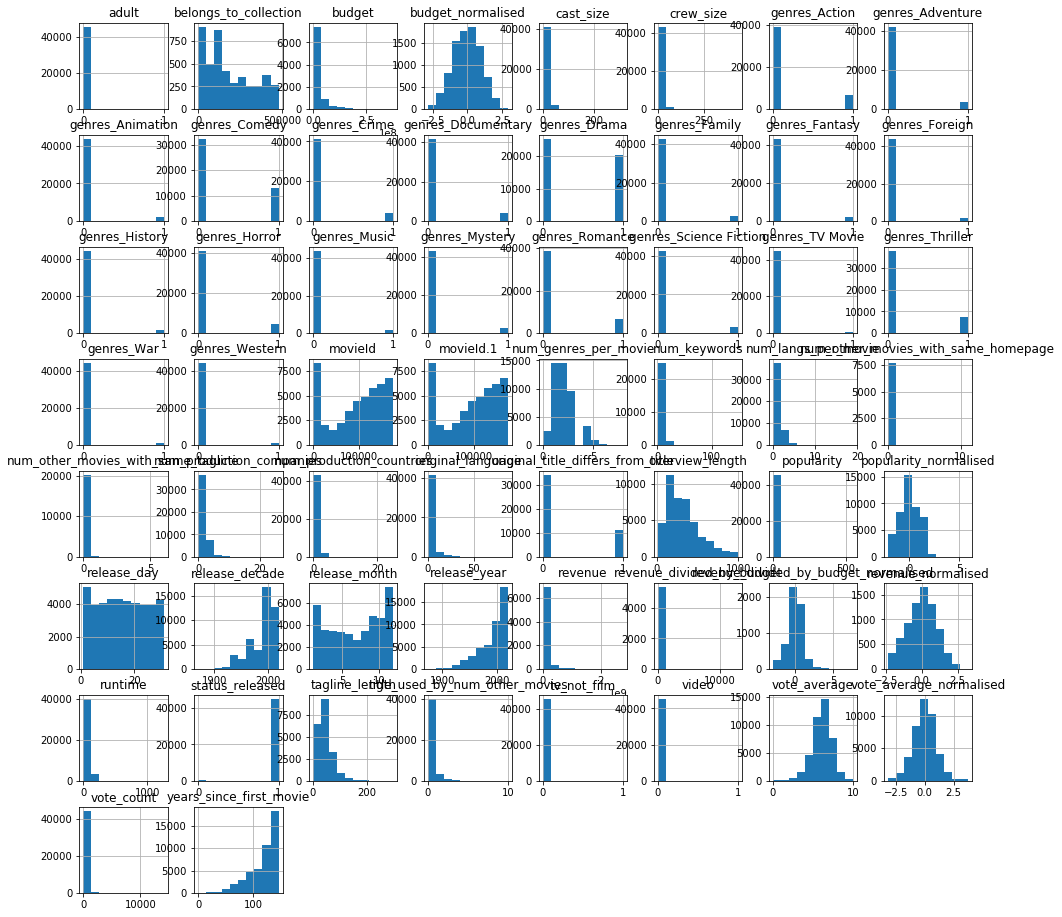

In [240]:
TMB_movies_metadata.hist(figsize =(16,16));
# belongs_to_collection -> could be renamed to be more clearly an id

In [ ]:
# TMB_langs -> need to get English language names!

In [273]:
# fix those 11 language nulls
TMB_movies_metadata.loc[TMB_movies_metadata["original_language"].isnull(),"original_language"] = 0
TMB_movies_metadata.loc[154832,"original_language"] = 18
TMB_movies_metadata.loc[172651,"original_language"] = 1
TMB_movies_metadata.loc[173819,"original_language"] = 4
TMB_movies_metadata.loc[173997,"original_language"] = 1
TMB_movies_metadata["original_language"] = TMB_movies_metadata["original_language"].astype('int')

In [276]:
original_language = TMB_movies_metadata["original_language"].copy()

language_dummy_number = 20

original_language_reduced = "language_"+original_language.apply(lambda x: TMB_langs.loc[x,"name"] if x<(language_dummy_number-1) else "Other")

original_language_reduced_dummied = pd.get_dummies(original_language_reduced)

TMB_movies_metadata[original_language_reduced_dummied.columns] = original_language_reduced_dummied

In [297]:
#### release decade --> dummy up!

In [300]:
objects = (TMB_movies_metadata.dtypes=='object') # lists, string - and one datetime object
object_cols = objects[objects].index
# TMB_movies_metadata[bool_cols] = TMB_movies_metadata[bool_cols].astype('int')
object_cols

Index(['homepage', 'original_title', 'overview', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'spoken_languages', 'status', 'tagline', 'title', 'keyword_id_list',
       'cast_list', 'crew_list'],
      dtype='object')

In [303]:
Id_columns = ["movieId","collectionId","original_language"]
unnormalised_columns = ["popularity","vote_average","budget","revenue","revenue_divided_by_budget"]

In [304]:
TMB_movies_numerical = TMB_movies_metadata.drop(object_cols,axis=1).drop(Id_columns,axis=1).drop(unnormalised_columns,axis=1).copy()

In [307]:
TMB_movies_numerical.describe()

adult  belongs_to_collection       runtime         video  \
count  45433.000000           45433.000000  43618.000000  45433.000000   
mean       0.000198               0.098783     97.480352      0.002047   
std        0.014073               0.298373     34.619451      0.045198   
min        0.000000               0.000000      1.000000      0.000000   
25%        0.000000               0.000000     86.000000      0.000000   
50%        0.000000               0.000000     95.000000      0.000000   
75%        0.000000               0.000000    107.000000      0.000000   
max        1.000000               1.000000   1256.000000      1.000000   

         vote_count  genres_Adventure  genres_Fantasy  genres_Animation  \
count  45433.000000      45433.000000    45433.000000      45433.000000   
mean     109.929545          0.076816        0.050822          0.042502   
std      491.450762          0.266303        0.219637          0.201734   
min        0.000000          0.000000        0.000000          0.000000   
25%        3.000000          0.000000        0.000000          0.000000   
50%       10.000000          0.000000        0.000000          0.000000   
75%       34.000000          0.000000        0.000000          0.000000   
max    14075.000000          1.000000        1.000000          1.000000   

       genres_Drama  genres_Horror  ...  language_Pусский  language_Türkçe  \
count  45433.000000   45433.000000  ...      45433.000000     45433.000000   
mean       0.445579       0.102811  ...          0.018181         0.003302   
std        0.497035       0.303715  ...          0.133606         0.057365   
min        0.000000       0.000000  ...          0.000000         0.000000   
25%        0.000000       0.000000  ...          0.000000         0.000000   
50%        0.000000       0.000000  ...          0.000000         0.000000   
75%        1.000000       0.000000  ...          0.000000         0.000000   
max        1.000000       1.000000  ...          1.000000         1.000000   

       language_suomi  language_svenska  language_Český  language_हिन्दी  \
count    45433.000000      45433.000000    45433.000000     45433.000000   
mean         0.006493          0.008430        0.002883         0.011181   
std          0.080318          0.091428        0.053620         0.105150   
min          0.000000          0.000000        0.000000         0.000000   
25%          0.000000          0.000000        0.000000         0.000000   
50%          0.000000          0.000000        0.000000         0.000000   
75%          0.000000          0.000000        0.000000         0.000000   
max          1.000000          1.000000        1.000000         1.000000   

       language_广州话 / 廣州話  language_日本語  language_普通话  language_한국어/조선말  
count        45433.000000  45433.000000  45433.000000      45433.000000  
mean             0.006889      0.029648      0.009002          0.009773  
std              0.082716      0.169616      0.094453          0.098373  
min              0.000000      0.000000      0.000000          0.000000  
25%              0.000000      0.000000      0.000000          0.000000  
50%              0.000000      0.000000      0.000000          0.000000  
75%              0.000000      0.000000      0.000000          0.000000  
max              1.000000      1.000000      1.000000          1.000000  

[8 rows x 70 columns]

In [310]:
TMB_movies_numerical.isnull().sum().sort_values().tail(20)

genres_TV Movie                             0
vote_count                                  0
genres_Action                               0
years_since_first_movie                    84
release_decade                             84
release_year                               84
crew_size                                 772
overview_length                          1114
runtime                                  1815
cast_size                                2415
vote_average_normalised                  2896
release_month                            3226
release_day                              3226
num_keywords                            19445
tagline_length                          25036
num_other_movies_with_same_tagline      25036
budget_normalised                       36553
num_other_movies_with_same_homepage     37659
revenue_normalised                      38035
revenue_divided_by_budget_normalised    40058
dtype: int64

7     8862
6     8514
4     8373
5     5076
3     3605
1     2809
8     2806
9     1847
0     1597
2      918
10     627
11     242
12      66
13      39
14      21
15      12
16      11
17       8
dtype: int64

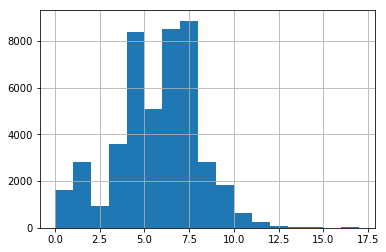

In [316]:
row_missingness = TMB_movies_numerical.isnull().sum(axis=1)
row_missingness.hist(bins=17)
row_missingness.value_counts()


In [315]:
TMB_movies_metadata[row_missingness>=17]

movieId  adult  belongs_to_collection  budget homepage  \
movieId                                                           
90617      90617      0                      0     NaN      NaN   
92747      92747      0                      0     NaN      NaN   
99596      99596      0                      0     NaN      NaN   
154386    154386      0                      0     NaN      NaN   
163010    163010      0                      0     NaN      NaN   
166289    166289      0                      0     NaN      NaN   
167098    167098      0                      0     NaN      NaN   
174953    174953      0                      0     NaN      NaN   

         original_language                          original_title overview  \
movieId                                                                       
90617                 16.0                              Pajęczarki      NaN   
92747                 13.0                     Pölynimurikauppiaat      NaN   
99596                 13.0                            Aurinkotuuli      NaN   
154386                14.0       Normaal: Ik Kom Altied Weer Terug      NaN   
163010                 0.0                           Bad Dad Rehab      NaN   
166289                 5.0                 Allende en su laberinto      NaN   
167098                 4.0  Dolpo Tulku - Heimkehr in den Himalaya      NaN   
174953                11.0                               Mundo Cão      NaN   

         popularity                       poster_path  ... language_Pусский  \
movieId                                                ...                    
90617      0.000000                               NaN  ...                0   
92747      0.000000                               NaN  ...                0   
99596      0.000127                               NaN  ...                0   
154386     0.000000  /fFBqjfnwTu4O02xfMRbMQfJfCA7.jpg  ...                0   
163010     0.000253  /oUgQBEPLA8VAZtu5krty5zgKV1u.jpg  ...                0   
166289     0.000000  /4qVpxyEtTZek9NZeasOIKdKOOve.jpg  ...                0   
167098     0.000000                               NaN  ...                0   
174953     0.000331                               NaN  ...                0   

        language_Türkçe language_suomi  language_svenska  language_Český  \
movieId                                                                    
90617                 0              0                 0               0   
92747                 0              1                 0               0   
99596                 0              1                 0               0   
154386                0              0                 0               0   
163010                0              0                 0               0   
166289                0              0                 0               0   
167098                0              0                 0               0   
174953                0              0                 0               0   

        language_हिन्दी language_广州话 / 廣州話 language_日本語 language_普通话  \
movieId                                                                
90617                 0                  0            0            0   
92747                 0                  0            0            0   
99596                 0                  0            0            0   
154386                0                  0            0            0   
163010                0                  0            0            0   
166289                0                  0            0            0   
167098                0                  0            0            0   
174953                0                  0            0            0   

         language_한국어/조선말  
movieId                    
90617                   0  
92747                   0  
99596                   0  
154386                  0  
163010                  0  
166289                  0  
167098                  0  
174953                

In [323]:
TMB_movies_metadata_no_nan.columns

Index(['adult', 'belongs_to_collection', 'runtime', 'video', 'vote_count',
       'genres_Adventure', 'genres_Fantasy', 'genres_Animation',
       'genres_Drama', 'genres_Horror', 'genres_Action', 'genres_Comedy',
       'genres_History', 'genres_Western', 'genres_Thriller', 'genres_Crime',
       'genres_Documentary', 'genres_Science Fiction', 'genres_Mystery',
       'genres_Music', 'genres_Romance', 'genres_Family', 'genres_War',
       'genres_Foreign', 'genres_TV Movie', 'num_genres_per_movie',
       'num_langs_per_movie', 'original_title_differs_from_title',
       'title_used_by_num_other_movies', 'popularity_normalised',
       'num_production_companies', 'num_production_countries', 'release_year',
       'release_month', 'release_day', 'release_decade',
       'years_since_first_movie', 'tv_not_film',
       'num_other_movies_with_same_homepage', 'overview_length',
       'status_released', 'num_other_movies_with_same_tagline',
       'tagline_length', 'vote_average_normalise

In [319]:
TMB_movies_metadata_no_nan = TMB_movies_numerical.fillna(TMB_movies_numerical.mean()).copy()

In [322]:
TMB_movies_metadata_no_nan.to_stata(Dataset_directory+"Processed"+os.sep+ "TMB_movies_metadata_no_nan.dta")
# set up for doing Bayesian Belief Network fitting

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\pandas\io\stata.py:2136: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    b'genres_Science Fiction'   ->   genres_Science_Fiction
    b'genres_TV Movie'   ->   genres_TV_Movie
    b'original_title_differs_from_title'   ->   original_title_differs_from_titl
    b'num_other_movies_with_same_homepage'   ->   num_other_movies_with_same_homep
    b'num_other_movies_with_same_tagline'   ->   num_other_movies_with_same_tagli
    b'revenue_divided_by_budget_normalised'   ->   revenue_divided_by_budget_normal
    b'language_Espa\xc3\xb1ol'   ->   language_Espa_ol
    b'language_Fran\xc3\xa7ais'   ->   language_Fran_ais
    b'language_Portugu\xc3\xaas'   ->   language_Portugu_s
    b'language_P\xd1\x83\xd1\x81\xd1\x81\xd0\xba\xd0\xb8\xd0\xb9'   ->   language_P______
    b'language_T\xc3\xbcrk\xc3\xa7e'   ->   language_T_rk_e
    b'language_\xc

In [324]:
pattern = "revenue_divided_by_budget_normalised"
name = "revenue_divided_by_budget_normalised"
corr_type = "spearman"
df,corr_type = make_corr_summary(TMB_movies_numerical, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

## FIX display_corr not to overrun when limited pos/neg coe


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Top 20 positive (spearman) correlations for revenue_divided_by_budget_normalised r p N 
 
 revenue_normalised 
 0.6 
 0.00 
 5375 
 
 
 vote_count 
 0.4 
 0.00 
 5375 
 
 
 belongs_to_collection 
 0.31 
 0.00 
 5375 
 
 
 vote_average_normalised 
 0.3 
 0.00 
 5368 
 
 
 popularity_normalised 
 0.27 
 0.00 
 5375 
 
 
 num_keywords 
 0.2 
 0.00 
 4841 
 
 
 cast_size 
 0.18 
 0.00 
 5364 
 
 
 crew_size 
 0.14 
 0.00 
 5370 
 
 
 num_other_movies_with_same_homepage 
 0.11 
 0.00 
 1914 
 
 
 runtime 
 0.06 
 0.00 
 5363 
 
 
 genres_Family 
 0.06 
 0.00 
 5375 
 
 
 language_हिन्दी 
 0.05 
 0.00 
 5375 
 
 
 genres_Adventure 
 0.05 
 0.00 
 5375 
 
 
 genres_Animation 
 0.05 
 0.00 
 5375 
 
 
 genres_Horror 
 0.05 
 0.00 
 5375 
 
 
 genres_Foreign 
 -0.04 
 0.00 
 5375 
 
 
 genres_Thriller 
 -0.04 
 0.00 
 5375 
 
 
 language_Pусский 
 -0.04 
 0.00 
 5375 
 
 
 language_Français 
 -0.08 
 0.00 
 5375 
 
 
 budget_normalised 
 -0.08 
 0.00 
 5375 
 
 Top 20 negative (spearman) correlations for revenue_divided_by_budget_normalised r p N 
 
 release_year 
 -0.12 
 0.00 
 5375 
 
 
 release_decade 
 -0.12 
 0.00 
 5375 
 
 
 years_since_first_movie 
 -0.12 
 0.00 
 5375 
 
 
 genres_Drama 
 -0.1 
 0.00 
 5375 
 
 
 language_Français 
 -0.08 
 0.00 
 5375 
 
 
 budget_normalised 
 -0.08 
 0.00 
 5375 
 
 
 num_production_countries 
 -0.08 
 0.00 
 5375 
 
 
 genres_Foreign 
 -0.04 
 0.00 
 5375 
 
 
 genres_Thriller 
 -0.04 
 0.00 
 5375 
 
 
 language_Pусский 
 -0.04 
 0.00 
 5375 
 
 
 genres_Horror 
 0.05 
 0.00 
 5375 
 
 
 genres_Animation 
 0.05 
 0.00 
 5375 
 
 
 genres_Adventure 
 0.05 
 0.00 
 5375 
 
 
 language_हिन्दी 
 0.05 
 0.00 
 5375 
 
 
 runtime 
 0.06 
 0.00 
 5363 
 
 
 genres_Family 
 0.06 
 0.00 
 5375 
 
 
 num_other_movies_with_same_homepage 
 0.11 
 0.00 
 1914 
 
 
 crew_size 
 0.14 
 0.00 
 5370 
 
 
 cast_size 
 0.18 
 0.00 
 5364 
 
 
 num_keywords 
 0.2 
 0.00 
 4841

In [325]:
pattern = "revenue_normalised"
name = "revenue_normalised"
corr_type = "spearman"
df,corr_type = make_corr_summary(TMB_movies_numerical, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)

## FIX display_corr not to overrun when limited pos/neg coe


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Top 20 positive (spearman) correlations for revenue_normalised r p N 
 
 vote_count 
 0.72 
 0.00 
 7398 
 
 
 budget_normalised 
 0.71 
 0.00 
 5375 
 
 
 revenue_divided_by_budget_normalised 
 0.6 
 0.00 
 5375 
 
 
 popularity_normalised 
 0.59 
 0.00 
 7398 
 
 
 crew_size 
 0.43 
 0.00 
 7386 
 
 
 cast_size 
 0.41 
 0.00 
 7364 
 
 
 belongs_to_collection 
 0.31 
 0.00 
 7398 
 
 
 runtime 
 0.26 
 0.00 
 7371 
 
 
 num_production_companies 
 0.26 
 0.00 
 7398 
 
 
 genres_Adventure 
 0.25 
 0.00 
 7398 
 
 
 num_keywords 
 0.25 
 0.00 
 6405 
 
 
 num_genres_per_movie 
 0.22 
 0.00 
 7398 
 
 
 language_English 
 0.21 
 0.00 
 7398 
 
 
 genres_Action 
 0.19 
 0.00 
 7398 
 
 
 genres_Family 
 0.19 
 0.00 
 7398 
 
 
 genres_Fantasy 
 0.15 
 0.00 
 7398 
 
 
 num_other_movies_with_same_homepage 
 0.15 
 0.00 
 2366 
 
 
 genres_Animation 
 0.13 
 0.00 
 7398 
 
 
 genres_Science Fiction 
 0.11 
 0.00 
 7398 
 
 
 vote_average_normalised 
 0.11 
 0.00 
 7361 
 
 Top 20 negative (spearman) correlations for revenue_normalised r p N 
 
 original_title_differs_from_title 
 -0.19 
 0.00 
 7398 
 
 
 genres_Documentary 
 -0.18 
 0.00 
 7398 
 
 
 genres_Drama 
 -0.18 
 0.00 
 7398 
 
 
 language_Français 
 -0.13 
 0.00 
 7398 
 
 
 tagline_length 
 -0.12 
 0.00 
 5941 
 
 
 genres_Foreign 
 -0.1 
 0.00 
 7398 
 
 
 language_Other 
 -0.09 
 0.00 
 7398 
 
 
 language_Pусский 
 -0.09 
 0.00 
 7398 
 
 
 language_Español 
 -0.07 
 0.00 
 7398 
 
 
 language_Italiano 
 -0.06 
 0.00 
 7398 
 
 
 language_Deutsch 
 -0.05 
 0.00 
 7398 
 
 
 genres_Romance 
 -0.04 
 0.00 
 7398 
 
 
 genres_Horror 
 -0.03 
 0.01 
 7398 
 
 
 language_한국어/조선말 
 -0.03 
 0.01 
 7398 
 
 
 title_used_by_num_other_movies 
 0.03 
 0.01 
 7398 
 
 
 status_released 
 0.04 
 0.00 
 7398 
 
 
 release_month 
 0.04 
 0.00 
 7320 
 
 
 genres_Crime 
 0.04 
 0.00 
 7398 
 
 
 genres_Comedy 
 0.04 
 0.00 
 7398 
 
 
 release_day 
 0.05 
 0.00 
 7320

In [328]:
output_subfolder = ".."+os.sep+"Output"+os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(TMB_movies_metadata_no_nan.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = TMB_movies_metadata_no_nan.columns,
                             index   = TMB_movies_metadata_no_nan.index      )

%%time

n_components = BES_std.shape[1]
n_components = 10

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = TMB_movies_metadata_no_nan.index)



load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
#     if not os.path.exists(subdir): os.makedirs(subdir)
#     with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
#     BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
#     BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
# else: # LOAD decomp results (default is SAVE)
#     decomp_method = load_suff
#     subdir = output_subfolder + os.sep + decomp_method    
#     fname = subdir + os.sep + decomp_method
#     if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
#     # load decomp object, BES_decomp, BES_std, n_components
#     with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
#     BES_decomp = pd.read_hdf(fname+".hdf")
#     BES_std    = pd.read_hdf(fname+"_std"+".hdf")
#     n_components = decomp.components_.shape[0] 

display_pca_data(n_components, decomp, BES_std)



(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          TMB_movies_metadata_no_nan.columns, BES_decomp, manifest=None, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 10, show_histogram = False)

In [14]:
[x for x in TMB_movies_metadata.columns if "revenue" in x]

['revenue',
 'revenue_divided_by_budget',
 'revenue_normalised',
 'revenue_divided_by_budget_normalised']

In [10]:
TMB_movies_metadata['num_production_countries'].value_counts()

1     32135
0      6279
2      4872
3      1468
4       460
5       151
6        38
7        12
8         7
9         5
11        2
25        1
15        1
12        1
10        1
Name: num_production_countries, dtype: int64

In [21]:
TMB_movies_metadata.sort_values(by = "revenue_divided_by_budget", ascending=True)[["title","revenue_divided_by_budget", "budget","revenue"]].dropna().head(50)

title  \
movieId                                                      
99746                                        The Samaritan   
114856          The Adventurer: The Curse of the Midas Box   
167478                                     The Guillotines   
160581                                            The Duel   
120102                                           Fishtales   
101599                                     The Good Doctor   
94998                                        5 Days of War   
106881                                          Sweetwater   
85226                                      Janky Promoters   
96456                                                  ATM   
102941                                      Special Forces   
120222                                          Foodfight!   
101761                                Welcome to the Punch   
101823                                    Poor White Trash   
102354                                        About Cherry   
157959                                           Term Life   
96966                                     Laurence Anyways   
110390                                       Best Man Down   
98022                                      Sleepless Night   
54978                                       The Good Night   
96066                              Love, Wedding, Marriage   
4092                                           Cherry 2000   
106624                                          Twice Born   
5789                                   All The Queen's Men   
133710                                        Strangerland   
74139                                        The Red Baron   
113565                                       The Sacrament   
109853                                            Barefoot   
62304    The Tulse Luper Suitcases, Part 1: The Moab Story   
110286                                             13 Sins   
3569                                            The Idiots   
121275                                     Highway to Hell   
133241                                            Jimmy P.   
5164                               A Troll in Central Park   
90428                                             Margaret   
98755                                                 1911   
87166                                               Stolen   
26142                                         Major Dundee   
111375                                       Walk of Shame   
155509                                           Mr. Right   
5684                                            Naqoyqatsi   
1853           An Alan Smithee Film: Burn, Hollywood, Burn   
164111                           From the Land of the Moon   
3275                                   The Boondock Saints   
5020                                        Silent Trigger   
131270                                      Kung Fu Jungle   
171205                                             Королёв   
69720                                       Hood of Horror   
103219                                              Maniac   
144206                                       Standing Tall   

         revenue_divided_by_budget      budget   revenue  
movieId                                                   
99746                     0.000210  12000000.0    2521.0  
114856                    0.000256  25000000.0    6399.0  
167478                    0.000353  15000000.0    5290.0  
160581                    0.000450  10000000.0    4500.0  
120102                    0.000658  14000000.0    9216.0  
101599                    0.000868   6000000.0    5206.0  
94998                     0.000874  20000000.0   17479.0  
106881                    0.000878   7000000.0    6147.0  
85226                     0.000907  10000000.0    9069.0  
96456                     0.001003   3000000.0    3010.0  
102941                    0.001076  10000000.0   10759.0  
120222                    0.001134  65000000.0   73706.0  
10

In [ ]:
# The Boondock Saints

In [22]:
TMB_movies_metadata['num_production_countries'].value_counts()

1     32135
0      6279
2      4872
3      1468
4       460
5       151
6        38
7        12
8         7
9         5
11        2
25        1
15        1
12        1
10        1
Name: num_production_countries, dtype: int64

In [35]:
rev_by_prod_country

revenue_divided_by_budget
production_countries                           
AU                                    13.996280
BE                                     2.678571
BG                                     0.259237
BR                                     1.207504
CA                                     1.324851
CN                                     6.852953
DE                                     7.988435
DK                                     1.132438
ES                                     3.533293
FI                                     0.859642
FR                                     2.659115
GB                                     7.427400
HK                                    86.303131
HU                                     1.777043
ID                                     0.583824
IE                                    26.749209
IL                                     1.094468
IN                                     5.242632
IR                                     5.000000
IT                                     3.039270
JP                                     3.771364
KR                                     5.221026
MX                                     7.156916
NL                                     3.532802
NO                                     1.530563
NZ                                     2.120644
PH                                     9.503920
PK                                     4.506738
PL                                     1.454802
RO                                     0.044336
RS                                     0.913000
RU                                     2.441494
SE                                     8.381575
SG                                     0.532710
TH                                     1.051372
TR                                     6.385811
TW                                     0.380805
UA                                     0.691289
US                                    13.159053
ZA                                     2.326346

In [41]:
# 
mask = TMB_movies_metadata['num_production_countries']==1
countries = TMB_movies_metadata['production_countries'][mask].apply(lambda x: eval(x)[0])
rev_by_prod_country = pd.concat([ TMB_movies_metadata["revenue_divided_by_budget"][mask],
                                  countries,
                                  ],axis=1).groupby("production_countries").mean().dropna()
num_by_prod_country = pd.concat([ TMB_movies_metadata["revenue_divided_by_budget"][mask],
                                  countries,
                                  ],axis=1).groupby("production_countries").apply(lambda x: x.shape[0]).dropna()
# rev_by_prod_country.sort_values(by = "revenue_divided_by_budget")
rev_by_prod_country["N"] = num_by_prod_country.loc[rev_by_prod_country.index]
# rev_by_prod_country.sort_values(by = "revenue_divided_by_budget")

In [55]:
TMB_movies_metadata[mask][countries=="RO"][["title","overview","release_year"]]

title  \
movieId                                                    
27271                                              Taboo   
34729                                        One Point O   
47150                         The Death of Mr. Lazarescu   
52796                                               West   
54426                            12:08 East of Bucharest   
64099                                    Stuff and Dough   
65651                Fire and Ice: The Dragon Chronicles   
67422                                California Dreamin'   
72491                                  Police, Adjective   
73317      The Prophet, the Gold, and the Transylvanians   
73639    The Actress, the Dollars and the Transylvanians   
73987           The Oil, the Baby and the Transylvanians   
76808               The Way I Spent the End of the World   
78329                                    The Reenactment   
80731                             The Paper Will Be Blue   
81806         Vlad the Impaler: The True Life of Dracula   
84128                           Tuesday, After Christmas   
86497                                                 15   
87354                 Then I Sentenced Them All to Death   
91619                 Why Are the Bells Ringing, Mitica?   
91683                                      Metrobranding   
92968                      The World According to Ion B.   
93070                                           The Bear   
93931                                      Lust for Gold   
99798                              Somewhere in Palilula   
101264                                          Elevator   
103317                             Cigarettes and Coffee   
105388                                Prison of the Dead   
105863                                      Child's Pose   
106017                               Hello! How Are You?   
107204                                          Outbound   
114234                      Uncle Marin, the Billionaire   
114497                                               Wer   
123949                           Quod erat demonstrandum   
128874                               The Moromete Family   
137138                                              Ryna   
154612                       Crulic - The Path to Beyond   
158109                      A Commissioner's Accusations   
158111                                           Revenge   
158113                                      The Survivor   
158115                                          The Duel   
158117                                   The Last Bullet   
161266                                     The Immortals   
161276                                        Kiuleandra   
164971                               Two Lottery Tickets   
164973                                     Love Building   
165759                             The Mill of Good Luck   
166443                                    Summer Holiday   
167404                               Ecaterina Teodoroiu   
168314                        Be My Cat: A Film for Anne   
170593                                         Galgameth   

                                                  overview  release_year  
movieId                                                                   
27271    Six young adults struggle with their personal ...        2002.0  
34729    Paranoid computer programmer Simon wakes up to...        2004.0  
47150    Mr. Lazarescu (Ion Fiscuteanu) is a retired Ro...        2005.0  
52796    "Occident" is a bitter comedy about the people...        2002.0  
54426    It's the 22nd of December. Sixteen years have ...        2006.0  
64099    A young man from Constanța who has his own bus...        2001.0  
65651    Princess Luisa and knight Gabriel must face a ...        2008.0  
67422    Romanian director Cristian Nemescu's comedy Ca...        2007.0  
72491    A cop named Cristi must go undercover to trail...        2009.0  
73317                                        

In [ ]:
# Police, Adjective

In [53]:
rev_by_prod_country.sort_values(by = "revenue_divided_by_budget")

revenue_divided_by_budget      N
production_countries                                  
RO                                     0.044336     51
BG                                     0.259237      7
TW                                     0.380805     63
SG                                     0.532710     12
ID                                     0.583824     23
UA                                     0.691289     16
FI                                     0.859642    269
RS                                     0.913000     35
TH                                     1.051372     72
IL                                     1.094468     64
DK                                     1.132438    178
BR                                     1.207504    206
CA                                     1.324851    841
PL                                     1.454802    214
NO                                     1.530563    100
HU                                     1.777043     89
NZ                                     2.120644     63
ZA                                     2.326346     33
RU                                     2.441494    735
FR                                     2.659115   1653
BE                                     2.678571     83
IT                                     3.039270   1030
NL                                     3.532802    160
ES                                     3.533293    398
JP                                     3.771364   1354
PK                                     4.506738     10
IR                                     5.000000     69
KR                                     5.221026    432
IN                                     5.242632    735
TR                                     6.385811    117
CN                                     6.852953    164
MX                                     7.156916    155
GB                                     7.427400   2238
DE                                     7.988435    748
SE                                     8.381575    332
PH                                     9.503920     47
US                                    13.159053  17841
AU                                    13.996280    336
IE                                    26.749209     45
HK                                    86.303131    365

In [ ]:
# Hong Kong??? ->> Bruce Lee???

In [ ]:
PERS_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_cast"+".csv")

In [84]:
big5_corr_df = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_big5_corr.csv")
big5_corr_df.index = big5_corr["movieId"]

In [38]:
# big5_corr_df

In [39]:
# TMB_movies_metadata

In [79]:
intersect = intersection(big5_corr_df.index,TMB_movies_metadata.index)
big5_corr_df["shared_coverage"] = False
big5_corr_df.loc[intersect,"shared_coverage"] = True

In [82]:
len(intersect)

31896

In [81]:
@interact
def show_articles_more_than(column=big5_corr_df.columns, x=(-1,1,.1), n=(2,100,1), lt=True, return_top=20):
    show_cols = ['title','release_year','overview','tagline','runtime','budget','revenue']
    if lt:
        mask = (big5_corr_df[column]<=-x) & (big5_corr_df["N"]>=n) & big5_corr_df["shared_coverage"]
        indices = big5_corr_df[ mask ].sort_values(by=column,ascending=True).index
#         return TMB_movies_metadata.loc[intersection(indices,TMB_movies_metadata.index)][show_cols].head(return_top)
    else:
        mask = (big5_corr_df[column]>=x) & (big5_corr_df["N"]>=n) & big5_corr_df["shared_coverage"]
        indices = big5_corr_df[ mask ].sort_values(by=column,ascending=False).index
    return pd.concat([big5_corr_df.loc[indices][column],
                      TMB_movies_metadata.loc[indices][show_cols]],
                         axis=1).head(return_top)

interactive(children=(Dropdown(description='column', options=('movieId', 'agreeableness_mean', 'agreeableness_…

In [70]:
TMB_movies_metadata.columns
# [['title','release_year','overview','tagline','runtime','budget','revenue']]

Index(['movieId', 'adult', 'belongs_to_collection', 'budget', 'homepage',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count',
       'genres_Adventure', 'genres_Fantasy', 'genres_Animation',
       'genres_Drama', 'genres_Horror', 'genres_Action', 'genres_Comedy',
       'genres_History', 'genres_Western', 'genres_Thriller', 'genres_Crime',
       'genres_Documentary', 'genres_Science Fiction', 'genres_Mystery',
       'genres_Music', 'genres_Romance', 'genres_Family', 'genres_War',
       'genres_Foreign', 'genres_TV Movie', 'num_genres_per_movie',
       'num_langs_per_movie', 'original_title_differs_from_title',
       'title_used_by_num_other_movies', 'popularity_normalised',
       'num_production_companies', 'num_production_countries', 'release_year',
 

In [65]:
len( intersection( TMB_movies_metadata.index, big5_corr_df.index) )
# intersection = 31896
# big5_corr_df["movieId"] unique= 35196

31896

In [83]:
# big5_corr_df["movieId"].value_counts()

In [ ]:
# big5_corr_df = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_big5_corr.csv")
# big5_corr_df.index = big5_corr["movieId"]

In [122]:
LEARN_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"LEARN_movie_ratings.csv")
LEARN_movie_ratings.index = LEARN_movie_ratings["movieId"]

ML_links = pd.read_csv(Dataset_directory+"Processed"+os.sep+"ML_links.csv",index_col="Unnamed: 0")
ML_links.index = ML_links["movieId"]

ML_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"ML_movie_ratings.csv")
ML_movie_ratings.index = ML_movie_ratings["movieId"]

ML_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"ML_movies.csv",index_col="Unnamed: 0")
ML_movies.index = ML_movies["movieId"]

PERS_big5_corr = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_big5_corr.csv")
PERS_big5_corr.index = PERS_big5_corr["movieId"]

PERS_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_movie_ratings.csv")
PERS_movie_ratings.index = PERS_movie_ratings["movieId"]

SER_answers_by_movieId = pd.read_csv(Dataset_directory+"Processed"+os.sep+"SER_answers_by_movieId.csv")
SER_answers_by_movieId.index = SER_answers_by_movieId["movieId"]

SER_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"SER_movie_ratings.csv")
SER_movie_ratings.index = SER_movie_ratings["movieId"]

SER_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"SER_movies.csv",index_col="Unnamed: 0")
SER_movies.index = SER_movies["movieId"]

HETREC_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"HETREC_movies"+".csv",index_col="id.1")
HETREC_movies.index = HETREC_movies["id"]

HETREC_user_ratings= pd.read_csv(Dataset_directory+"Processed"+os.sep+"HETREC_user_ratings"+".csv")
HETREC_user_ratings.index =HETREC_user_ratings["movieID"]

In [11]:
TMB_movies_metadata.shape, TMB_links_amalgamated.shape, len( intersection( TMB_movies_metadata.index,TMB_links_amalgamated.index ) )

((45433, 65), (45845, 3), 45433)

In [12]:
ML_links.shape, ML_movie_ratings.shape, ML_movies.shape

((58098, 3), (53889, 4), (58098, 3))

In [13]:
TMB_movies_metadata.shape, ML_movies.shape, len( intersection( TMB_movies_metadata.index,ML_movies.index ) )

((45433, 65), (58098, 3), 45410)

In [14]:
TMB_movies_metadata.shape, LEARN_movie_ratings.shape, len( intersection( TMB_movies_metadata.index,LEARN_movie_ratings.index ) )

((45433, 65), (13012, 4), 12887)

In [17]:
PERS_big5_corr.shape, PERS_movie_ratings.shape

((35196, 22), (35196, 4))

In [16]:
TMB_movies_metadata.shape, PERS_movie_ratings.shape, len( intersection( TMB_movies_metadata.index,PERS_movie_ratings.index ) )

((45433, 65), (35196, 4), 31896)

In [18]:
SER_answers_by_movieId.shape, SER_movie_ratings.shape, SER_movies.shape

((1678, 21), (49151, 4), (49174, 15))

In [22]:
TMB_movies_metadata.shape, SER_movies.shape, len( intersection( TMB_movies_metadata.index,SER_movies.index ) )

((45433, 65), (49174, 15), 44607)

In [33]:
HETREC_movies.shape, HETREC_user_ratings.shape

((10197, 24), (10109, 4))

In [34]:
TMB_movies_metadata.shape, HETREC_movies.shape, len( intersection( TMB_movies_metadata.index,HETREC_movies.index ) )

((45433, 65), (10197, 24), 10150)

In [133]:
TMB_links_amalgamated.columns

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

In [134]:
ML_links.columns

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

In [489]:
HETREC_links = HETREC_movies[["id","imdbID"]].copy()
HETREC_links.columns = ["movieId","imdbId"]

SER_links = SER_movies[['movieId', 'imdbId', 'tmdbId']].copy()

In [490]:
all_links = TMB_links_amalgamated.copy()
all_links = all_links.append(ML_links,ignore_index=True,sort=False)
all_links = all_links.append(SER_links,ignore_index=True,sort=False)
all_links = all_links.append(HETREC_links,ignore_index=True,sort=False)
all_links = all_links.drop_duplicates().copy()
all_links.drop([60996, 89829],inplace=True)
# movieId now unique (when you drop tmdbId nulls)

In [491]:
# fill in blank tmdbIds where they match movieIds

uni_movieId_no_nans = all_links[["movieId","imdbId","tmdbId"]].dropna().drop_duplicates().copy()
uni_movieId_no_nans = uni_movieId_no_nans.set_index("movieId")
uni_movieId_no_nans["tmdbId"] = uni_movieId_no_nans["tmdbId"].astype('int')

tmdbId_nulls = all_links["tmdbId"].isnull()

all_links.loc[tmdbId_nulls, "tmdbId"] = all_links[ tmdbId_nulls ].apply(lambda x: uni_movieId_no_nans.loc[x["movieId"],"tmdbId"] if x["movieId"] in uni_movieId_no_nans.index else np.nan, axis=1)

In [492]:
# squeeze out duplicates
imdbIds = all_links[['movieId', 'imdbId', 'tmdbId']].groupby("movieId").apply(lambda x: x["imdbId"].unique())
tmdbIds = all_links[['movieId', 'imdbId', 'tmdbId']].groupby("movieId").apply(lambda x: [int(y) for y in x["tmdbId"].dropna().unique()])


all_links = pd.DataFrame([imdbIds.index, imdbIds.values, tmdbIds.values ]).transpose()
all_links.columns = ['movieId', 'imdbId', 'tmdbId']
# imdbId has 1 or 2 entries (57858/1082)
# tmdbId has 0 or 1 entries (57978/962)
all_links.index = all_links["movieId"]

In [493]:
all_links["SER_title"] = all_links.apply(lambda x: SER_movies.loc[x["movieId"],"title"] if x["movieId"] in SER_movies.index else np.nan,axis=1)
all_links["ML_title"] = all_links.apply(lambda x: ML_movies.loc[x["movieId"],"title"] if x["movieId"] in ML_movies.index else np.nan,axis=1)
all_links["HETREC_title"] = all_links.apply(lambda x: HETREC_movies.loc[x["movieId"],"title"] + " ("+str( HETREC_movies.loc[x["movieId"],"year"] )+ ")" if x["movieId"] in HETREC_movies.index else np.nan,axis=1)

all_links["TMB_title"] = all_links.apply(lambda x: TMB_movies_metadata.loc[x["movieId"],"title"] + " ("+str( int( np.nan_to_num( TMB_movies_metadata.loc[x["movieId"],"release_year"] ) ) )+ ")" if x["movieId"] in TMB_movies_metadata.index else np.nan,axis=1)


In [494]:
title_cols = ['SER_title', 'ML_title', 'HETREC_title',
       'TMB_title']

titles = all_links[['SER_title', 'ML_title', 'HETREC_title',
       'TMB_title']].stack().unique()
titles_only = [x.split("(")[0].strip() for x in titles]

NUM_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"NUM_movies"+".csv", index_col = "Unnamed: 0")
NUM_movies.index = NUM_movies["scrape_count"]

NUM_titles = NUM_movies.apply(lambda x: x["title"] + " ("+str(x["release_year"])+")",axis=1)
NUM_titles_only = NUM_movies.apply(lambda x: x["title"],axis=1)

NUM_titles = NUM_titles.apply(lambda x: x.lower())
NUM_titles_only = NUM_titles_only.apply(lambda x: x.lower())

# 5769 -> 1484 non-matches with title (year), 791 non-matches with just title
# NUM_titles.apply(lambda x: x not in titles).sum()
# NUM_titles_only.apply(lambda x: x not in titles_only).sum()
# NUM_titles.shape
NUM_movies[['production_budget', 'domestic_gross', 'worldwide_gross']] = NUM_movies[['production_budget', 'domestic_gross', 'worldwide_gross']].replace(0,np.nan)
NUM_movies[['production_budget', 'domestic_gross', 'worldwide_gross']].isnull().sum()

production_budget      0
domestic_gross       550
worldwide_gross      367
dtype: int64

In [509]:
title_cols = ['SER_title', 'ML_title', 'HETREC_title',
       'TMB_title']
all_links["title_and_year_list"] = all_links[title_cols].apply(lambda x: [y.lower() for y in x.dropna().unique()], axis=1)
all_links["title_list"] = all_links[title_cols].apply(lambda x: np.unique([y.split("(")[0].strip().lower() for y in x.dropna()]), axis=1)



In [522]:
# all_links[0:1][title_cols].apply(lambda x: [y.lower() for y in x.unique()], axis=1)

# all_links["title_and_year_list"]
# all_links

In [520]:
example = "avatar (2009)"

# list(filter(lambda x: x < 0, number_list))

Int64Index([72998], dtype='int64', name='movieId')

In [524]:
NUM_to_movieId = NUM_titles.apply(lambda x: all_links.index[ all_links["title_and_year_list"].apply(lambda y: x in y) ])


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


KeyboardInterrupt: 

In [532]:
# %%time
NUM_to_movieId_titles_only = NUM_titles_only.apply(lambda x: all_links.index[ all_links["title_list"].apply(lambda y: x in y )])

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [535]:
NUM_to_movieId_titles_only = NUM_to_movieId_titles_only.apply(lambda x: list(x))

In [539]:
NUM_to_movieId = NUM_to_movieId.apply(lambda x: list(x))

In [537]:
NUM_to_movieId_titles_only.apply(lambda x: len(x)).value_counts()

1     3937
2      770
0      676
3      212
4      102
5       36
6       13
7       10
10       3
9        3
8        3
16       2
12       2
dtype: int64

In [569]:
all_links["title_list"].apply(lambda x: len(x)).value_counts()

1    49025
2     9211
3      701
0        3
Name: title_list, dtype: int64

In [578]:
re.sub( "[^a-z]" , "",all_links["title_list"].loc[193851][0] )

'ujuly'

In [583]:
all_links["title_chars_only"] = all_links["title_list"].apply( lambda x: [ re.sub( "[^a-z]" , "", y) for y in x ] )

In [588]:
NUM_titles_chars_only = NUM_titles_only.apply( lambda x: re.sub( "[^a-z]" , "", x) )

In [590]:
NUM_to_movieId_titles_chars_only = NUM_titles_chars_only.apply(lambda x: all_links.index[ all_links["title_chars_only"].apply(lambda y: x in y )])

In [593]:
NUM_to_movieId_titles_chars_only = NUM_to_movieId_titles_chars_only.apply(lambda x: list(x))

In [622]:
NUM_to_movieId_plus_close_matches.apply( lambda x: len(x) ).value_counts()

1     4712
0      502
2      451
3       72
4       19
5        7
7        2
6        2
13       1
8        1
dtype: int64

In [803]:
NUM_to_movieId_plus_close_matches = NUM_to_movieId.copy()

no_guess = NUM_to_movieId_plus_close_matches.apply(lambda x: len(x)==0)
NUM_to_movieId_plus_close_matches[no_guess] = NUM_to_movieId_titles_only[no_guess]

still_no_guess = NUM_to_movieId_plus_close_matches.apply(lambda x: len(x)==0)
NUM_to_movieId_plus_close_matches[still_no_guess] = NUM_to_movieId_titles_chars_only[still_no_guess]

NUM_to_movieId_plus_close_matches.loc[669  ] = []
NUM_to_movieId_plus_close_matches.loc[3441 ] = []
NUM_to_movieId_plus_close_matches.loc[3976 ] = []
NUM_to_movieId_plus_close_matches.loc[5593 ] = []
NUM_to_movieId_plus_close_matches.loc[4836 ] = []
NUM_to_movieId_plus_close_matches.loc[3921 ] = [91035]
NUM_to_movieId_plus_close_matches.loc[2825 ] = [1411]
NUM_to_movieId_plus_close_matches.loc[3162 ] = [134823]
NUM_to_movieId_plus_close_matches.loc[1297 ] = [273]
NUM_to_movieId_plus_close_matches.loc[3865 ] = []
NUM_to_movieId_plus_close_matches.loc[1014 ] = [30816]
NUM_to_movieId_plus_close_matches.loc[2558 ] = [89085]
NUM_to_movieId_plus_close_matches.loc[4453 ] = [112091]
NUM_to_movieId_plus_close_matches.loc[4854 ] = [143703]
NUM_to_movieId_plus_close_matches.loc[5318 ] = [101741]

NUM_to_movieId_plus_close_matches.loc[5520 ] = [5870]
NUM_to_movieId_plus_close_matches.loc[5585 ] = []
NUM_to_movieId_plus_close_matches.loc[39]    = [41569]
NUM_to_movieId_plus_close_matches.loc[578]   = [49278]
NUM_to_movieId_plus_close_matches.loc[1094]  = [253]
NUM_to_movieId_plus_close_matches.loc[1146]  = [3285]

NUM_to_movieId_plus_close_matches.loc[1146]  = [3285]
NUM_to_movieId_plus_close_matches.loc[1230]  = [68522]

NUM_to_movieId_plus_close_matches.loc[1730]  = [64231]
NUM_to_movieId_plus_close_matches.loc[1994]  = [50003]
NUM_to_movieId_plus_close_matches.loc[2223]  = [55872]

NUM_to_movieId_plus_close_matches.loc[3036]  = []
NUM_to_movieId_plus_close_matches.loc[3136]  = [27834]
NUM_to_movieId_plus_close_matches.loc[3192]  = [70208]

NUM_to_movieId_plus_close_matches.loc[3428]  = [4640]
NUM_to_movieId_plus_close_matches.loc[3438]  = [116893]
NUM_to_movieId_plus_close_matches.loc[3652]  = [3509]
NUM_to_movieId_plus_close_matches.loc[4223]  = [127305]
NUM_to_movieId_plus_close_matches.loc[4412]  = [58207]

NUM_to_movieId_plus_close_matches.loc[4738]  = []
NUM_to_movieId_plus_close_matches.loc[4955]  = [101415]
NUM_to_movieId_plus_close_matches.loc[5371]  = []

NUM_to_movieId_plus_close_matches.loc[5765]  = []
NUM_to_movieId_plus_close_matches.loc[5568]  = [34330]
NUM_to_movieId_plus_close_matches.loc[5473]  = []
NUM_to_movieId_plus_close_matches.loc[5159]  = []
NUM_to_movieId_plus_close_matches.loc[4998]  = [67624]
NUM_to_movieId_plus_close_matches.loc[4696]  = [43333]


In [804]:

NUM_to_movieId_plus_close_matches.loc[3559]  = [1030]
NUM_to_movieId_plus_close_matches.loc[355]   = [102686]
NUM_to_movieId_plus_close_matches.loc[3169]  = [2471]
NUM_to_movieId_plus_close_matches.loc[4243]  = [104908]
NUM_to_movieId_plus_close_matches.loc[208]   = [5459]
NUM_to_movieId_plus_close_matches.loc[2454]  = [199223]
NUM_to_movieId_plus_close_matches.loc[1794]  = [36519]
NUM_to_movieId_plus_close_matches.loc[5339]  = [107955]
NUM_to_movieId_plus_close_matches.loc[1083]  = [149352]
NUM_to_movieId_plus_close_matches.loc[5178]  = [110603]
NUM_to_movieId_plus_close_matches.loc[4831]  = []
NUM_to_movieId_plus_close_matches.loc[5642]  = []
NUM_to_movieId_plus_close_matches.loc[5733]  = []
NUM_to_movieId_plus_close_matches.loc[1172]  = [196223]
NUM_to_movieId_plus_close_matches.loc[5653]  = [2459]
NUM_to_movieId_plus_close_matches.loc[2006]  = []
NUM_to_movieId_plus_close_matches.loc[2286]  = []
NUM_to_movieId_plus_close_matches.loc[1012]  = [1320]
NUM_to_movieId_plus_close_matches.loc[5447]  = [79254]
NUM_to_movieId_plus_close_matches.loc[256]   = [91104]
NUM_to_movieId_plus_close_matches.loc[5318]  = []
NUM_to_movieId_plus_close_matches.loc[4858]  = [1976]


In [805]:
def add_yr(title):
    year = int(re.search("\((\d+)\)",title).groups()[0]) + 1
    return re.sub("\((\d+)\)","("+str(year)+")",title)

def red_yr(title):
    year = int(re.search("\((\d+)\)",title).groups()[0]) - 1
    return re.sub("\((\d+)\)","("+str(year)+")",title)

    
# title = NUM_titles.loc[scrape_count]    
# add_yr(title),red_yr(title)

In [807]:

for scrape_count in NUM_movies[ NUM_to_movieId_plus_close_matches.apply(lambda x: len(x)>1) ].index:
    title = NUM_titles.loc[scrape_count]
    best_match = all_links.loc[ NUM_to_movieId_plus_close_matches.loc[scrape_count] ][title_cols]\
        .replace(np.nan,"")\
        .applymap(lambda x: x.lower())\
        .apply(lambda x: (x==title)|(x==red_yr(title))|(x==add_yr(title)) )\
        .sum(axis=1)\
        .sort_values(ascending=False)\
        .index[0]
    
    NUM_to_movieId_plus_close_matches.loc[scrape_count] = [best_match]
#     display(all_links.loc[ NUM_to_movieId_plus_close_matches.loc[scrape_count] ][title_cols])
#     display(NUM_movies.loc[scrape_count])
#     print(best_match)

In [808]:
NUM_to_movieId_plus_close_matches.apply( lambda x: len(x) ).value_counts()

1    5252
0     517
dtype: int64

In [809]:
NUM_to_movieId_plus_close_matches = NUM_to_movieId_plus_close_matches.apply(lambda x: x[0] if len(x)==1 else np.nan)

In [882]:
NUM_to_movieId_plus_close_matches

scrape_count
1        72998.0
2        86880.0
3       122892.0
4            NaN
5            NaN
6            NaN
7        53125.0
8       122898.0
9       136020.0
10       91529.0
11      103384.0
12       93363.0
13       81847.0
14       52722.0
15      122920.0
16      136864.0
17       98809.0
18       69844.0
19      106489.0
20      118696.0
21      170875.0
22      187595.0
23       46530.0
24      122896.0
25       63113.0
26       89745.0
27       45722.0
28      103042.0
29       59501.0
30       95510.0
          ...   
5740      6978.0
5741         NaN
5742     93267.0
5743     99487.0
5744         NaN
5745         NaN
5746         NaN
5747     47793.0
5748     87964.0
5749         NaN
5750      2361.0
5751         NaN
5752         NaN
5753      4252.0
5754     32988.0
5755      4645.0
5756         NaN
5757      1697.0
5758         NaN
5759         NaN
5760     91829.0
5761      3267.0
5762      8914.0
5763         NaN
5764         NaN
5765         NaN
5766      2579.0
5

In [885]:
NUM_movies["movieId"] = NUM_to_movieId_plus_close_matches
NUM_movies.to_csv(Dataset_directory+"Processed"+os.sep+"NUM_movies"+".csv")
# NUM_movies.index = NUM_movies["scrape_count"]

In [886]:
NUM_movies[NUM_movies["movieId"].isnull()]
#500 blanks left!!!!

date                                          title  \
scrape_count                                                              
4             2017-12-15              Star Wars Ep. VIII: The Last Jedi   
5             2015-12-18           Star Wars Ep. VII: The Force Awakens   
6             2018-04-27                         Avengers: Infinity War   
59            2018-11-16    Fantastic Beasts: The Crimes of Grindelwald   
62            2010-05-28                Prince of Persia: Sands of Time   
64            2019-06-07                                   Dark Phoenix   
72            2009-11-06                   Disneyâs A Christmas Carol   
99            2017-07-07                         Spider-Man: Homecoming   
103           2018-11-21                      Ralph Breaks The Internet   
124           2019-02-14                            Alita: Battle Angel   
133           2011-07-29                             Cowboys and Aliens   
139           2013-05-24                             Fast and Furious 6   
184           2019-05-10                    PokÃ©mon: Detective Pikachu   
194           2020-12-31                                       Moonfall   
234           2018-11-02             The Nutcracker and the Four Realms   
244           2018-12-19                           Mary Poppins Returns   
255           2019-02-22     How to Train Your Dragon: The Hidden World   
260           2011-07-15  Harry Potter and the Deathly Hallows: Part II   
263           2010-11-19   Harry Potter and the Deathly Hallows: Part I   
303           1999-05-19            Star Wars Ep. I: The Phantom Menace   
304           2005-05-19         Star Wars Ep. III: Revenge of the Sith   
305           2002-05-16         Star Wars Ep. II: Attack of the Clones   
311           2008-07-04                   AstÃ©rix aux Jeux Olympiques   
317           2005-06-10                             Mr. and Mrs. Smith   
321           2015-03-20                The Divergent Series: Insurgent   
333           2016-03-18                The Divergent Series: Allegiant   
360           2018-12-21                                      Bumblebee   
392           2019-03-15                                    Wonder Park   
402           2018-12-14                                 Mortal Engines   
404           2012-01-20                        Jin lÃ­ng shÃ­ san chai   
...                  ...                                            ...   
5690          2015-09-29                                     Queen Crab   
5692          2005-01-28        Peace, Propaganda and the Promised Land   
5708          2009-12-31                                     Big Things   
5711          2015-08-04                                  Bending Steel   
5712          2015-09-01                                 Run, Hide, Die   
5714          2013-10-25                                   A True Story   
5719          2011-02-11                                 Raymond Did It   
5722          2013-10-25              Her Cry: La Llorona Investigation   
5723          2014-12-31                                     Happy 40th   
5724          2008-07-18                        The Legend of God's Gun   
5729          2013-12-31                                     Paraphobia   
5732          2017-01-27                                          Emily   
5733          1972-06-30                                    Deep Throat   
5736          2015-09-01                                         Exeter   
5739          2015-12-01                                    Dutch Kills   
5741          2014-12-31                                      Dry Spell   
5744          2015-04-21                                  The Front Man   
5745          2003-12-01                                   Steel Spirit   
5746          2011-11-25                                     The Ridges   
5749          2014-12-31                           Stories of Our Lives   
5751          2006-04-28                     

In [ ]:
### clumsy integration!

In [ ]:
LEARN_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"LEARN_movie_ratings.csv")
LEARN_movie_ratings.index = LEARN_movie_ratings["movieId"]

ML_links = pd.read_csv(Dataset_directory+"Processed"+os.sep+"ML_links.csv",index_col="Unnamed: 0")
ML_links.index = ML_links["movieId"]

ML_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"ML_movie_ratings.csv")
ML_movie_ratings.index = ML_movie_ratings["movieId"]

ML_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"ML_movies.csv",index_col="Unnamed: 0")
ML_movies.index = ML_movies["movieId"]

PERS_big5_corr = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_big5_corr.csv")
PERS_big5_corr.index = PERS_big5_corr["movieId"]

PERS_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_movie_ratings.csv")
PERS_movie_ratings.index = PERS_movie_ratings["movieId"]

SER_answers_by_movieId = pd.read_csv(Dataset_directory+"Processed"+os.sep+"SER_answers_by_movieId.csv")
SER_answers_by_movieId.index = SER_answers_by_movieId["movieId"]

SER_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"SER_movie_ratings.csv")
SER_movie_ratings.index = SER_movie_ratings["movieId"]

SER_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"SER_movies.csv",index_col="Unnamed: 0")
SER_movies.index = SER_movies["movieId"]

HETREC_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"HETREC_movies"+".csv",index_col="id.1")
HETREC_movies.index = HETREC_movies["id"]

HETREC_user_ratings= pd.read_csv(Dataset_directory+"Processed"+os.sep+"HETREC_user_ratings"+".csv")
HETREC_user_ratings.index =HETREC_user_ratings["movieID"]

In [853]:
# INT_df = TMB_movies_metadata.copy()
# INT_df.columns = ["TMB_"+x for x in INT_df.columns]
# print(INT_df.columns)
# INT_df.shape

In [845]:
# 55630 rows × 2 columns
45433+10197

55630

In [ ]:
## Feature Engineering

In [1005]:
# worldwide_gross = international_gross + domestic_gross

# NUM_movies[["domestic_gross","worldwide_gross","production_budget"]].isnull().any(axis=1).sum()

# domestic_gross 550 nulls
# worldwide_gross 367 nulls (perfect overlap with domestic_gross nulls)
# production_budget 0 nulls (!!!)
NUM_movies["worldwide_gross_divided_by_budget"] = NUM_movies["worldwide_gross"] / NUM_movies["production_budget"]
NUM_movies["international_gross"] = (NUM_movies["worldwide_gross"] - NUM_movies["domestic_gross"])
NUM_movies["domestic_gross_fraction"] = (NUM_movies["domestic_gross"] / NUM_movies["worldwide_gross"])

In [1044]:
# Dummying

# TMB candidates
# original_language_frequency, spoken_languages


In [1050]:
# TMB_movies_metadata["spoken_languages"] -> appears to have become strings!
if isinstance(TMB_movies_metadata.loc[1,"spoken_languages"],str):
    TMB_movies_metadata["spoken_languages"] = TMB_movies_metadata["spoken_languages"].apply(lambda x:eval(x))
TMB_langs["spoken_languages_frequency"] = TMB_langs["id"].apply(lambda x: TMB_movies_metadata["spoken_languages"].apply(lambda y: x in y).sum() )

In [1085]:
# https://gist.github.com/alexanderjulo/4073388

# https://github.com/tldr-pages/tldr/issues/2677
# problem 'cn' is not a valid iso 639 1 code

# another problem - as of 2000, Serbo-Croatian no longer exists!
# TMB_langs[ TMB_langs["iso_639_1"]=='cn' ]

languages = [('aa', 'Afar'), ('ab', 'Abkhazian'), ('af', 'Afrikaans'), ('ak', 'Akan'), ('sq', 'Albanian'), ('am', 'Amharic'), ('ar', 'Arabic'), ('an', 'Aragonese'), ('hy', 'Armenian'), ('as', 'Assamese'), ('av', 'Avaric'), ('ae', 'Avestan'), ('ay', 'Aymara'), ('az', 'Azerbaijani'), ('ba', 'Bashkir'), ('bm', 'Bambara'), ('eu', 'Basque'), ('be', 'Belarusian'), ('bn', 'Bengali'), ('bh', 'Bihari languages'), ('bi', 'Bislama'), ('bo', 'Tibetan'), ('bs', 'Bosnian'), ('br', 'Breton'), ('bg', 'Bulgarian'), ('my', 'Burmese'), ('ca', 'Catalan; Valencian'), ('cs', 'Czech'), ('ch', 'Chamorro'), ('ce', 'Chechen'), ('zh', 'Chinese'), ('cu', 'Church Slavic; Old Slavonic; Church Slavonic; Old Bulgarian; Old Church Slavonic'), ('cv', 'Chuvash'), ('kw', 'Cornish'), ('co', 'Corsican'), ('cr', 'Cree'), ('cy', 'Welsh'), ('cs', 'Czech'), ('da', 'Danish'), ('de', 'German'), ('dv', 'Divehi; Dhivehi; Maldivian'), ('nl', 'Dutch; Flemish'), ('dz', 'Dzongkha'), ('el', 'Greek, Modern (1453-)'), ('en', 'English'), ('eo', 'Esperanto'), ('et', 'Estonian'), ('eu', 'Basque'), ('ee', 'Ewe'), ('fo', 'Faroese'), ('fa', 'Persian'), ('fj', 'Fijian'), ('fi', 'Finnish'), ('fr', 'French'), ('fr', 'French'), ('fy', 'Western Frisian'), ('ff', 'Fulah'), ('Ga', 'Georgian'), ('de', 'German'), ('gd', 'Gaelic; Scottish Gaelic'), ('ga', 'Irish'), ('gl', 'Galician'), ('gv', 'Manx'), ('el', 'Greek, Modern (1453-)'), ('gn', 'Guarani'), ('gu', 'Gujarati'), ('ht', 'Haitian; Haitian Creole'), ('ha', 'Hausa'), ('he', 'Hebrew'), ('hz', 'Herero'), ('hi', 'Hindi'), ('ho', 'Hiri Motu'), ('hr', 'Croatian'), ('hu', 'Hungarian'), ('hy', 'Armenian'), ('ig', 'Igbo'), ('is', 'Icelandic'), ('io', 'Ido'), ('ii', 'Sichuan Yi; Nuosu'), ('iu', 'Inuktitut'), ('ie', 'Interlingue; Occidental'), ('ia', 'Interlingua (International Auxiliary Language Association)'), ('id', 'Indonesian'), ('ik', 'Inupiaq'), ('is', 'Icelandic'), ('it', 'Italian'), ('jv', 'Javanese'), ('ja', 'Japanese'), ('kl', 'Kalaallisut; Greenlandic'), ('kn', 'Kannada'), ('ks', 'Kashmiri'), ('ka', 'Georgian'), ('kr', 'Kanuri'), ('kk', 'Kazakh'), ('km', 'Central Khmer'), ('ki', 'Kikuyu; Gikuyu'), ('rw', 'Kinyarwanda'), ('ky', 'Kirghiz; Kyrgyz'), ('kv', 'Komi'), ('kg', 'Kongo'), ('ko', 'Korean'), ('kj', 'Kuanyama; Kwanyama'), ('ku', 'Kurdish'), ('lo', 'Lao'), ('la', 'Latin'), ('lv', 'Latvian'), ('li', 'Limburgan; Limburger; Limburgish'), ('ln', 'Lingala'), ('lt', 'Lithuanian'), ('lb', 'Luxembourgish; Letzeburgesch'), ('lu', 'Luba-Katanga'), ('lg', 'Ganda'), ('mk', 'Macedonian'), ('mh', 'Marshallese'), ('ml', 'Malayalam'), ('mi', 'Maori'), ('mr', 'Marathi'), ('ms', 'Malay'), ('Mi', 'Micmac'), ('mk', 'Macedonian'), ('mg', 'Malagasy'), ('mt', 'Maltese'), ('mn', 'Mongolian'), ('mi', 'Maori'), ('ms', 'Malay'), ('my', 'Burmese'), ('na', 'Nauru'), ('nv', 'Navajo; Navaho'), ('nr', 'Ndebele, South; South Ndebele'), ('nd', 'Ndebele, North; North Ndebele'), ('ng', 'Ndonga'), ('ne', 'Nepali'), ('nl', 'Dutch; Flemish'), ('nn', 'Norwegian Nynorsk; Nynorsk, Norwegian'), ('nb', 'Bokmål, Norwegian; Norwegian Bokmål'), ('no', 'Norwegian'), ('oc', 'Occitan (post 1500)'), ('oj', 'Ojibwa'), ('or', 'Oriya'), ('om', 'Oromo'), ('os', 'Ossetian; Ossetic'), ('pa', 'Panjabi; Punjabi'), ('fa', 'Persian'), ('pi', 'Pali'), ('pl', 'Polish'), ('pt', 'Portuguese'), ('ps', 'Pushto; Pashto'), ('qu', 'Quechua'), ('rm', 'Romansh'), ('ro', 'Romanian; Moldavian; Moldovan'), ('ro', 'Romanian; Moldavian; Moldovan'), ('rn', 'Rundi'), ('ru', 'Russian'), ('sg', 'Sango'), ('sa', 'Sanskrit'), ('si', 'Sinhala; Sinhalese'), ('sk', 'Slovak'), ('sk', 'Slovak'), ('sl', 'Slovenian'), ('se', 'Northern Sami'), ('sm', 'Samoan'), ('sn', 'Shona'), ('sd', 'Sindhi'), ('so', 'Somali'), ('st', 'Sotho, Southern'), ('es', 'Spanish; Castilian'), ('sq', 'Albanian'), ('sc', 'Sardinian'), ('sr', 'Serbian'), ('ss', 'Swati'), ('su', 'Sundanese'), ('sw', 'Swahili'), ('sv', 'Swedish'), ('ty', 'Tahitian'), ('ta', 'Tamil'), ('tt', 'Tatar'), ('te', 'Telugu'), ('tg', 'Tajik'), ('tl', 'Tagalog'), ('th', 'Thai'), ('bo', 'Tibetan'), ('ti', 'Tigrinya'), ('to', 'Tonga (Tonga Islands)'), ('tn', 'Tswana'), ('ts', 'Tsonga'), ('tk', 'Turkmen'), ('tr', 'Turkish'), ('tw', 'Twi'), ('ug', 'Uighur; Uyghur'), ('uk', 'Ukrainian'), ('ur', 'Urdu'), ('uz', 'Uzbek'), ('ve', 'Venda'), ('vi', 'Vietnamese'), ('vo', 'Volapük'), ('cy', 'Welsh'), ('wa', 'Walloon'), ('wo', 'Wolof'), ('xh', 'Xhosa'), ('yi', 'Yiddish'), ('yo', 'Yoruba'), ('za', 'Zhuang; Chuang'), ('zh', 'Chinese'), ('zu', 'Zulu')]

language_dict = {x[0]:x[1].split(";")[0] for x in languages}

language_dict['xx'] = "No_Language"
language_dict['sh'] = "SerboCroatian(dep.)"
language_dict['ny'] = "Chichewa"
language_dict['el'] = "Greek" # seems unnecessary to specific modern 1453- in this context!
language_dict['cn'] = "Cantonese" # Am aware this is a macroagression against linguists, but I want to avoid hyphens/dashes

TMB_langs["eng_name"] = TMB_langs["iso_639_1"].apply(lambda x: language_dict[x])
TMB_langs["total_frequency"] = TMB_langs["original_language_frequency"] + TMB_langs["spoken_languages_frequency"]

In [1118]:
dummy_no = 49
other_lang_ids = TMB_langs.sort_values(by="total_frequency",ascending=False)[dummy_no:].index
dummy_langs = TMB_langs["eng_name"].copy()
dummy_langs.loc[other_lang_ids] = "OtherLanguage"


original_language_dummies = pd.get_dummies( TMB_movies_metadata["original_language"].fillna(0).apply(lambda x: dummy_langs.loc[int(x)]),
               prefix = "original_language")



spoken_language_dummies = TMB_movies_metadata["spoken_languages"].apply(lambda x: [dummy_langs.loc[y] for y in x]).copy()
spoken_language_dummies = pd.get_dummies(spoken_language_dummies.apply(pd.Series).stack(),prefix="spoken_languages").sum(level=0)

In [1119]:
spoken_language_dummies.shape, original_language_dummies.shape
# differ on Yiddish

((41606, 50), (45433, 49))

In [1174]:
dummy_production_countries.loc['US']

'United States of America'

In [1166]:
dummy_no = 49
other_country_ids = TMB_prod_countries.sort_values(by="number_of_movies",ascending=False)[dummy_no:].index
dummy_production_countries = TMB_prod_countries['name'].copy()
dummy_production_countries.loc[other_country_ids] = "OtherCountry"

production_countries_dummies = TMB_movies_metadata["production_countries"].apply(lambda x: eval(x)).apply(lambda x: [dummy_production_countries.loc[y] for y in x]).copy()
production_countries_dummies = pd.get_dummies(production_countries_dummies.apply(pd.Series).stack(),prefix="production_countries").sum(level=0)

In [1160]:
# Whoops - this is why numeric ids are best - "NA" gets read as NaN
TMB_prod_countries.loc[TMB_prod_countries["name"]=="Namibia","iso_3166_1"] = "NA"
TMB_prod_countries.index = TMB_prod_countries["iso_3166_1"]


In [1194]:
dummy_no = 49
other_company_ids = TMB_prod_companies.sort_values(by="number_of_movies",ascending=False)[dummy_no:].index
dummy_prod_companies = TMB_prod_companies['name'].copy()
dummy_prod_companies.loc[other_company_ids] = "OtherCompany"

prod_companies_dummies = TMB_movies_metadata["production_companies"].apply(lambda x: eval(x)).apply(lambda x: [dummy_prod_companies.loc[y] for y in x]).copy()
prod_companies_dummies = pd.get_dummies(prod_companies_dummies.apply(pd.Series).stack(),prefix="production_companies").sum(level=0)

In [1196]:
production_countries_dummies.shape, prod_companies_dummies.shape

((39154, 50), (33565, 50))

In [ ]:
# next up: keyword_id_list	cast_list	crew_list

In [1217]:
# replace nans with []
TMB_movies_metadata["keyword_id_list"] = TMB_movies_metadata["keyword_id_list"].apply(lambda x: x if pd.notnull(x) else [])

In [1230]:
# TMB_keys
# TMB_movies_metadata["keyword_id_list"]


dummy_no = 100
other_keyword_ids = TMB_keys.sort_values(by="frequency",ascending=False)[dummy_no:].index
dummy_keywords = TMB_keys['name'].copy()
dummy_keywords.loc[other_keyword_ids] = "OtherKeyword"

keyword_dummies = TMB_movies_metadata["keyword_id_list"].apply(lambda x: eval(x) if len(x)>0 else x).apply(lambda x: [dummy_keywords.loc[y] for y in x]).copy()
keyword_dummies = pd.get_dummies(keyword_dummies.apply(pd.Series).stack(),prefix="keyword").sum(level=0)

In [1284]:
TMB_movies_metadata["cast_list"].loc[1]

array([     31,   12898,    7167,   12899,   12900,    7907,    8873,
       1116442,   12901,   12133,    8655,   12903,   37221], dtype=int64)

In [1288]:
# TMB_movies_metadata["cast_list"] = 


In [1235]:
# otherX dummies get the same of all applicable values!
# in this instance, maybe reasonable -  only 352 have no "other" keywords beyond first 100!

In [1309]:
TMB_movies_metadata["cast_list"] = TMB_movies_metadata["cast_list"].apply(lambda x: x if np.any(pd.notnull(x)) else [])

dummy_no = 200
other_cast_ids = TMB_cast_individuals.sort_values(by="importulence",ascending=False)[dummy_no:].index
dummy_cast = TMB_cast_individuals['name'].copy()
dummy_cast.loc[other_cast_ids] = "OtherActor"

cast_dummies = TMB_movies_metadata["cast_list"].apply(lambda x: [dummy_cast.loc[y] for y in x]).copy()
cast_dummies = pd.get_dummies(cast_dummies.apply(pd.Series).stack(),prefix="cast").sum(level=0)

In [1310]:
TMB_movies_metadata["crew_list"] = TMB_movies_metadata["crew_list"].apply(lambda x: x if np.any(pd.notnull(x)) else [])

dummy_no = 200
other_crew_ids = TMB_crew_individuals.sort_values(by="importulence",ascending=False)[dummy_no:].index
dummy_crew = TMB_crew_individuals['name'].copy()
dummy_crew.loc[other_crew_ids] = "OtherCrew"

crew_dummies = TMB_movies_metadata["crew_list"].apply(lambda x: [dummy_crew.loc[y] for y in x]).copy()
crew_dummies = pd.get_dummies(crew_dummies.apply(pd.Series).stack(),prefix="crew").sum(level=0)

In [1293]:
# Accidentally stumbled upon the measure for "big fish/small pool"
# TMB_cast_individuals[TMB_cast_individuals["fractional_mean_order"]!=0].sort_values(by = "fractional_mean_order",ascending=True).head(200)


In [1294]:
# Accidentally stumbled upon the measure for "big fish/small pool"
# TMB_cast_individuals[TMB_cast_individuals["mean_order"]!=0].sort_values(by = "mean_order",ascending=True).head(200)


In [1307]:
importulence = TMB_cast_individuals["credit_number"]/TMB_cast_individuals["mean_order"]
TMB_cast_individuals["importulence"] = importulence.replace([np.inf, -np.inf], np.nan)
TMB_cast_individuals.sort_values(by = "importulence", ascending=False).head(200)

gender      id                   name  \
id                                              
30111        2   30111             Bud Abbott   
11544        0   11544             Jean Gabin   
29518        2   29518             Cantinflas   
93193        2   93193           Kamal Haasan   
88953        2   88953           Harold Lloyd   
8487         2    8487           Gregory Peck   
50962        0   50962           Audie Murphy   
77158        1   77158            Irene Dunne   
14481        2   14481             Lon Chaney   
18897        2   18897            Jackie Chan   
116924       2  116924            Mahesh Babu   
10922        2   10922           Tyrone Power   
3380         1    3380            Bette Davis   
13576        2   13576          Fredric March   
45982        2   45982          Alberto Sordi   
2963         2    2963           Nicolas Cage   
102499       1  102499              Clara Bow   
5292         2    5292      Denzel Washington   
42803        2   42803             Ajay Devgn   
380          2     380         Robert De Niro   
16927        2   16927       Gérard Depardieu   
97272        2   97272            Kemal Sunal   
3895         2    3895          Michael Caine   
1158         2    1158              Al Pacino   
4165         2    4165             John Wayne   
2296         2    2296             Clive Owen   
13784        2   13784         Burt Lancaster   
1205         2    1205           Richard Gere   
80704        2   80704         Shintarô Katsu   
23880        2   23880          Steven Seagal   
...        ...     ...                    ...   
69221        1   69221          Marilou Berry   
2895         2    2895          Emil Jannings   
227395       1  227395              Ana Belén   
3967         1    3967        Kate Beckinsale   
5168         2    5168          Gabriel Byrne   
20124        1   20124           Gene Tierney   
48997        2   48997             Harry Baur   
56890        2   56890       Malcolm McDowell   
62410        2   62410             Sammo Hung   
7124         2    7124            Ray Milland   
3896         2    3896            Liam Neeson   
2231         2    2231      Samuel L. Jackson   
12259        0   12259       Vittorio Gassman   
78749        2   78749         Hrithik Roshan   
7450         2    7450         Toshirō Mifune   
500          2     500             Tom Cruise   
31           2      31              Tom Hanks   
11492        2   11492            Clark Gable   
529          2     529             Guy Pearce   
4724         2    4724            Kevin Bacon   
116157       2  116157       Vesa-Matti Loiri   
194          2     194         Richard Harris   
2047         2    2047           Danny Glover   
16475        2   16475          Burt Reynolds   
51762        2   51762  Douglas Fairbanks Jr.   
11493        0   11493          Leslie Howard   
119991       0  119991        Renato Pozzetto   
514          2     514         Jack Nicholson   
4299         2    4299            Dean Martin   
5248         2    5248            Lee J. Cobb   

                            profile_path  \
id                                         
30111   /d6QmegnndJIkZhrOgFRkW32ESbL.jpg   
11544   /8CxpWkEoipIsBF9P2D0ypzzSHhs.jpg   
29518   /jGPFk48OwwaX4VzDd0Ne9vcP6kC.jpg   
93193   /vAQup2bbL0QKS0AtjVGDlojx5cX.jpg   
88953   /aE1pPjEoYOVeG9BtqoYkKePzgCd.jpg   
8487    /ycs6o0UoohQ7nV7A6VWaTkoIkCQ.jpg   
50962   /q0Qpf4cyoABZbGA6M595SdGtJgU.jpg   
77158   /nkgi5ygQCGBUb3OvKdHdBAaHjS0.jpg   
14481   /5YZAwJyjDGcVI5sClAayf42hvdC.jpg   
18897   /tEJazyboCJcsvxnhKH3Hf33Bmgj.jpg   
116924  /tXWmzg2yVDNPoYAnSvYxBpt8PSI.jpg   
10922   /aLpInX9KhZQWnTcg9goiVDNCD7G.jpg   
3380    /oWGPnjrIxmGHklOGimoPwvIxBgQ.jpg   
13576   /iqF3LWUhBvbBgYohM8yPZCyLYq0.jpg   
45982   /qfrgQ551SxM2i4LMIFLX7kScUc7.jpg   
2963    /ti2h1OS1n1VwoJHWFaJD8dMZuEE.jpg   
102499  /7gOHaHU9DQStFtCwf8j3XAnAG8r.jpg   
5292    /khMf8LLTtppUwuZqqnigD2nAy26.jpg   
42803   /A8i7Qe7vvdyrgLIOal7W0KURZNk.jpg

In [1308]:
importulence = TMB_crew_individuals["credit_number"]/TMB_crew_individuals["mean_order"]
TMB_crew_individuals["importulence"] = importulence.replace([np.inf, -np.inf], np.nan)
TMB_crew_individuals.sort_values(by = "importulence", ascending=False).head(200)

id                   name  gender  \
id                                                
68359      68359   Christian I. Nyby II       2   
9915        9915           Guy Hamilton       2   
80948      80948            William Lau       2   
17282      17282          Takashi Miike       0   
1012088  1012088          James Benning       2   
96372      96372              Tom Clegg       2   
2000        2000        Lewis Milestone       0   
30833      30833       William Beaudine       2   
110347    110347  William K.L. Dickson        0   
116155    116155           Ere Kokkonen       2   
9062        9062         Cedric Gibbons       2   
1243        1243            Woody Allen       2   
11523      11523         Georges Méliès       0   
2087        2087      Richard Fleischer       0   
834          834         Otto Preminger       2   
59            59             Luc Besson       2   
102429    102429           Roger Corman       2   
6818        6818          Werner Herzog       2   
1259        1259        Ennio Morricone       2   
8635        8635          Buster Keaton       2   
6648        6648         Ingmar Bergman       2   
2428        2428         Ernst Lubitsch       2   
172          172   Michael Winterbottom       2   
1744        1744            Robert Wise       2   
4109        4109         Michael Curtiz       0   
38692      38692              Paul Hoen       2   
109083    109083          Ertem Eğilmez       2   
1187602  1187602            John Pilger       0   
2636        2636       Alfred Hitchcock       2   
1927        1927          Blake Edwards       2   
...          ...                    ...     ...   
9956        9956           Chris Marker       0   
14999      14999       George A. Romero       2   
2746        2746             Elia Kazan       2   
1035        1035          Paul Schrader       0   
1091        1091            Joel Silver       2   
26760      26760              Tsui Hark       2   
40940      40940          Gerald Thomas       2   
3637        3637     William H. Daniels       2   
9789        9789          Robert Altman       2   
37            37         Alan Silvestri       2   
68602      68602          Tom Rosenberg       2   
64278      64278         Michael Feifer       2   
2801        2801          Andrzej Wajda       2   
1884        1884      Steven Soderbergh       2   
2333        2333          Harun Farocki       2   
9217        9217          Lalo Schifrin       2   
8504        8504           Gregg Toland       2   
488          488       Steven Spielberg       2   
6817        6817            Agnès Varda       1   
8636        8636       Cecil B. DeMille       2   
72496      72496            Yôji Yamada       2   
3965        3965         Deborah Aquila       1   
11036      11036      Van Nest Polglase       2   
1201        1201         Garry Marshall       2   
1150        1150         Brian De Palma       2   
4415        4415       Federico Fellini       2   
33223      33223              Hal Roach       2   
3535        3535        Georges Delerue       2   
8823        8823            Raoul Walsh       2   
11528      11528            Jean Renoir       2   

                             profile_path  \
id                                          
68359                                 NaN   
9915     /nfpwznE0b2NMgoPRsgJoNkRAETD.jpg   
80948                                 NaN   
17282    /d8zPN3H8CKZHdVCpb7wWEm9L8l6.jpg   
1012088  /zmBy4E6njaoj1z8ZWTj11i8t1Q2.jpg   
96372                                 NaN   
2000     /qBEYKHYyjbMoaJBZtQgVe6fVa5v.jpg   
30833    /krWEsV2QBljRm98l2DxtkCPHxjI.jpg   
110347   /gqyFBW6i07NodR9wTrGG13hjoZm.jpg   
116155   /bMkMefmjTlaYVWIwGH0eR5zpklj.jpg   
9062     /w8tc9iVH87Iu1KKFDZ9B99NhnBc.jpg   
1243     /wpcOUlaszvJoVRf1yLbDtu7u4FI.jpg   
11523    /cjQ3IvPbkNArGjhj4dkGqEwOgdW.jpg   
2087     /pChGBiYPxqPfozB7GlDFCIjCQxs.jpg   
834      /t9eetEzRgKAanGRDCSEF9h3KyTW.jpg   
59       /dXJdczT1NcvcZtnoWVGT0NmG1

In [1295]:
# TMB_crew_individuals.sort_values(by="credit_number", ascending=False).head(200)
# Harvey Weinstein - keep an eye on!

In [1296]:
# TMB_cast_individuals

In [1269]:
TMB_cast_individuals["movieId_list"] = TMB_cast_individuals["credit_list"].apply(lambda x: eval(x.replace(" ",","))).apply(lambda x: [TMB_cast.loc[y, "movieId"] for y in x])
TMB_crew_individuals["movieId_list"] = TMB_crew_individuals["credit_list"].apply(lambda x: eval(x.replace(" ",","))).apply(lambda x: [TMB_crew.loc[y, "movieId"] for y in x])

In [1012]:
INT_df.loc[:,"TMB_video"].value_counts()

False    45340
True        93
Name: TMB_video, dtype: int64

In [1020]:
TMB_movies_metadata.dtypes.value_counts()

int64      28
float64    25
object     14
int32       5
dtype: int64

In [1023]:
Id_columns = ["movieId","collectionId","original_language"]

movieId  adult  belongs_to_collection      budget  \
movieId                                                      
1              1      0                      1  30000000.0   
2              2      0                      0  65000000.0   
3              3      0                      1         NaN   
4              4      0                      0  16000000.0   
5              5      0                      1         NaN   
6              6      0                      0  60000000.0   
7              7      0                      0  58000000.0   
8              8      0                      0         NaN   
9              9      0                      0  35000000.0   
10            10      0                      1  58000000.0   
11            11      0                      0  62000000.0   
12            12      0                      0         NaN   
13            13      0                      1         NaN   
14            14      0                      0  44000000.0   
15            15      0                      0  98000000.0   
16            16      0                      0  52000000.0   
17            17      0                      0  16500000.0   
18            18      0                      0   4000000.0   
19            19      0                      1  30000000.0   
20            20      0                      0  60000000.0   
21            21      0                      1  30250000.0   
22            22      0                      0         NaN   
23            23      0                      0  50000000.0   
24            24      0                      0         NaN   
25            25      0                      0   3600000.0   
26            26      0                      0         NaN   
27            27      0                      0  12000000.0   
28            28      0                      0         NaN   
29            29      0                      0  18000000.0   
30            30      0                      0         NaN   
...          ...    ...                    ...         ...   
176207    176207      0                      0         NaN   
176211    176211      0                      0         NaN   
176213    176213      0                      0         NaN   
176215    176215      0                      0         NaN   
176217    176217      0                      0         NaN   
176219    176219      0                      0         NaN   
176221    176221      0                      0         NaN   
176223    176223      0                      0         NaN   
176225    176225      0                      0         NaN   
176227    176227      0                      0         NaN   
176229    176229      0                      0         NaN   
176231    176231      0                      0         NaN   
176233    176233      0                      0         NaN   
176235    176235      0                      0         NaN   
176237    176237      0                      0         NaN   
176239    176239      0                      0         NaN   
176245    176245      0                      0         NaN   
176249    176249      0                      0         NaN   
176251    176251      0                      0         NaN   
176253    176253      0                      0         NaN   
176255    176255      0                      0         NaN   
176257    176257      0                      0         NaN   
176259    176259      0                      0         NaN   
176263    176263      0                      0         NaN   
176267    176267      0                      0         NaN   
176269    176269      0                      0         NaN   
176271    176271      0                      0         NaN   
176273    176273      0                      0         NaN   
176275    176275      0                      0         NaN   
176279    176279      0                      0         NaN   

                                                  homepage  original_language  \
movieId              

In [1019]:
bool_cols = TMB_movies_metadata.columns[TMB_movies_metadata.dtypes=="bool"]
TMB_movies_metadata[bool_cols] = TMB_movies_metadata[bool_cols].astype('int')

In [1022]:
object_cols = TMB_movies_metadata.columns[TMB_movies_metadata.dtypes=="object"]
TMB_movies_metadata[object_cols]

homepage  \
movieId                                                      
1                     http://toystory.disney.com/toy-story   
2                                                      NaN   
3                                                      NaN   
4                                                      NaN   
5                                                      NaN   
6                                                      NaN   
7                                                      NaN   
8                                                      NaN   
9                                                      NaN   
10            http://www.mgm.com/view/movie/757/Goldeneye/   
11                                                     NaN   
12                                                     NaN   
13                                                     NaN   
14                                                     NaN   
15                                                     NaN   
16                                                     NaN   
17                                                     NaN   
18                                                     NaN   
19                                                     NaN   
20                                                     NaN   
21                                                     NaN   
22                                                     NaN   
23                                                     NaN   
24                                                     NaN   
25       http://www.mgm.com/title_title.do?title_star=L...   
26                                                     NaN   
27                                                     NaN   
28                                                     NaN   
29                                                     NaN   
30                                                     NaN   
...                                                    ...   
176207                                                 NaN   
176211                                                 NaN   
176213                                                 NaN   
176215                                                 NaN   
176217                                                 NaN   
176219                                                 NaN   
176221                                                 NaN   
176223                                                 NaN   
176225                                                 NaN   
176227                                                 NaN   
176229                                                 NaN   
176231                                                 NaN   
176233                                                 NaN   
176235                                                 NaN   
176237                                                 NaN   
176239                                                 NaN   
176245                                                 NaN   
176249                                                 NaN   
176251                                                 NaN   
176253                                                 NaN   
176255                                                 NaN   
176257                                                 NaN   
176259                                                 NaN   
176263                                                 NaN   
176267                                                 NaN   
176269                http://www.imdb.com/title/tt6209470/   
176271                                                 NaN   
176273                                                 NaN   
176275                                                 NaN   
176279                                                 NaN   

                            original_title  \
movieId                                      
1                                Toy Story   
2    

In [1324]:
crew_dummies = crew_dummies.astype('int')
cast_dummies = cast_dummies.astype('int')
# cast_dummies.sum().sort_values()

In [1325]:
TMB_movies_metadata.shape

(45433, 72)

In [1328]:
cast_dummies.shape

(43018, 201)

movieId  adult  belongs_to_collection      budget  \
movieId                                                      
1              1      0                      1  30000000.0   
2              2      0                      0  65000000.0   
3              3      0                      1         NaN   
4              4      0                      0  16000000.0   
5              5      0                      1         NaN   
6              6      0                      0  60000000.0   
7              7      0                      0  58000000.0   
8              8      0                      0         NaN   
9              9      0                      0  35000000.0   
10            10      0                      1  58000000.0   
11            11      0                      0  62000000.0   
12            12      0                      0         NaN   
13            13      0                      1         NaN   
14            14      0                      0  44000000.0   
15            15      0                      0  98000000.0   
16            16      0                      0  52000000.0   
17            17      0                      0  16500000.0   
18            18      0                      0   4000000.0   
19            19      0                      1  30000000.0   
20            20      0                      0  60000000.0   
21            21      0                      1  30250000.0   
22            22      0                      0         NaN   
23            23      0                      0  50000000.0   
24            24      0                      0         NaN   
25            25      0                      0   3600000.0   
26            26      0                      0         NaN   
27            27      0                      0  12000000.0   
28            28      0                      0         NaN   
29            29      0                      0  18000000.0   
30            30      0                      0         NaN   
...          ...    ...                    ...         ...   
176207    176207      0                      0         NaN   
176211    176211      0                      0         NaN   
176213    176213      0                      0         NaN   
176215    176215      0                      0         NaN   
176217    176217      0                      0         NaN   
176219    176219      0                      0         NaN   
176221    176221      0                      0         NaN   
176223    176223      0                      0         NaN   
176225    176225      0                      0         NaN   
176227    176227      0                      0         NaN   
176229    176229      0                      0         NaN   
176231    176231      0                      0         NaN   
176233    176233      0                      0         NaN   
176235    176235      0                      0         NaN   
176237    176237      0                      0         NaN   
176239    176239      0                      0         NaN   
176245    176245      0                      0         NaN   
176249    176249      0                      0         NaN   
176251    176251      0                      0         NaN   
176253    176253      0                      0         NaN   
176255    176255      0                      0         NaN   
176257    176257      0                      0         NaN   
176259    176259      0                      0         NaN   
176263    176263      0                      0         NaN   
176267    176267      0                      0         NaN   
176269    176269      0                      0         NaN   
176271    176271      0                      0         NaN   
176273    176273      0                      0         NaN   
176275    176275      0                      0         NaN   
176279    176279      0                      0         NaN   

                                                  homepage  original_language  \
movieId              

In [1334]:
TMB_movies_metadata_safe = TMB_movies_metadata.copy()
TMB_movies_amalgamated = TMB_movies_metadata.copy()

In [ ]:
# crew_dummies
# cast_dummies
# keyword_dummies
# prod_companies_dummies
# production_countries_dummies
# spoken_language_dummies
# original_language_dummies


In [1336]:
TMB_movies_amalgamated = TMB_movies_amalgamated.merge(cast_dummies,how='left',left_index=True, right_index=True)
TMB_movies_amalgamated = TMB_movies_amalgamated.merge(crew_dummies,how='left',left_index=True, right_index=True)
TMB_movies_amalgamated = TMB_movies_amalgamated.merge(keyword_dummies,how='left',left_index=True, right_index=True)
TMB_movies_amalgamated = TMB_movies_amalgamated.merge(prod_companies_dummies,how='left',left_index=True, right_index=True)
TMB_movies_amalgamated = TMB_movies_amalgamated.merge(production_countries_dummies,how='left',left_index=True, right_index=True)
TMB_movies_amalgamated = TMB_movies_amalgamated.merge(spoken_language_dummies,how='left',left_index=True, right_index=True)
TMB_movies_amalgamated = TMB_movies_amalgamated.merge(original_language_dummies,how='left',left_index=True, right_index=True)


In [1338]:
INT_df = TMB_movies_amalgamated.copy()
INT_df.columns = ["TMB_"+x for x in INT_df.columns]
HETREC_movies
temp = HETREC_movies.copy()
temp.columns = ["HETREC_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = HETREC_user_ratings.drop("movieID",axis=1).copy()
temp.columns = ["HETREC_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = SER_movie_ratings.drop("movieId",axis=1).copy()
temp.columns = ["SER_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = SER_movies.copy()
temp.columns = ["SER_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = SER_answers_by_movieId.copy()
temp.columns = ["SER_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = PERS_movie_ratings.drop("movieId",axis=1).copy()
temp.columns = ["PERS_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = PERS_big5_corr.copy()
temp.columns = ["PERS_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = ML_movies.copy()
temp.columns = ["ML_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = ML_movie_ratings.drop("movieId",axis=1).copy()
temp.columns = ["ML_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', on ='movieId')

temp = NUM_movies.copy()
temp.index = NUM_movies["movieId"]
temp.columns = ["NUM_"+x for x in temp.columns]
INT_df = INT_df.merge(temp, how ='left', on ='movieId')




INT_df.to_csv(Dataset_directory+"Processed"+os.sep+"INT_df"+".csv")

In [895]:
INT_df.to_csv(Dataset_directory+"Processed"+os.sep+"INT_df"+".csv")

In [1339]:
INT_df.shape

(59403, 885)

In [1340]:
INT_df.columns
#[["HETREC_id","TMB_movieId"]]

Index(['TMB_movieId', 'TMB_adult', 'TMB_belongs_to_collection', 'TMB_budget',
       'TMB_homepage', 'TMB_original_language', 'TMB_original_title',
       'TMB_overview', 'TMB_popularity', 'TMB_poster_path',
       ...
       'NUM_domestic_gross', 'NUM_worldwide_gross', 'NUM_scrape_count',
       'NUM_release_year', 'NUM_release_month', 'NUM_release_day',
       'NUM_movieId', 'NUM_worldwide_gross_divided_by_budget',
       'NUM_international_gross', 'NUM_domestic_gross_fraction'],
      dtype='object', length=885)

In [1341]:
INT_df.dtypes.value_counts()

float64    837
object      48
dtype: int64

In [1342]:
object_cols = INT_df.columns[INT_df.dtypes=='object']
object_cols

Index(['TMB_homepage', 'TMB_original_title', 'TMB_overview', 'TMB_poster_path',
       'TMB_production_companies', 'TMB_production_countries',
       'TMB_release_date', 'TMB_spoken_languages', 'TMB_status', 'TMB_tagline',
       'TMB_title', 'TMB_keyword_id_list', 'TMB_cast_list', 'TMB_crew_list',
       'HETREC_title', 'HETREC_spanishTitle', 'HETREC_imdbPictureURL',
       'HETREC_rtID', 'HETREC_rtAllCriticsRating',
       'HETREC_rtAllCriticsNumReviews', 'HETREC_rtAllCriticsNumFresh',
       'HETREC_rtAllCriticsNumRotten', 'HETREC_rtAllCriticsScore',
       'HETREC_rtTopCriticsRating', 'HETREC_rtTopCriticsNumReviews',
       'HETREC_rtTopCriticsNumFresh', 'HETREC_rtTopCriticsNumRotten',
       'HETREC_rtTopCriticsScore', 'HETREC_rtAudienceRating',
       'HETREC_rtAudienceNumRatings', 'HETREC_rtAudienceScore',
       'HETREC_rtPictureURL', 'HETREC_country', 'HETREC_directorID',
       'HETREC_directorName', 'SER_title', 'SER_releaseDate', 'SER_directedBy',
       'SER_starring', 'SE

In [1343]:
float_cols = INT_df.columns[INT_df.dtypes=='float64']
float_cols

Index(['TMB_movieId', 'TMB_adult', 'TMB_belongs_to_collection', 'TMB_budget',
       'TMB_original_language', 'TMB_popularity', 'TMB_revenue', 'TMB_runtime',
       'TMB_video', 'TMB_vote_average',
       ...
       'NUM_domestic_gross', 'NUM_worldwide_gross', 'NUM_scrape_count',
       'NUM_release_year', 'NUM_release_month', 'NUM_release_day',
       'NUM_movieId', 'NUM_worldwide_gross_divided_by_budget',
       'NUM_international_gross', 'NUM_domestic_gross_fraction'],
      dtype='object', length=837)

In [1344]:
INT_df[float_cols].isnull().sum().sort_values()

ML_movieId                                1305
ML_ratings_mean                           5514
ML_n                                      5514
SER_imdbId                               10229
SER_movieId_x                            10229
SER_n_x                                  10252
SER_ratings_mean                         10252
SER_tmdbId                               11191
SER_num_directors                        11691
SER_num_genres                           13541
SER_num_starring                         13776
TMB_original_language_No_Language        13970
TMB_original_language_Malayalam          13970
TMB_original_language_Latvian            13970
TMB_original_language_Norwegian          13970
TMB_original_language_OtherLanguage      13970
TMB_original_language_Persian            13970
TMB_original_language_Marathi            13970
TMB_movieId                              13970
TMB_original_language_Russian            13970
TMB_original_language_Portuguese         13970
TMB_original_

In [1345]:
numerical_INT_df = INT_df[float_cols].drop(drop_cols,axis=1).copy()

In [1346]:
numerical_INT_df.shape

(59403, 812)

In [1347]:
numerical_INT_df.isnull().sum().sort_values()

ML_ratings_mean                           5514
SER_ratings_mean                         10252
SER_num_directors                        11691
SER_num_genres                           13541
SER_num_starring                         13776
TMB_original_language_Japanese           13970
TMB_original_language_Korean             13970
TMB_original_language_Latin              13970
TMB_original_language_Latvian            13970
TMB_original_language_Malayalam          13970
TMB_original_language_Marathi            13970
TMB_original_language_No_Language        13970
TMB_original_language_Norwegian          13970
TMB_adult                                13970
TMB_original_language_OtherLanguage      13970
TMB_original_language_Persian            13970
TMB_original_language_Polish             13970
TMB_original_language_Portuguese         13970
TMB_original_language_Romanian           13970
TMB_original_language_Russian            13970
TMB_original_language_Serbian            13970
TMB_original_

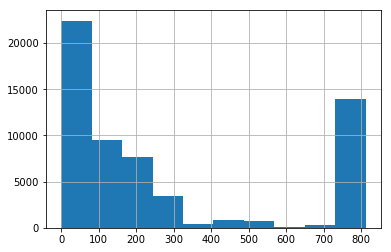

In [1348]:
numerical_INT_df.isnull().sum(axis=1).sort_values().hist()

In [1349]:
drop_movies = numerical_INT_df[numerical_INT_df.isnull().all(axis=1)].index
numerical_INT_df.drop(drop_movies,inplace=True)
drop_movies


Int64Index([ 25817,  26361,  27153,  27433,  31945,  52696,  58209,  60234,
             69834,  70312,
            ...
            191697, 191699, 191899, 191905, 191907, 192397, 192399, 192933,
            193109, 193321],
           dtype='int64', name='movieId', length=3637)

In [1350]:
df = numerical_INT_df.fillna(numerical_INT_df.mean()).copy()

In [1351]:
df_backup = df.copy()

In [1354]:
# df = df.drop(drop_cols, axis=1)

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\sklearn\decomposition\factor_analysis.py:237: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


average log-likelihood of all samples: -1131.9218586224956
number of iterations: 1000
Wall time: 3h 30min 53s


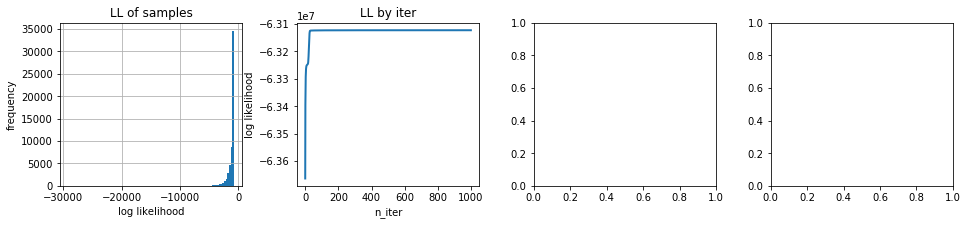

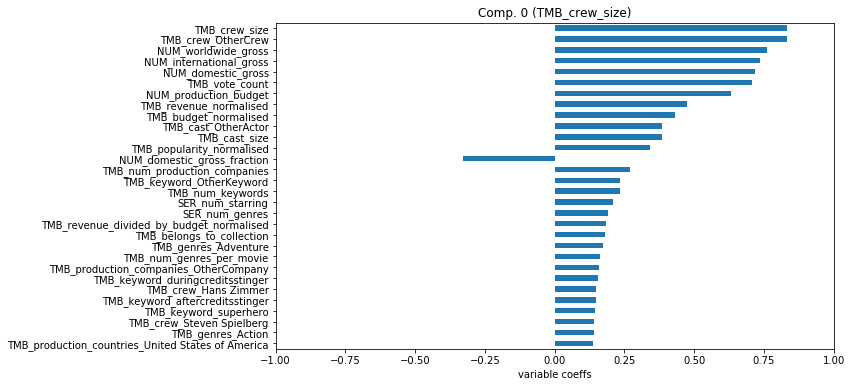

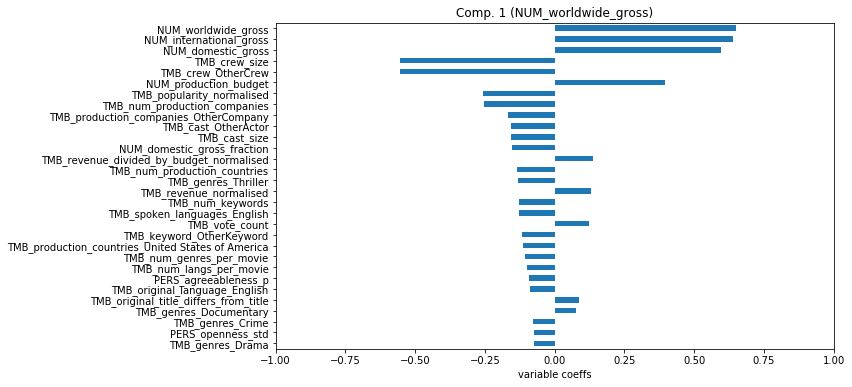

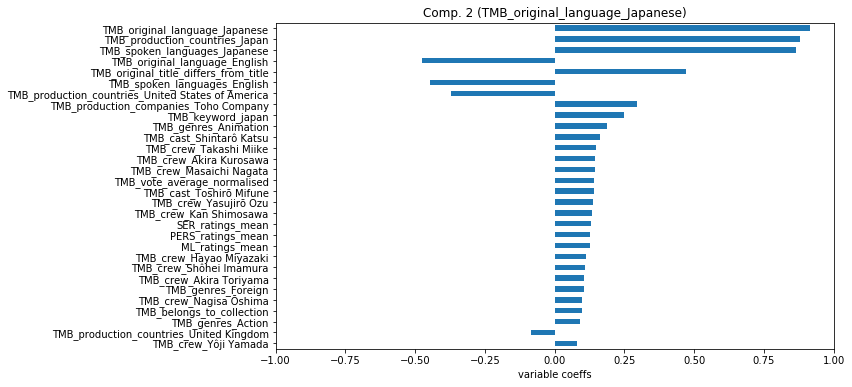

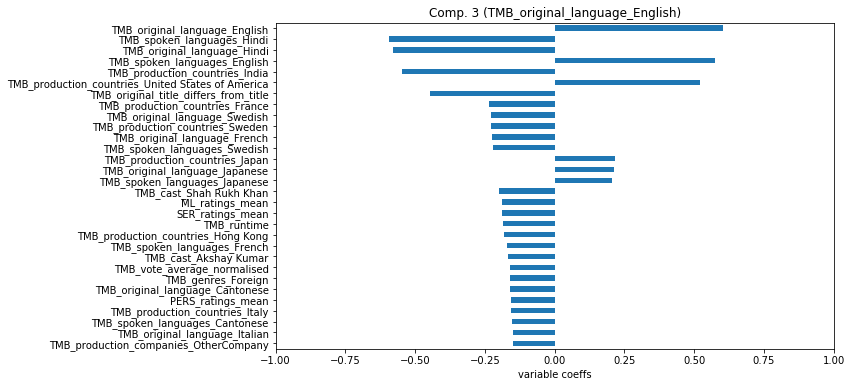

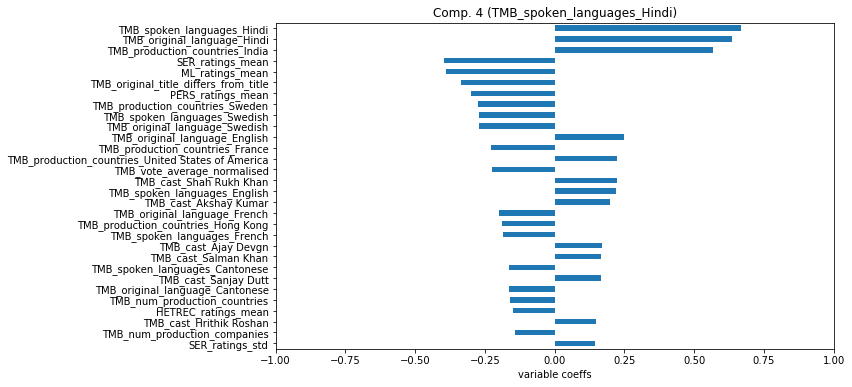

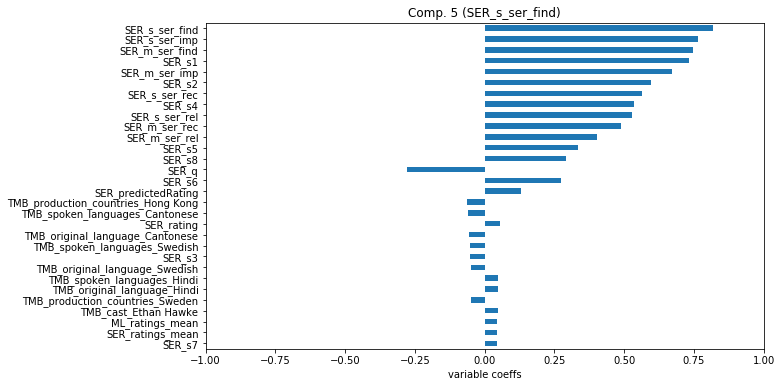

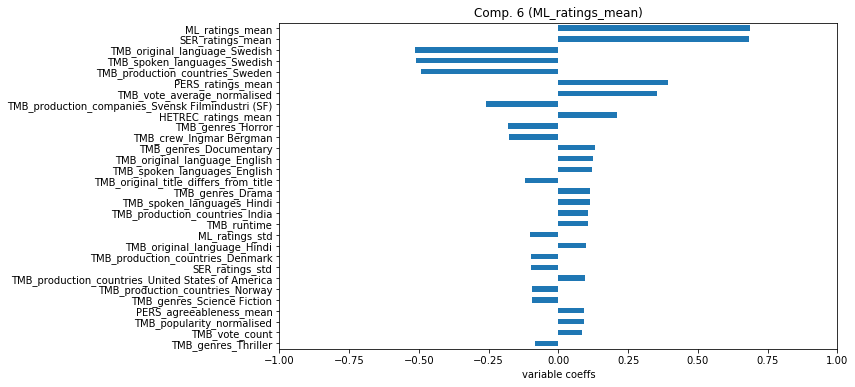

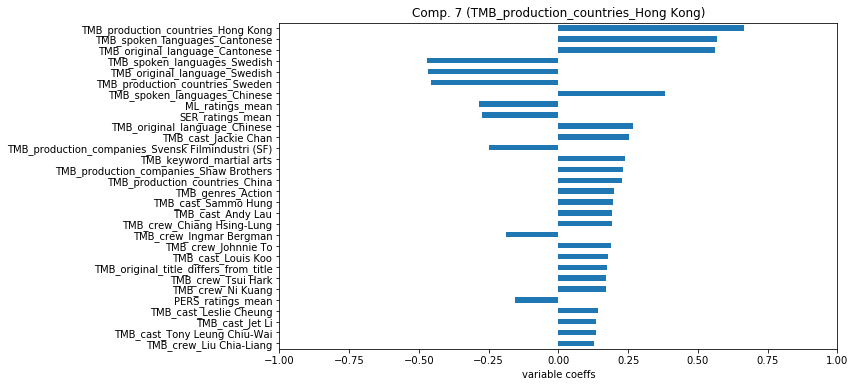

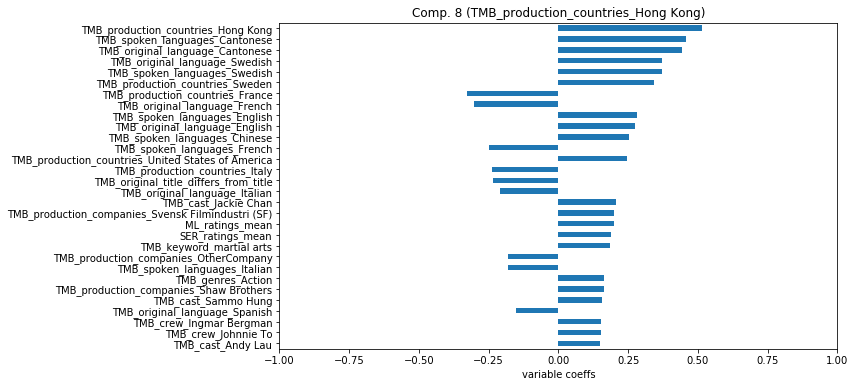

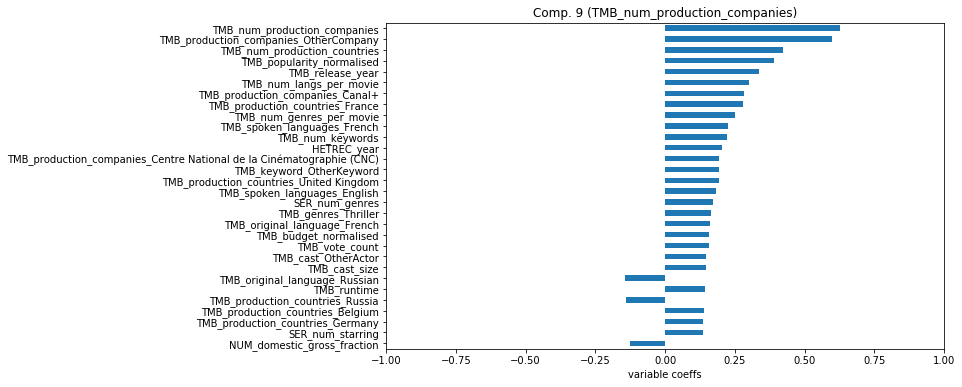

In [1353]:
%%time
output_subfolder = ".."+os.sep+"Output"+os.sep+"INT_dataset_attempt2"
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

    
# Wall time: 3h 30min 53s!!!!
    
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(df.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = df.columns,
                             index   = df.index      )



n_components = BES_std.shape[1]
n_components = 10

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = df.index)



load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
#     if not os.path.exists(subdir): os.makedirs(subdir)
#     with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
#     BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
#     BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
# else: # LOAD decomp results (default is SAVE)
#     decomp_method = load_suff
#     subdir = output_subfolder + os.sep + decomp_method    
#     fname = subdir + os.sep + decomp_method
#     if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
#     # load decomp object, BES_decomp, BES_std, n_components
#     with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
#     BES_decomp = pd.read_hdf(fname+".hdf")
#     BES_std    = pd.read_hdf(fname+"_std"+".hdf")
#     n_components = decomp.components_.shape[0] 

display_pca_data(n_components, decomp, BES_std)



(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          df.columns, BES_decomp, manifest=None, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= n_components, show_histogram = False)

In [943]:
# [x for x in df.columns if re.search("id", x.lower())]

['TMB_revenue_divided_by_budget',
 'TMB_revenue_divided_by_budget_normalised',
 'TMB_collectionId',
 'NUM_worldwide_gross']

In [ ]:
# drop_cols = [""]

In [940]:
# [x for x in df.columns if re.search("normalised", x.lower())]

['TMB_popularity_normalised',
 'TMB_vote_average_normalised',
 'TMB_budget_normalised',
 'TMB_revenue_normalised',
 'TMB_revenue_divided_by_budget_normalised']

In [1355]:
drop_cols = [x for x in float_cols if "_x" in x]
drop_cols = drop_cols + [x for x in float_cols if re.search("movieId|_id|_imdbID|_imdbId|_tmdbId|_movieId",x)]


drop_cols = drop_cols + [x for x in df.columns if re.search("_n$", x.lower())]
drop_cols = drop_cols + ["NUM_scrape_count"]
Id_columns = ["collectionId","original_language"]
unnormalised_columns = ["popularity","vote_average","budget","revenue","revenue_divided_by_budget"]
repeat_cols = ["years_since_first_movie","release_decade"]
drop_cols = drop_cols+ ["TMB_"+x for x in (Id_columns+unnormalised_columns+repeat_cols)]

In [1356]:
drop_cols

['SER_n_x',
 'SER_movieId_x',
 'TMB_movieId',
 'HETREC_id',
 'HETREC_imdbID',
 'SER_movieId_x',
 'SER_imdbId',
 'SER_tmdbId',
 'SER_movieId_y',
 'PERS_movieId',
 'ML_movieId',
 'NUM_movieId',
 'NUM_scrape_count',
 'TMB_collectionId',
 'TMB_original_language',
 'TMB_popularity',
 'TMB_vote_average',
 'TMB_budget',
 'TMB_revenue',
 'TMB_revenue_divided_by_budget',
 'TMB_years_since_first_movie',
 'TMB_release_decade']

noise_variance_
TMB_crew_size                                             0.000056
NUM_worldwide_gross                                       0.000058
TMB_crew_OtherCrew                                        0.001444
NUM_international_gross                                   0.048916
TMB_original_language_Japanese                            0.094468
NUM_domestic_gross                                        0.126913
TMB_production_countries_Japan                            0.155566
TMB_spoken_languages_Hindi                                0.159534
TMB_spoken_languages_Japanese                             0.187581
ML_ratings_mean                                           0.198164
SER_ratings_mean                                          0.206158
TMB_original_language_English                             0.216440
TMB_production_countries_Hong Kong                        0.216880
TMB_original_language_Hindi                               0.222299
TMB_spoken_languages_English                              0.250969
TMB_original_language_Swedish                             0.253359
TMB_spoken_languages_Swedish                              0.253805
TMB_production_countries_Sweden                           0.299745
SER_s_ser_find                                            0.318708
TMB_original_title_differs_from_title                     0.340143
TMB_production_countries_India                            0.352929
SER_s_ser_imp                                             0.403347
TMB_spoken_languages_Cantonese                            0.410045
TMB_num_production_companies                              0.423053
TMB_production_countries_United States of America         0.429240
SER_m_ser_find                                            0.432280
TMB_original_language_Cantonese                           0.432453
NUM_production_budget                                     0.440321
TMB_vote_count                                            0.445623
SER_s1                                                    0.451418
...                                                            ...
TMB_cast_Tallulah Bankhead                                0.999720
TMB_cast_Dirk Bogarde                                     0.999721
TMB_crew_Dinos Dimopoulos                                 0.999722
TMB_crew_Dave Fleischer                                   0.999737
TMB_crew_James Benning                                    0.999740
TMB_crew_Sebastian Junger                                 0.999755
TMB_cast_Ruth Chatterton                                  0.999777
TMB_crew_Eddie Izzard                                     0.999780
TMB_crew_David Carson                                     0.999784
TMB_crew_Patton Oswalt                                    0.999784
TMB_crew_James Moll                                       0.999792
TMB_cast_Şahan Gökbakar                                   0.999792
TMB_cast_Ben Lyon                                         0.999795
TMB_crew_Henry Jaglom                                     0.999795
TMB_cast_Tony Anthony                                     0.999811
TMB_cast_Will Rogers                                      0.999813
TMB_crew_Billy Corben                                     0.999840
TMB_crew_Ralph Thomas                                     0.999845
TMB_crew_Brillante Mendoza                                0.999850
TMB_crew_Guy Maddin                                       0.999851
TMB_crew_Michael Scott                                    0.999852
TMB_crew_Heidi Ewing                                      0.999857
TMB_crew_Neill Fearnley                                   0.999860
TMB_crew_Emile Ardolino                                   0.999863
TMB_crew_Doug Campbell                                    0.999866
TMB_crew_Gary Yates                                       0.999891
TMB_crew_Greg Barker                                      0.999907
TMB_crew_John Gray                                        0.999913
TMB_original_language_Latin    

noise_variance_
HETREC_ratings_mean                           0.906285
HETREC_ratings_std                            0.994579
HETREC_year                                   0.936493
ML_ratings_std                                0.958707
NUM_page_no                                   0.999601
NUM_release_day                               0.999474
NUM_release_month                             0.996356
NUM_release_year                              0.964746
NUM_worldwide_gross_divided_by_budget         0.992857
PERS_agreeableness_mean                       0.972150
PERS_agreeableness_p                          0.974940
PERS_agreeableness_r                          0.999104
PERS_agreeableness_std                        0.978353
PERS_conscientiousness_mean                   0.995922
PERS_conscientiousness_p                      0.987487
PERS_conscientiousness_r                      0.998343
PERS_conscientiousness_std                    0.983263
PERS_emotional_stability_mean                 0.987958
PERS_emotional_stability_p                    0.985834
PERS_emotional_stability_r                    0.998046
PERS_emotional_stability_std                  0.978207
PERS_extraversion_mean                        0.988542
PERS_extraversion_p                           0.989670
PERS_extraversion_r                           0.999489
PERS_extraversion_std                         0.980820
PERS_openness_mean                            0.994415
PERS_openness_p                               0.988842
PERS_openness_r                               0.993458
PERS_openness_std                             0.966351
PERS_ratings_std                              0.977806
...                                                ...
TMB_spoken_languages_Italian                  0.934488
TMB_spoken_languages_Korean                   0.968433
TMB_spoken_languages_Latin                    0.991365
TMB_spoken_languages_Latvian                  0.998993
TMB_spoken_languages_Malayalam                0.992570
TMB_spoken_languages_Marathi                  0.992627
TMB_spoken_languages_No_Language              0.983854
TMB_spoken_languages_Norwegian                0.982943
TMB_spoken_languages_OtherLanguage            0.985472
TMB_spoken_languages_Persian                  0.993419
TMB_spoken_languages_Polish                   0.991325
TMB_spoken_languages_Portuguese               0.991274
TMB_spoken_languages_Romanian                 0.994754
TMB_spoken_languages_Russian                  0.960998
TMB_spoken_languages_Serbian                  0.994050
TMB_spoken_languages_Spanish                  0.977382
TMB_spoken_languages_Tagalog                  0.999244
TMB_spoken_languages_Tamil                    0.975799
TMB_spoken_languages_Telugu                   0.987868
TMB_spoken_languages_Thai                     0.991463
TMB_spoken_languages_Turkish                  0.991927
TMB_spoken_languages_Ukrainian                0.998111
TMB_spoken_languages_Urdu                     0.988040
TMB_spoken_languages_Vietnamese               0.998156
TMB_spoken_languages_Yiddish                  0.997969
TMB_status_released                           0.998062
TMB_tagline_length                            0.981365
TMB_title_used_by_num_other_movies            0.997839
TMB_tv_not_film                               0.996503
TMB_video                                     0.999200

[747 rows x 1 columns]

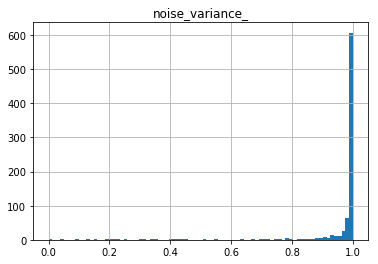

In [1357]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
        display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

In [ ]:
##########################################

In [957]:
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ), q=10 ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ), q=10 ).cat.codes )
          
            

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)            
    
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False ):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(BES_output_folder,"xgb_census"+Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves)

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values)
    

In [960]:
Treatment = "xgboost_INT"


# ImmigDiff = get_diff(["likeCorbyn"])#.notnull().sum()

# var_list = ImmigDiff.columns

# ["profile_education_age","workingStatus","profile_work_stat",]

optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return 1



def create_train(drop_other_waves):
    keep_list = df.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return df[keep_list]


def create_target(target_var):
    
    return df[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 508,
 max_depth=6,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=5e-05,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)



In [1390]:
drop_cols = [x for x in float_cols if "_x" in x]
drop_cols = drop_cols + [x for x in float_cols if re.search("_n$", x.lower())]
drop_cols = drop_cols + [x for x in float_cols if re.search("movieId|_id|_imdbID|_imdbId|_tmdbId|_movieId",x)]


drop_cols = drop_cols + [x for x in df.columns if re.search("_n$", x.lower())]
drop_cols = drop_cols + ["NUM_scrape_count"]
Id_columns = ["collectionId","original_language"]
unnormalised_columns = ["popularity","vote_average","budget","revenue","revenue_divided_by_budget"]
repeat_cols = ["years_since_first_movie","release_decade"]
drop_cols = drop_cols+ ["TMB_"+x for x in (Id_columns+unnormalised_columns+repeat_cols)]

In [1391]:
drop_cols = drop_cols+["TMB_revenue_normalised","TMB_budget_normalised",
                       "NUM_worldwide_gross_divided_by_budget","NUM_production_budget","NUM_worldwide_gross",
                       "NUM_domestic_gross","NUM_international_gross","TMB_vote_count",
                       "NUM_page_no"]

drop_cols = drop_cols+ [x for x in df.columns if "Other" in x]

[0]	validation_0-rmse:1.10478
Will train until validation_0-rmse hasn't improved in 9.3 rounds.
[1]	validation_0-rmse:1.08473
[2]	validation_0-rmse:1.06575
[3]	validation_0-rmse:1.04811
[4]	validation_0-rmse:1.03475
[5]	validation_0-rmse:1.01856
[6]	validation_0-rmse:1.00409
[7]	validation_0-rmse:0.99077
[8]	validation_0-rmse:0.97915
[9]	validation_0-rmse:0.96878
[10]	validation_0-rmse:0.957745
[11]	validation_0-rmse:0.947739
[12]	validation_0-rmse:0.93846
[13]	validation_0-rmse:0.930448
[14]	validation_0-rmse:0.923201
[15]	validation_0-rmse:0.915072
[16]	validation_0-rmse:0.910255
[17]	validation_0-rmse:0.903983
[18]	validation_0-rmse:0.898076
[19]	validation_0-rmse:0.891492
[20]	validation_0-rmse:0.886496
[21]	validation_0-rmse:0.880704
[22]	validation_0-rmse:0.877369
[23]	validation_0-rmse:0.872897
[24]	validation_0-rmse:0.869228
[25]	validation_0-rmse:0.865161
[26]	validation_0-rmse:0.862338
[27]	validation_0-rmse:0.859361
[28]	validation_0-rmse:0.856843
[29]	validation_0-rmse:0.85

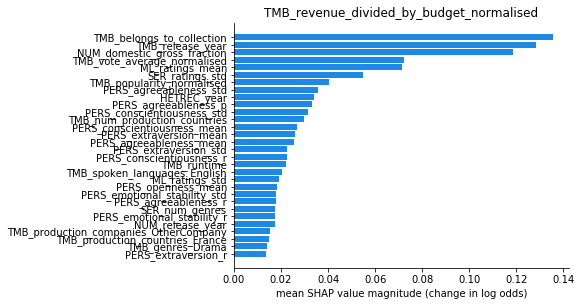

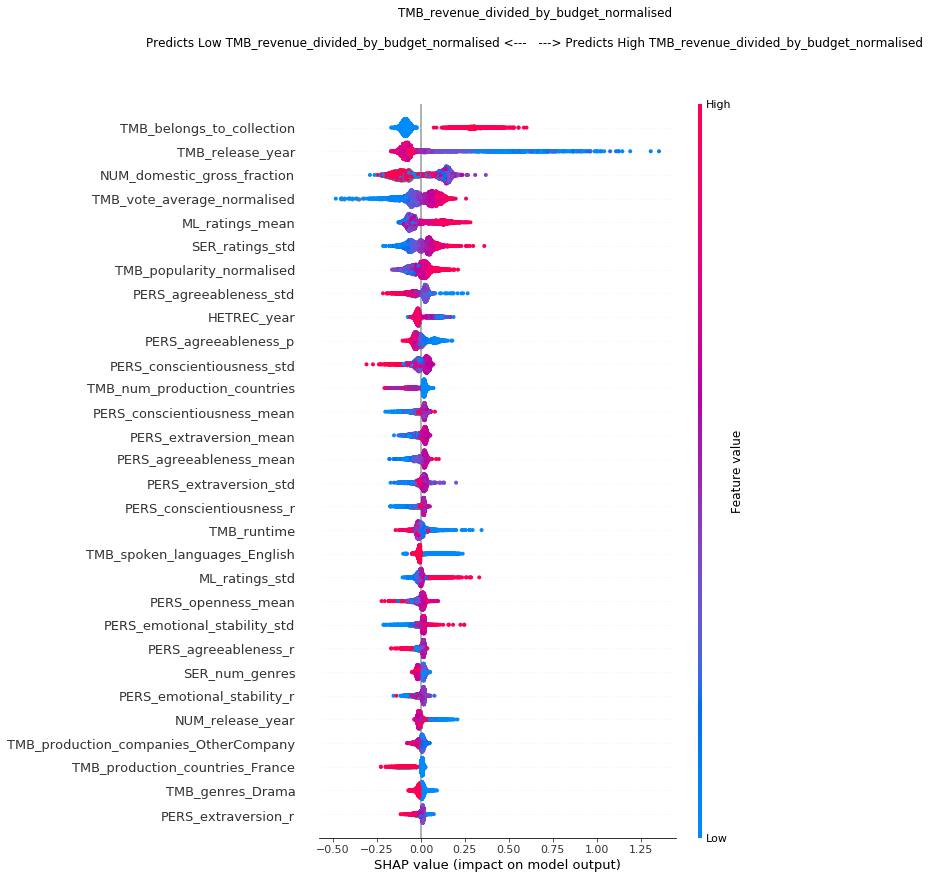

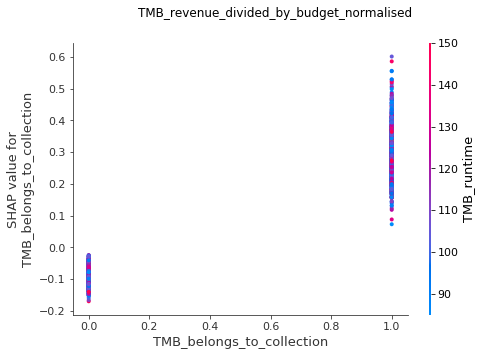

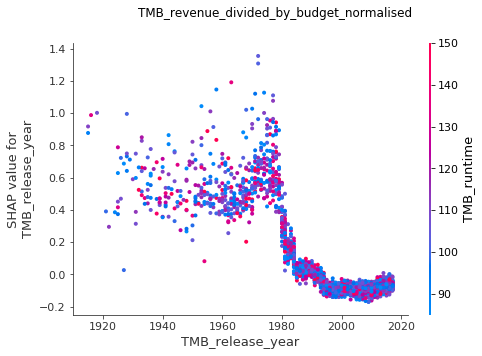

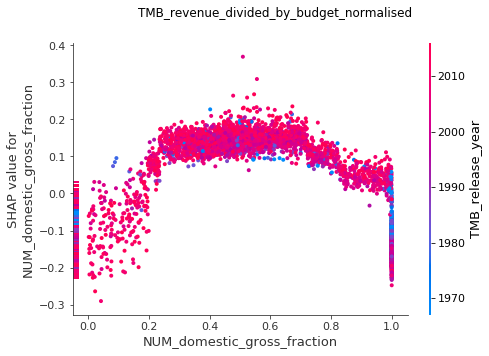

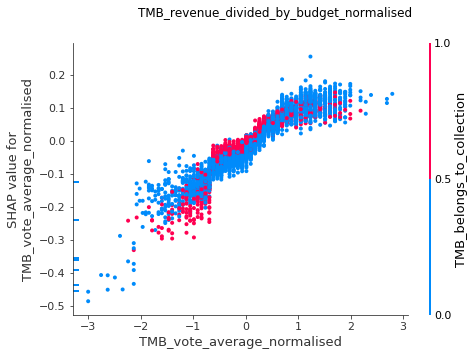

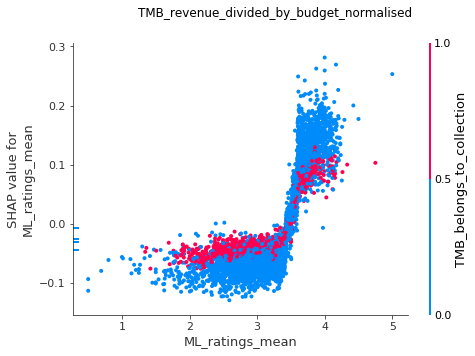

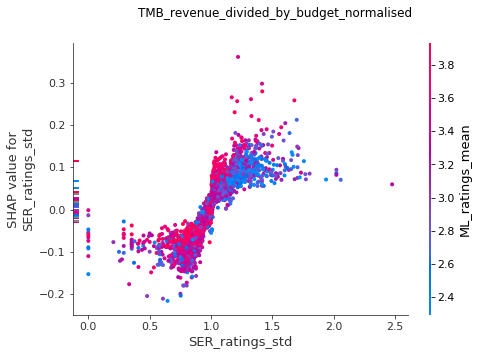

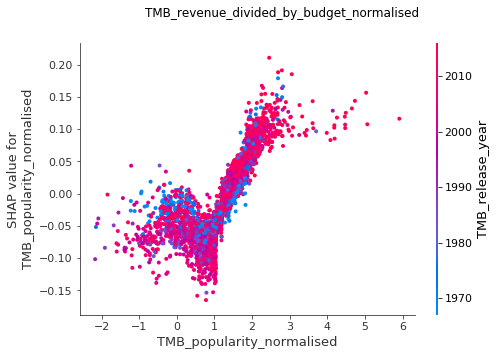

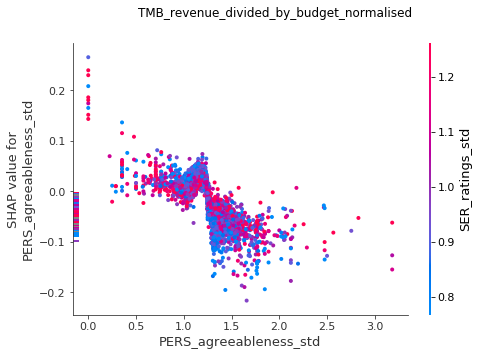

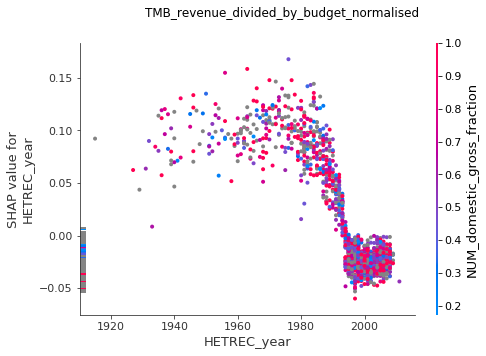

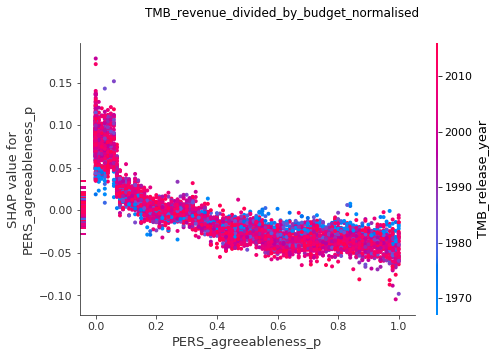

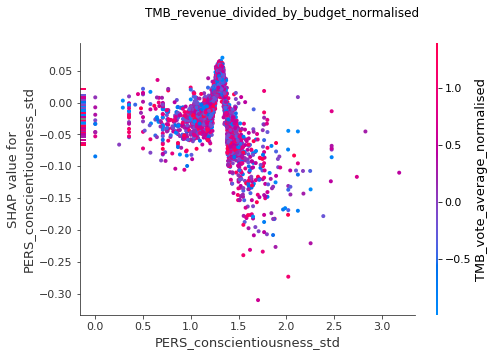

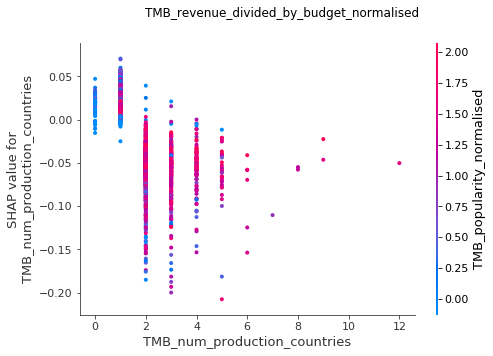

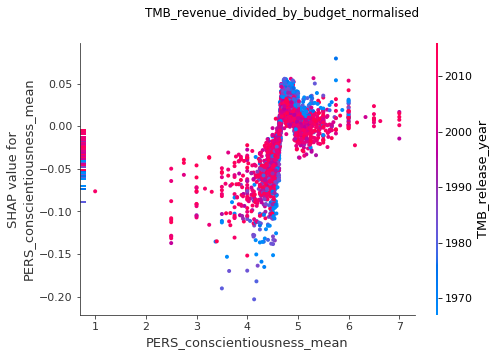

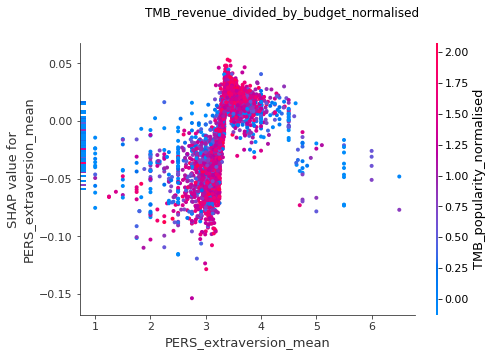

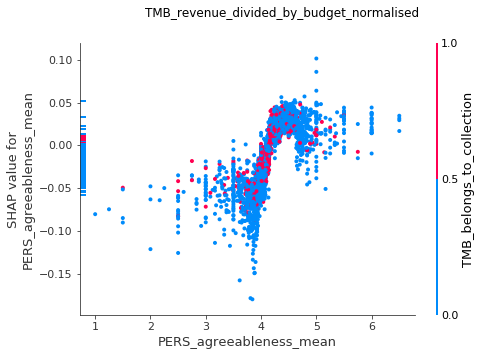

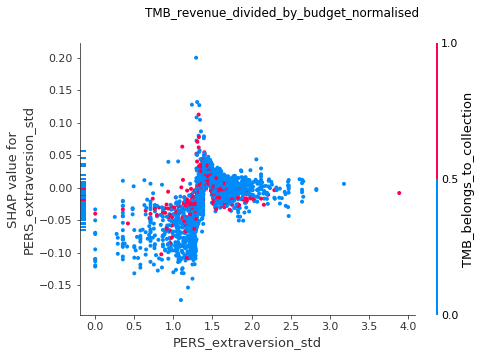

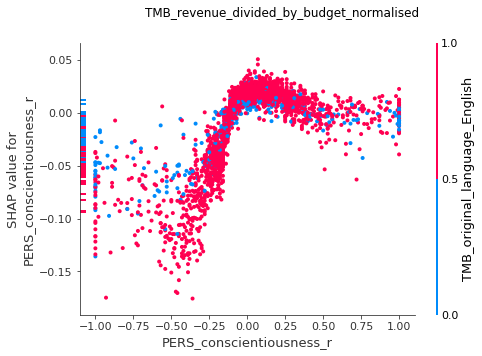

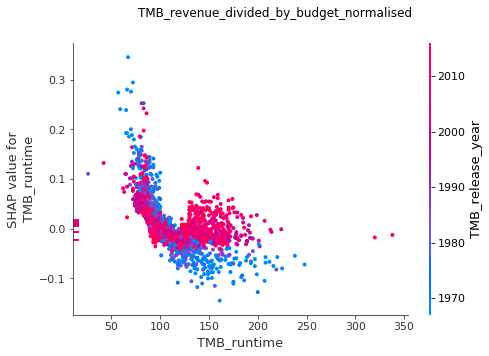

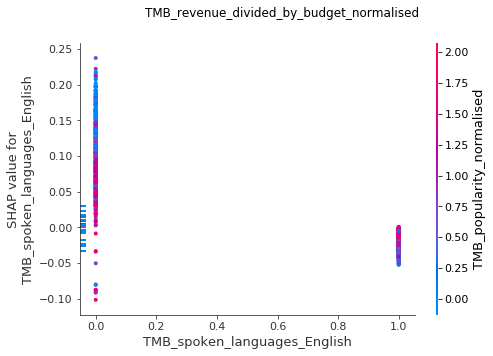

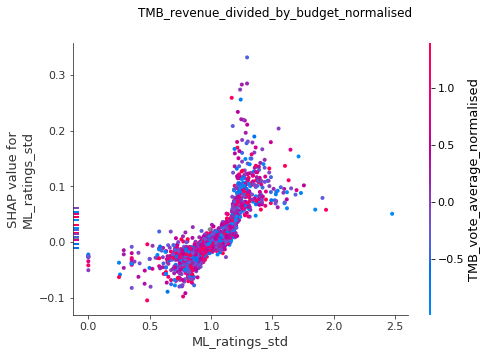

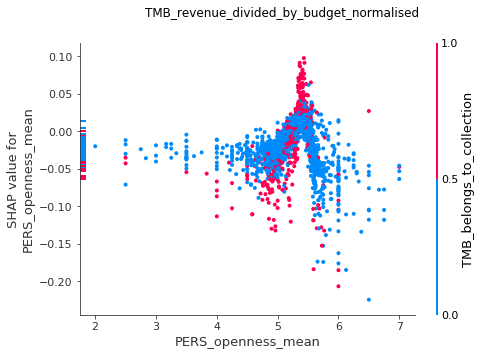

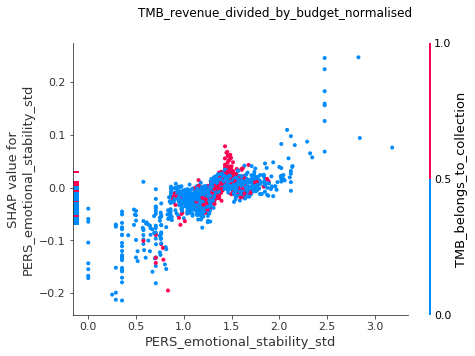

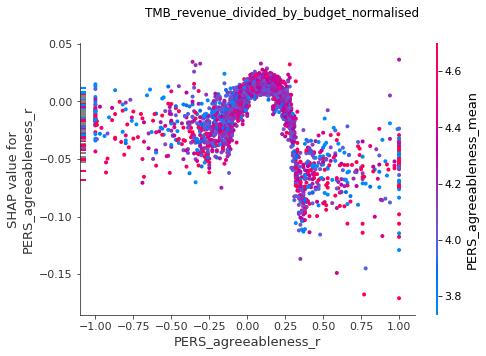

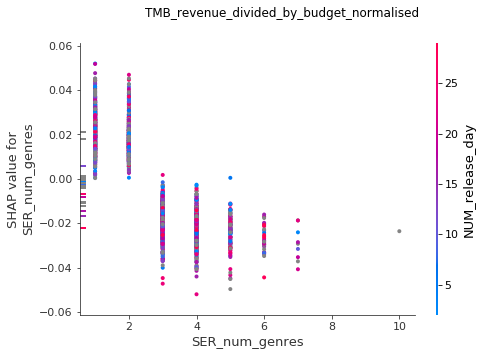

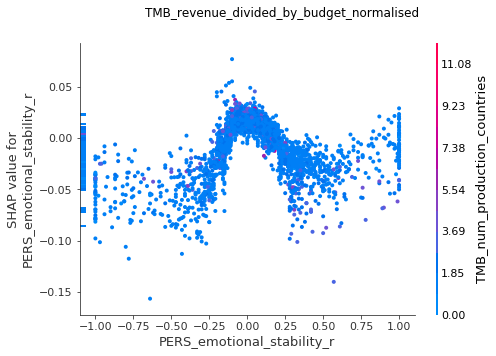

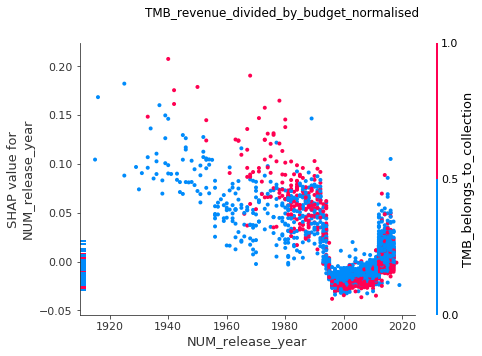

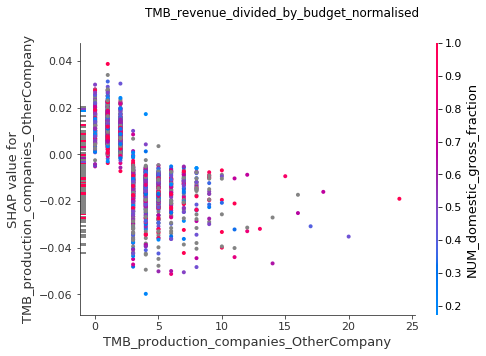

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


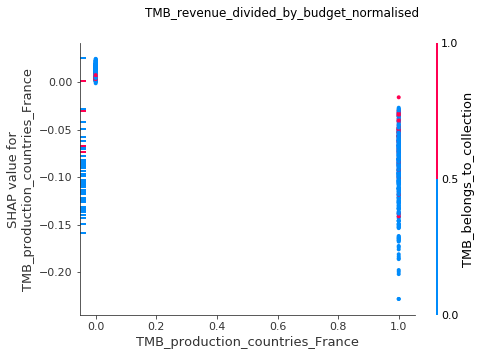

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


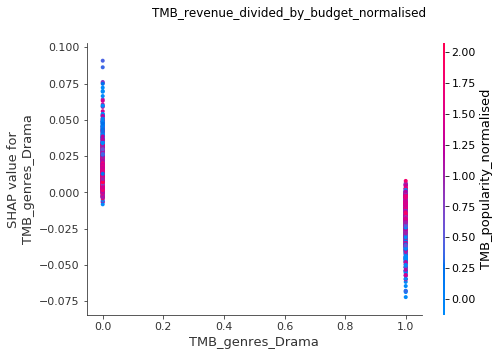

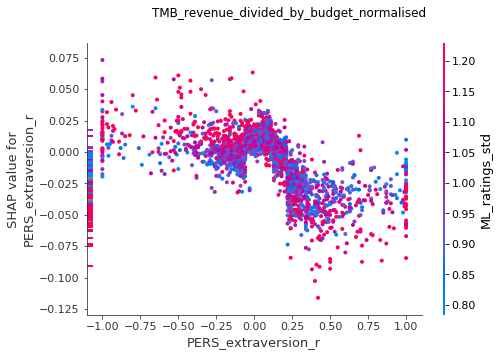

Wall time: 6min 52s


In [1392]:
%%time

BES_output_folder= ".."+os.sep+"Output"+os.sep

df = INT_df[float_cols].drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)

var_name = "TMB_revenue_divided_by_budget_normalised"

mask = df[var_name].notnull()
# df.drop(["TMB_revenue_normalised","TMB_budget_normalised"],inplace=True)
df = df[mask].copy()

colname = var_name

var_stub = var_name

var_list = [var_name]
var_stub_list = [var_stub]

# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,30),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True)

In [1398]:
df = df.apply(lambda x: np.nan if x is None else x)

In [1401]:
%%time

target = df[var_name]
train =df.drop(var_name,axis=1)
### xgboost_tuner
# https://github.com/Jie-Yuan/xgboost-tuner

from xgboost_tuner.tuner import tune_xgb_params

# train = X.values
# label = rounded_targets

# metric_sklearn = ‘neg_mean_squared_error’ or 'remse'
# estimator_cls = xgb.XGBClassifier, xgb.XGBRegressor


# Tune the parameters incrementally and limit the range for colsample_bytree and subsample
best_params, history = tune_xgb_params(
    cv_folds = 3,
    label = target,
    metric_sklearn = 'neg_mean_squared_error',
    metric_xgb = "rmse",
    n_jobs = 3,
    objective = 'reg:linear',
    random_state = seed,
    strategy = 'incremental',
    train = train,
    init_colsample_bytree = 0.9,
    init_gamma = 0.0,
    init_max_depth = 7,
    init_min_child_weight  = 6,
    init_subsample = 0.6,
    learning_rates = [.05]
)



[21:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[21:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[21:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[0]	train-rmse:1.0834+0.0342426	test-rmse:1.0887+0.0665014
[21:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=7
[21:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=7
[21:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[1]	train-rmse:1.05269+0.0328131	test-rmse:1.06688+0.0619202
[21:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[21:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pr

[21:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[40]	train-rmse:0.592391+0.0187443	test-rmse:0.842902+0.0545516
[21:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[21:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[21:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[41]	train-rmse:0.58758+0.0184636	test-rmse:0.841428+0.055264
[21:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[21:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[21:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[42]	train-rmse:0.582482+0.0180233	test-rmse:0.840963+0.0555457
[21:06:18] src/tree/u

[21:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[21:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[21:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[61]	train-rmse:0.511192+0.0190836	test-rmse:0.835245+0.0615065
[21:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[21:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[21:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[62]	train-rmse:0.508063+0.0192254	test-rmse:0.83494+0.0613868
[21:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[21:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pr

[21:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[101]	train-rmse:0.416376+0.0188956	test-rmse:0.828578+0.0653913
[21:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[21:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[21:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[102]	train-rmse:0.414716+0.0186094	test-rmse:0.828434+0.0651922
[21:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[21:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[21:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[103]	train-rmse:0.411879+0.0179844	test-rmse:0.828379+0.0654706
[21:06:34] src/tre

[21:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[21:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[21:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[122]	train-rmse:0.377209+0.017222	test-rmse:0.827545+0.0661951
[21:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[21:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[21:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[123]	train-rmse:0.37542+0.0172679	test-rmse:0.827639+0.065736
[21:06:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[21:06:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pru

[21:06:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[162]	train-rmse:0.317076+0.0114016	test-rmse:0.825996+0.0673922
[21:06:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[21:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[21:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[163]	train-rmse:0.315894+0.0108023	test-rmse:0.825989+0.0677752
[21:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[21:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[21:06:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[164]	train-rmse:0.314613+0.0108655	test-rmse:0.825979+0.0675669
[21:06:50] src/tree/u

[21:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[21:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[21:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=7
[183]	train-rmse:0.290586+0.0104122	test-rmse:0.825699+0.0682586
[21:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[21:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[21:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[184]	train-rmse:0.289577+0.0105149	test-rmse:0.825726+0.0681858
[21:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[21:06:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 

[21:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[223]	train-rmse:0.246516+0.0122653	test-rmse:0.824906+0.0675838
[21:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[21:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[21:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[224]	train-rmse:0.245693+0.0120152	test-rmse:0.824924+0.0675578
[21:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[21:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[21:07:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[225]	train-rmse:0.244344+0.012121	test-rmse:0.824837+0.0675126
[21:07:06] src/tree

[21:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[21:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[21:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[244]	train-rmse:0.224723+0.0118622	test-rmse:0.824594+0.0682517
[21:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[21:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[21:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[245]	train-rmse:0.224243+0.0117498	test-rmse:0.824713+0.0682324
[21:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[21:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 

[21:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[284]	train-rmse:0.191565+0.0106945	test-rmse:0.824974+0.0677577
[21:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[21:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[21:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[285]	train-rmse:0.190681+0.0103606	test-rmse:0.82491+0.0676554
[21:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[21:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[21:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    2.5s


XGBoostError: Invalid Parameter format for verbosity expect int but value='None'

In [1405]:
%%time
X_train, X_test, y_train, y_test = train_test_split( train,
                                                     target, test_size=test_size,
                                                     random_state=seed,
                                                     stratify=pd.qcut( pd.Series( target ), q=10 ).cat.codes )

eval_set = [(X_test, y_test)]

param_test1 ={
 'min_child_weight':[5,7],
 'learning_rate':[0.045,0.055],
 'subsample':[.75,.85],
 'max_depth':[5,7],
 'gamma':[0],
 'reg_alpha':[5e-05],
 'reg_lambda':[1],
 'colsample_bytree':[0.55,.65],
 'scale_pos_weight': [1],
 'n_estimators': [508],
}

# {'colsample_bytree': 0.7,
#  'gamma': 0.30000000000000004,
#  'learning_rate': 0.06,
#  'max_depth': 10,
#  'min_child_weight': 5,
#  'nthread': 4,
#  'objective': 'reg:linear',
#  'scale_pos_weight': 1,
#  'subsample': 0.6,
#  'random_state': 27,
#  'n_estimators': 1733,
#  'reg_alpha': 0.01,
#  'reg_lambda': 1}

from sklearn.model_selection import StratifiedKFold, KFold
skf = StratifiedKFold(n_splits=3)
skf = KFold(n_splits=3)

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 508,
 max_depth=6,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=5e-05,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)



gsearch1 = GridSearchCV(estimator = alg,
                        param_grid = param_test1,
                        scoring='r2', #'r2'
                        n_jobs=1, 
                        iid=False,
                        cv=skf,
                        verbose=True)

gsearch1.fit(X_train, y_train, eval_metric='rmse',
        early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
        verbose=True)

display(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0]	validation_0-rmse:1.11099
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:1.09169
[2]	validation_0-rmse:1.07526
[3]	validation_0-rmse:1.06279
[4]	validation_0-rmse:1.04881
[5]	validation_0-rmse:1.03569
[6]	validation_0-rmse:1.02238
[7]	validation_0-rmse:1.01044
[8]	validation_0-rmse:0.998583
[9]	validation_0-rmse:0.987692
[10]	validation_0-rmse:0.979627
[11]	validation_0-rmse:0.972371
[12]	validation_0-rmse:0.96404
[13]	validation_0-rmse:0.955711
[14]	validation_0-rmse:0.948491
[15]	validation_0-rmse:0.941843
[16]	validation_0-rmse:0.935403
[17]	validation_0-rmse:0.928098
[18]	validation_0-rmse:0.922959
[19]	validation_0-rmse:0.916738
[20]	validation_0-rmse:0.910265
[21]	validation_0-rmse:0.904655
[22]	validation_0-rmse:0.901236
[23]	validation_0-rmse:0.895888
[24]	validation_0-rmse:0.892093
[25]	validation_0-rmse:0.888693
[26]	validation_0-rmse:0.885286
[27]	validation_0-rmse:0.881484
[28]	validation_0-rmse:0.87933
[29]	valida

[251]	validation_0-rmse:0.796652
[252]	validation_0-rmse:0.796755
[253]	validation_0-rmse:0.796893
[254]	validation_0-rmse:0.797032
[255]	validation_0-rmse:0.796928
[256]	validation_0-rmse:0.797072
[257]	validation_0-rmse:0.796978
[258]	validation_0-rmse:0.797068
[259]	validation_0-rmse:0.797002
[260]	validation_0-rmse:0.796823
[261]	validation_0-rmse:0.796643
[262]	validation_0-rmse:0.796442
[263]	validation_0-rmse:0.796423
[264]	validation_0-rmse:0.796323
[265]	validation_0-rmse:0.796467
[266]	validation_0-rmse:0.796627
[267]	validation_0-rmse:0.796535
[268]	validation_0-rmse:0.796533
[269]	validation_0-rmse:0.796374
[270]	validation_0-rmse:0.79614
[271]	validation_0-rmse:0.796161
[272]	validation_0-rmse:0.796224
[273]	validation_0-rmse:0.796164
[274]	validation_0-rmse:0.795936
[275]	validation_0-rmse:0.795948
[276]	validation_0-rmse:0.79591
[277]	validation_0-rmse:0.795971
[278]	validation_0-rmse:0.795885
[279]	validation_0-rmse:0.795785
[280]	validation_0-rmse:0.795887
[281]	valida

Stopping. Best iteration:
[449]	validation_0-rmse:0.794209

[0]	validation_0-rmse:1.10671
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:1.0912
[2]	validation_0-rmse:1.07717
[3]	validation_0-rmse:1.06384
[4]	validation_0-rmse:1.05003
[5]	validation_0-rmse:1.03411
[6]	validation_0-rmse:1.02043
[7]	validation_0-rmse:1.00898
[8]	validation_0-rmse:0.999692
[9]	validation_0-rmse:0.990887
[10]	validation_0-rmse:0.98125
[11]	validation_0-rmse:0.972654
[12]	validation_0-rmse:0.963047
[13]	validation_0-rmse:0.956582
[14]	validation_0-rmse:0.950051
[15]	validation_0-rmse:0.942965
[16]	validation_0-rmse:0.937899
[17]	validation_0-rmse:0.93227
[18]	validation_0-rmse:0.926152
[19]	validation_0-rmse:0.921131
[20]	validation_0-rmse:0.915629
[21]	validation_0-rmse:0.91026
[22]	validation_0-rmse:0.905234
[23]	validation_0-rmse:0.901701
[24]	validation_0-rmse:0.898312
[25]	validation_0-rmse:0.894628
[26]	validation_0-rmse:0.891135
[27]	validation_0

[249]	validation_0-rmse:0.803871
[250]	validation_0-rmse:0.803784
[251]	validation_0-rmse:0.803627
[252]	validation_0-rmse:0.803779
[253]	validation_0-rmse:0.803779
[254]	validation_0-rmse:0.803859
[255]	validation_0-rmse:0.803794
[256]	validation_0-rmse:0.803812
[257]	validation_0-rmse:0.803687
[258]	validation_0-rmse:0.803618
[259]	validation_0-rmse:0.803414
[260]	validation_0-rmse:0.803505
[261]	validation_0-rmse:0.803409
[262]	validation_0-rmse:0.803372
[263]	validation_0-rmse:0.803398
[264]	validation_0-rmse:0.803458
[265]	validation_0-rmse:0.803397
[266]	validation_0-rmse:0.803233
[267]	validation_0-rmse:0.803157
[268]	validation_0-rmse:0.803081
[269]	validation_0-rmse:0.802975
[270]	validation_0-rmse:0.803169
[271]	validation_0-rmse:0.803
[272]	validation_0-rmse:0.803091
[273]	validation_0-rmse:0.803135
[274]	validation_0-rmse:0.803063
[275]	validation_0-rmse:0.802862
[276]	validation_0-rmse:0.802762
[277]	validation_0-rmse:0.802745
[278]	validation_0-rmse:0.802819
[279]	validat

[498]	validation_0-rmse:0.799252
[499]	validation_0-rmse:0.799307
[500]	validation_0-rmse:0.799204
[501]	validation_0-rmse:0.799319
[502]	validation_0-rmse:0.799314
[503]	validation_0-rmse:0.799341
[504]	validation_0-rmse:0.799269
[505]	validation_0-rmse:0.799268
[506]	validation_0-rmse:0.799377
[507]	validation_0-rmse:0.799377
[0]	validation_0-rmse:1.10811
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:1.09173
[2]	validation_0-rmse:1.07657
[3]	validation_0-rmse:1.06307
[4]	validation_0-rmse:1.0494
[5]	validation_0-rmse:1.03427
[6]	validation_0-rmse:1.02009
[7]	validation_0-rmse:1.00883
[8]	validation_0-rmse:0.999922
[9]	validation_0-rmse:0.991184
[10]	validation_0-rmse:0.981547
[11]	validation_0-rmse:0.972902
[12]	validation_0-rmse:0.963808
[13]	validation_0-rmse:0.956769
[14]	validation_0-rmse:0.951764
[15]	validation_0-rmse:0.944511
[16]	validation_0-rmse:0.939255
[17]	validation_0-rmse:0.933102
[18]	validation_0-rmse:0.926981


[240]	validation_0-rmse:0.793088
[241]	validation_0-rmse:0.793092
[242]	validation_0-rmse:0.792904
[243]	validation_0-rmse:0.792689
[244]	validation_0-rmse:0.79268
[245]	validation_0-rmse:0.792701
[246]	validation_0-rmse:0.792745
[247]	validation_0-rmse:0.792623
[248]	validation_0-rmse:0.792347
[249]	validation_0-rmse:0.792493
[250]	validation_0-rmse:0.792405
[251]	validation_0-rmse:0.792141
[252]	validation_0-rmse:0.792022
[253]	validation_0-rmse:0.791967
[254]	validation_0-rmse:0.791924
[255]	validation_0-rmse:0.791796
[256]	validation_0-rmse:0.79172
[257]	validation_0-rmse:0.791698
[258]	validation_0-rmse:0.791647
[259]	validation_0-rmse:0.791729
[260]	validation_0-rmse:0.791822
[261]	validation_0-rmse:0.791854
[262]	validation_0-rmse:0.791779
[263]	validation_0-rmse:0.791754
[264]	validation_0-rmse:0.791778
[265]	validation_0-rmse:0.791786
[266]	validation_0-rmse:0.791597
[267]	validation_0-rmse:0.791521
[268]	validation_0-rmse:0.791537
[269]	validation_0-rmse:0.791653
[270]	valida

[106]	validation_0-rmse:0.81348
[107]	validation_0-rmse:0.813287
[108]	validation_0-rmse:0.813235
[109]	validation_0-rmse:0.813022
[110]	validation_0-rmse:0.812963
[111]	validation_0-rmse:0.812995
[112]	validation_0-rmse:0.812691
[113]	validation_0-rmse:0.812468
[114]	validation_0-rmse:0.812536
[115]	validation_0-rmse:0.812263
[116]	validation_0-rmse:0.811391
[117]	validation_0-rmse:0.811248
[118]	validation_0-rmse:0.810723
[119]	validation_0-rmse:0.810525
[120]	validation_0-rmse:0.810352
[121]	validation_0-rmse:0.810246
[122]	validation_0-rmse:0.810083
[123]	validation_0-rmse:0.810032
[124]	validation_0-rmse:0.809888
[125]	validation_0-rmse:0.809372
[126]	validation_0-rmse:0.809232
[127]	validation_0-rmse:0.808738
[128]	validation_0-rmse:0.808536
[129]	validation_0-rmse:0.808036
[130]	validation_0-rmse:0.807737
[131]	validation_0-rmse:0.807673
[132]	validation_0-rmse:0.807571
[133]	validation_0-rmse:0.80721
[134]	validation_0-rmse:0.80739
[135]	validation_0-rmse:0.807209
[136]	validat

[355]	validation_0-rmse:0.795143
[356]	validation_0-rmse:0.79525
[357]	validation_0-rmse:0.795285
[358]	validation_0-rmse:0.795305
[359]	validation_0-rmse:0.795111
[360]	validation_0-rmse:0.795155
[361]	validation_0-rmse:0.795182
[362]	validation_0-rmse:0.795241
[363]	validation_0-rmse:0.795405
[364]	validation_0-rmse:0.795234
[365]	validation_0-rmse:0.795127
[366]	validation_0-rmse:0.794998
[367]	validation_0-rmse:0.795044
[368]	validation_0-rmse:0.795075
[369]	validation_0-rmse:0.794981
[370]	validation_0-rmse:0.794969
[371]	validation_0-rmse:0.794917
[372]	validation_0-rmse:0.794977
[373]	validation_0-rmse:0.795014
[374]	validation_0-rmse:0.794967
[375]	validation_0-rmse:0.795241
[376]	validation_0-rmse:0.795152
[377]	validation_0-rmse:0.795161
[378]	validation_0-rmse:0.795129
[379]	validation_0-rmse:0.795184
[380]	validation_0-rmse:0.79516
[381]	validation_0-rmse:0.795177
[382]	validation_0-rmse:0.795086
[383]	validation_0-rmse:0.795008
[384]	validation_0-rmse:0.794923
[385]	valida

[217]	validation_0-rmse:0.810564
[218]	validation_0-rmse:0.810644
[219]	validation_0-rmse:0.810751
[220]	validation_0-rmse:0.810825
[221]	validation_0-rmse:0.810638
[222]	validation_0-rmse:0.810632
[223]	validation_0-rmse:0.810809
[224]	validation_0-rmse:0.810644
[225]	validation_0-rmse:0.8105
[226]	validation_0-rmse:0.810505
[227]	validation_0-rmse:0.810511
[228]	validation_0-rmse:0.810529
[229]	validation_0-rmse:0.810364
[230]	validation_0-rmse:0.810214
[231]	validation_0-rmse:0.81017
[232]	validation_0-rmse:0.810212
[233]	validation_0-rmse:0.81024
[234]	validation_0-rmse:0.809917
[235]	validation_0-rmse:0.809912
[236]	validation_0-rmse:0.810066
[237]	validation_0-rmse:0.809882
[238]	validation_0-rmse:0.809787
[239]	validation_0-rmse:0.809675
[240]	validation_0-rmse:0.809569
[241]	validation_0-rmse:0.809551
[242]	validation_0-rmse:0.809644
[243]	validation_0-rmse:0.809593
[244]	validation_0-rmse:0.809502
[245]	validation_0-rmse:0.809343
[246]	validation_0-rmse:0.809325
[247]	validati

[39]	validation_0-rmse:0.855001
[40]	validation_0-rmse:0.853177
[41]	validation_0-rmse:0.850888
[42]	validation_0-rmse:0.849213
[43]	validation_0-rmse:0.847023
[44]	validation_0-rmse:0.845794
[45]	validation_0-rmse:0.844706
[46]	validation_0-rmse:0.843526
[47]	validation_0-rmse:0.842616
[48]	validation_0-rmse:0.841325
[49]	validation_0-rmse:0.839408
[50]	validation_0-rmse:0.8382
[51]	validation_0-rmse:0.837496
[52]	validation_0-rmse:0.836618
[53]	validation_0-rmse:0.835069
[54]	validation_0-rmse:0.834685
[55]	validation_0-rmse:0.834087
[56]	validation_0-rmse:0.833041
[57]	validation_0-rmse:0.831493
[58]	validation_0-rmse:0.830389
[59]	validation_0-rmse:0.829586
[60]	validation_0-rmse:0.828654
[61]	validation_0-rmse:0.827752
[62]	validation_0-rmse:0.827213
[63]	validation_0-rmse:0.826853
[64]	validation_0-rmse:0.825689
[65]	validation_0-rmse:0.824803
[66]	validation_0-rmse:0.824724
[67]	validation_0-rmse:0.824426
[68]	validation_0-rmse:0.823737
[69]	validation_0-rmse:0.823035
[70]	valid

[290]	validation_0-rmse:0.794221
[291]	validation_0-rmse:0.794233
[292]	validation_0-rmse:0.794202
[293]	validation_0-rmse:0.794268
[294]	validation_0-rmse:0.794257
[295]	validation_0-rmse:0.79423
[296]	validation_0-rmse:0.794289
[297]	validation_0-rmse:0.794256
[298]	validation_0-rmse:0.794102
[299]	validation_0-rmse:0.794098
[300]	validation_0-rmse:0.793999
[301]	validation_0-rmse:0.794051
[302]	validation_0-rmse:0.794231
[303]	validation_0-rmse:0.794223
[304]	validation_0-rmse:0.794209
[305]	validation_0-rmse:0.79419
[306]	validation_0-rmse:0.794057
[307]	validation_0-rmse:0.793957
[308]	validation_0-rmse:0.793923
[309]	validation_0-rmse:0.793879
[310]	validation_0-rmse:0.793878
[311]	validation_0-rmse:0.793689
[312]	validation_0-rmse:0.793569
[313]	validation_0-rmse:0.79357
[314]	validation_0-rmse:0.793591
[315]	validation_0-rmse:0.793464
[316]	validation_0-rmse:0.793417
[317]	validation_0-rmse:0.793417
[318]	validation_0-rmse:0.793387
[319]	validation_0-rmse:0.793328
[320]	validat

[30]	validation_0-rmse:0.87297
[31]	validation_0-rmse:0.869885
[32]	validation_0-rmse:0.867559
[33]	validation_0-rmse:0.866153
[34]	validation_0-rmse:0.863329
[35]	validation_0-rmse:0.860388
[36]	validation_0-rmse:0.858669
[37]	validation_0-rmse:0.857082
[38]	validation_0-rmse:0.855574
[39]	validation_0-rmse:0.854794
[40]	validation_0-rmse:0.852159
[41]	validation_0-rmse:0.850488
[42]	validation_0-rmse:0.848477
[43]	validation_0-rmse:0.846607
[44]	validation_0-rmse:0.845511
[45]	validation_0-rmse:0.844803
[46]	validation_0-rmse:0.842852
[47]	validation_0-rmse:0.841526
[48]	validation_0-rmse:0.840311
[49]	validation_0-rmse:0.838874
[50]	validation_0-rmse:0.838291
[51]	validation_0-rmse:0.836672
[52]	validation_0-rmse:0.835619
[53]	validation_0-rmse:0.835063
[54]	validation_0-rmse:0.833908
[55]	validation_0-rmse:0.832909
[56]	validation_0-rmse:0.831741
[57]	validation_0-rmse:0.831089
[58]	validation_0-rmse:0.830347
[59]	validation_0-rmse:0.829809
[60]	validation_0-rmse:0.829402
[61]	vali

[282]	validation_0-rmse:0.790197
[283]	validation_0-rmse:0.790079
[284]	validation_0-rmse:0.790101
[285]	validation_0-rmse:0.790148
[286]	validation_0-rmse:0.790298
[287]	validation_0-rmse:0.790308
[288]	validation_0-rmse:0.79035
[289]	validation_0-rmse:0.790495
[290]	validation_0-rmse:0.790443
[291]	validation_0-rmse:0.790501
[292]	validation_0-rmse:0.790319
[293]	validation_0-rmse:0.790268
[294]	validation_0-rmse:0.790373
[295]	validation_0-rmse:0.790502
[296]	validation_0-rmse:0.790328
[297]	validation_0-rmse:0.790143
[298]	validation_0-rmse:0.790034
[299]	validation_0-rmse:0.790175
[300]	validation_0-rmse:0.7901
[301]	validation_0-rmse:0.790053
[302]	validation_0-rmse:0.789907
[303]	validation_0-rmse:0.789873
[304]	validation_0-rmse:0.790105
[305]	validation_0-rmse:0.790083
[306]	validation_0-rmse:0.790079
[307]	validation_0-rmse:0.790064
[308]	validation_0-rmse:0.790033
[309]	validation_0-rmse:0.790019
[310]	validation_0-rmse:0.790105
[311]	validation_0-rmse:0.790048
[312]	validat

[83]	validation_0-rmse:0.825374
[84]	validation_0-rmse:0.825074
[85]	validation_0-rmse:0.824642
[86]	validation_0-rmse:0.824439
[87]	validation_0-rmse:0.82421
[88]	validation_0-rmse:0.824144
[89]	validation_0-rmse:0.824335
[90]	validation_0-rmse:0.823767
[91]	validation_0-rmse:0.823654
[92]	validation_0-rmse:0.823149
[93]	validation_0-rmse:0.822952
[94]	validation_0-rmse:0.822846
[95]	validation_0-rmse:0.822441
[96]	validation_0-rmse:0.822084
[97]	validation_0-rmse:0.822009
[98]	validation_0-rmse:0.822074
[99]	validation_0-rmse:0.821881
[100]	validation_0-rmse:0.821492
[101]	validation_0-rmse:0.821199
[102]	validation_0-rmse:0.82059
[103]	validation_0-rmse:0.820455
[104]	validation_0-rmse:0.820239
[105]	validation_0-rmse:0.82021
[106]	validation_0-rmse:0.819447
[107]	validation_0-rmse:0.818822
[108]	validation_0-rmse:0.818915
[109]	validation_0-rmse:0.818831
[110]	validation_0-rmse:0.818797
[111]	validation_0-rmse:0.818604
[112]	validation_0-rmse:0.818654
[113]	validation_0-rmse:0.8184

[333]	validation_0-rmse:0.804182
[334]	validation_0-rmse:0.804071
[335]	validation_0-rmse:0.804108
[336]	validation_0-rmse:0.804153
[337]	validation_0-rmse:0.804086
[338]	validation_0-rmse:0.804042
[339]	validation_0-rmse:0.803967
[340]	validation_0-rmse:0.804036
[341]	validation_0-rmse:0.804084
[342]	validation_0-rmse:0.804215
[343]	validation_0-rmse:0.804042
[344]	validation_0-rmse:0.803998
[345]	validation_0-rmse:0.803974
[346]	validation_0-rmse:0.8041
[347]	validation_0-rmse:0.804097
[348]	validation_0-rmse:0.804179
[349]	validation_0-rmse:0.804063
[350]	validation_0-rmse:0.804083
[351]	validation_0-rmse:0.804094
[352]	validation_0-rmse:0.803925
[353]	validation_0-rmse:0.803899
[354]	validation_0-rmse:0.803991
[355]	validation_0-rmse:0.804018
[356]	validation_0-rmse:0.803928
[357]	validation_0-rmse:0.804082
[358]	validation_0-rmse:0.804121
[359]	validation_0-rmse:0.804094
[360]	validation_0-rmse:0.803929
[361]	validation_0-rmse:0.803921
[362]	validation_0-rmse:0.803837
[363]	valida

[94]	validation_0-rmse:0.811263
[95]	validation_0-rmse:0.811171
[96]	validation_0-rmse:0.81097
[97]	validation_0-rmse:0.810564
[98]	validation_0-rmse:0.809926
[99]	validation_0-rmse:0.809914
[100]	validation_0-rmse:0.809529
[101]	validation_0-rmse:0.809039
[102]	validation_0-rmse:0.808831
[103]	validation_0-rmse:0.808488
[104]	validation_0-rmse:0.808517
[105]	validation_0-rmse:0.808001
[106]	validation_0-rmse:0.807306
[107]	validation_0-rmse:0.806109
[108]	validation_0-rmse:0.806219
[109]	validation_0-rmse:0.80593
[110]	validation_0-rmse:0.805584
[111]	validation_0-rmse:0.805269
[112]	validation_0-rmse:0.804855
[113]	validation_0-rmse:0.804461
[114]	validation_0-rmse:0.804014
[115]	validation_0-rmse:0.803642
[116]	validation_0-rmse:0.803489
[117]	validation_0-rmse:0.803464
[118]	validation_0-rmse:0.803407
[119]	validation_0-rmse:0.802765
[120]	validation_0-rmse:0.802492
[121]	validation_0-rmse:0.802109
[122]	validation_0-rmse:0.80226
[123]	validation_0-rmse:0.802165
[124]	validation_0-

[344]	validation_0-rmse:0.788978
[345]	validation_0-rmse:0.788736
[346]	validation_0-rmse:0.788852
[347]	validation_0-rmse:0.78882
[348]	validation_0-rmse:0.788891
[349]	validation_0-rmse:0.788837
[350]	validation_0-rmse:0.788863
[351]	validation_0-rmse:0.78892
[352]	validation_0-rmse:0.788979
[353]	validation_0-rmse:0.788971
[354]	validation_0-rmse:0.788897
[355]	validation_0-rmse:0.788828
[356]	validation_0-rmse:0.788787
[357]	validation_0-rmse:0.788746
[358]	validation_0-rmse:0.788831
[359]	validation_0-rmse:0.788865
[360]	validation_0-rmse:0.788982
[361]	validation_0-rmse:0.788949
[362]	validation_0-rmse:0.788991
[363]	validation_0-rmse:0.788953
[364]	validation_0-rmse:0.789041
[365]	validation_0-rmse:0.788988
[366]	validation_0-rmse:0.788943
[367]	validation_0-rmse:0.789004
[368]	validation_0-rmse:0.788853
[369]	validation_0-rmse:0.788857
[370]	validation_0-rmse:0.788827
[371]	validation_0-rmse:0.788806
[372]	validation_0-rmse:0.788915
[373]	validation_0-rmse:0.789053
[374]	valida

[131]	validation_0-rmse:0.805257
[132]	validation_0-rmse:0.805227
[133]	validation_0-rmse:0.805059
[134]	validation_0-rmse:0.804765
[135]	validation_0-rmse:0.804384
[136]	validation_0-rmse:0.804264
[137]	validation_0-rmse:0.804184
[138]	validation_0-rmse:0.803859
[139]	validation_0-rmse:0.803865
[140]	validation_0-rmse:0.8036
[141]	validation_0-rmse:0.803528
[142]	validation_0-rmse:0.80332
[143]	validation_0-rmse:0.803203
[144]	validation_0-rmse:0.802903
[145]	validation_0-rmse:0.802902
[146]	validation_0-rmse:0.802832
[147]	validation_0-rmse:0.802985
[148]	validation_0-rmse:0.803079
[149]	validation_0-rmse:0.803005
[150]	validation_0-rmse:0.802888
[151]	validation_0-rmse:0.80296
[152]	validation_0-rmse:0.802591
[153]	validation_0-rmse:0.802653
[154]	validation_0-rmse:0.802666
[155]	validation_0-rmse:0.802319
[156]	validation_0-rmse:0.802302
[157]	validation_0-rmse:0.802231
[158]	validation_0-rmse:0.802187
[159]	validation_0-rmse:0.802166
[160]	validation_0-rmse:0.801773
[161]	validati

[381]	validation_0-rmse:0.791488
[382]	validation_0-rmse:0.79172
[383]	validation_0-rmse:0.791689
[384]	validation_0-rmse:0.791752
[385]	validation_0-rmse:0.791739
[386]	validation_0-rmse:0.791702
[387]	validation_0-rmse:0.791866
[388]	validation_0-rmse:0.79191
[389]	validation_0-rmse:0.791956
[390]	validation_0-rmse:0.791904
[391]	validation_0-rmse:0.791848
[392]	validation_0-rmse:0.79183
[393]	validation_0-rmse:0.791859
[394]	validation_0-rmse:0.791813
[395]	validation_0-rmse:0.791824
[396]	validation_0-rmse:0.791729
[397]	validation_0-rmse:0.791848
[398]	validation_0-rmse:0.791912
[399]	validation_0-rmse:0.792073
[400]	validation_0-rmse:0.792069
[401]	validation_0-rmse:0.792129
[402]	validation_0-rmse:0.792093
[403]	validation_0-rmse:0.792009
[404]	validation_0-rmse:0.79197
[405]	validation_0-rmse:0.79198
[406]	validation_0-rmse:0.792122
[407]	validation_0-rmse:0.792095
[408]	validation_0-rmse:0.792034
[409]	validation_0-rmse:0.792022
[410]	validation_0-rmse:0.792035
[411]	validatio

[208]	validation_0-rmse:0.806709
[209]	validation_0-rmse:0.806665
[210]	validation_0-rmse:0.806623
[211]	validation_0-rmse:0.806769
[212]	validation_0-rmse:0.806568
[213]	validation_0-rmse:0.806523
[214]	validation_0-rmse:0.806413
[215]	validation_0-rmse:0.806308
[216]	validation_0-rmse:0.806403
[217]	validation_0-rmse:0.806221
[218]	validation_0-rmse:0.806275
[219]	validation_0-rmse:0.806445
[220]	validation_0-rmse:0.806409
[221]	validation_0-rmse:0.806411
[222]	validation_0-rmse:0.806385
[223]	validation_0-rmse:0.806543
[224]	validation_0-rmse:0.80666
[225]	validation_0-rmse:0.80668
[226]	validation_0-rmse:0.806412
[227]	validation_0-rmse:0.806583
[228]	validation_0-rmse:0.806472
[229]	validation_0-rmse:0.806331
[230]	validation_0-rmse:0.806123
[231]	validation_0-rmse:0.806106
[232]	validation_0-rmse:0.805961
[233]	validation_0-rmse:0.805859
[234]	validation_0-rmse:0.805852
[235]	validation_0-rmse:0.805827
[236]	validation_0-rmse:0.805805
[237]	validation_0-rmse:0.805781
[238]	valida

[131]	validation_0-rmse:0.806065
[132]	validation_0-rmse:0.805808
[133]	validation_0-rmse:0.805996
[134]	validation_0-rmse:0.806001
[135]	validation_0-rmse:0.80594
[136]	validation_0-rmse:0.805587
[137]	validation_0-rmse:0.805557
[138]	validation_0-rmse:0.804761
[139]	validation_0-rmse:0.804205
[140]	validation_0-rmse:0.804073
[141]	validation_0-rmse:0.803994
[142]	validation_0-rmse:0.80389
[143]	validation_0-rmse:0.803939
[144]	validation_0-rmse:0.804165
[145]	validation_0-rmse:0.804411
[146]	validation_0-rmse:0.804154
[147]	validation_0-rmse:0.804181
[148]	validation_0-rmse:0.803865
[149]	validation_0-rmse:0.803665
[150]	validation_0-rmse:0.803299
[151]	validation_0-rmse:0.803277
[152]	validation_0-rmse:0.802904
[153]	validation_0-rmse:0.803032
[154]	validation_0-rmse:0.802714
[155]	validation_0-rmse:0.802829
[156]	validation_0-rmse:0.802699
[157]	validation_0-rmse:0.802586
[158]	validation_0-rmse:0.802526
[159]	validation_0-rmse:0.80253
[160]	validation_0-rmse:0.802446
[161]	validat

[380]	validation_0-rmse:0.792846
[381]	validation_0-rmse:0.79278
[382]	validation_0-rmse:0.792739
[383]	validation_0-rmse:0.792692
[384]	validation_0-rmse:0.792796
[385]	validation_0-rmse:0.792812
[386]	validation_0-rmse:0.79291
[387]	validation_0-rmse:0.792853
[388]	validation_0-rmse:0.792857
[389]	validation_0-rmse:0.792949
[390]	validation_0-rmse:0.792804
[391]	validation_0-rmse:0.792746
[392]	validation_0-rmse:0.79259
[393]	validation_0-rmse:0.792665
[394]	validation_0-rmse:0.79257
[395]	validation_0-rmse:0.792583
[396]	validation_0-rmse:0.792551
[397]	validation_0-rmse:0.79251
[398]	validation_0-rmse:0.792506
[399]	validation_0-rmse:0.79247
[400]	validation_0-rmse:0.792532
[401]	validation_0-rmse:0.792508
[402]	validation_0-rmse:0.792542
[403]	validation_0-rmse:0.792342
[404]	validation_0-rmse:0.792336
[405]	validation_0-rmse:0.792334
[406]	validation_0-rmse:0.792256
[407]	validation_0-rmse:0.792182
[408]	validation_0-rmse:0.792148
[409]	validation_0-rmse:0.792076
[410]	validation

[123]	validation_0-rmse:0.802586
[124]	validation_0-rmse:0.802537
[125]	validation_0-rmse:0.802577
[126]	validation_0-rmse:0.802406
[127]	validation_0-rmse:0.802541
[128]	validation_0-rmse:0.802791
[129]	validation_0-rmse:0.803047
[130]	validation_0-rmse:0.803028
[131]	validation_0-rmse:0.802765
[132]	validation_0-rmse:0.802612
[133]	validation_0-rmse:0.802615
[134]	validation_0-rmse:0.802581
[135]	validation_0-rmse:0.802423
[136]	validation_0-rmse:0.802229
[137]	validation_0-rmse:0.802264
[138]	validation_0-rmse:0.802054
[139]	validation_0-rmse:0.801971
[140]	validation_0-rmse:0.801581
[141]	validation_0-rmse:0.8013
[142]	validation_0-rmse:0.801167
[143]	validation_0-rmse:0.801201
[144]	validation_0-rmse:0.800978
[145]	validation_0-rmse:0.800997
[146]	validation_0-rmse:0.801143
[147]	validation_0-rmse:0.801021
[148]	validation_0-rmse:0.800783
[149]	validation_0-rmse:0.80059
[150]	validation_0-rmse:0.800469
[151]	validation_0-rmse:0.800355
[152]	validation_0-rmse:0.800353
[153]	validat

[57]	validation_0-rmse:0.828902
[58]	validation_0-rmse:0.828583
[59]	validation_0-rmse:0.827592
[60]	validation_0-rmse:0.827188
[61]	validation_0-rmse:0.827123
[62]	validation_0-rmse:0.826831
[63]	validation_0-rmse:0.825887
[64]	validation_0-rmse:0.824876
[65]	validation_0-rmse:0.823869
[66]	validation_0-rmse:0.823398
[67]	validation_0-rmse:0.823376
[68]	validation_0-rmse:0.822707
[69]	validation_0-rmse:0.82254
[70]	validation_0-rmse:0.82186
[71]	validation_0-rmse:0.821203
[72]	validation_0-rmse:0.82047
[73]	validation_0-rmse:0.82009
[74]	validation_0-rmse:0.819755
[75]	validation_0-rmse:0.819497
[76]	validation_0-rmse:0.818854
[77]	validation_0-rmse:0.818604
[78]	validation_0-rmse:0.818483
[79]	validation_0-rmse:0.818298
[80]	validation_0-rmse:0.817922
[81]	validation_0-rmse:0.817178
[82]	validation_0-rmse:0.816678
[83]	validation_0-rmse:0.815981
[84]	validation_0-rmse:0.815648
[85]	validation_0-rmse:0.815279
[86]	validation_0-rmse:0.81468
[87]	validation_0-rmse:0.814768
[88]	validati

[45]	validation_0-rmse:0.837897
[46]	validation_0-rmse:0.836224
[47]	validation_0-rmse:0.834536
[48]	validation_0-rmse:0.833713
[49]	validation_0-rmse:0.832814
[50]	validation_0-rmse:0.831609
[51]	validation_0-rmse:0.830441
[52]	validation_0-rmse:0.829649
[53]	validation_0-rmse:0.828609
[54]	validation_0-rmse:0.827258
[55]	validation_0-rmse:0.826619
[56]	validation_0-rmse:0.825537
[57]	validation_0-rmse:0.824941
[58]	validation_0-rmse:0.824105
[59]	validation_0-rmse:0.823374
[60]	validation_0-rmse:0.822196
[61]	validation_0-rmse:0.821585
[62]	validation_0-rmse:0.821122
[63]	validation_0-rmse:0.820367
[64]	validation_0-rmse:0.8194
[65]	validation_0-rmse:0.81872
[66]	validation_0-rmse:0.817533
[67]	validation_0-rmse:0.816781
[68]	validation_0-rmse:0.816227
[69]	validation_0-rmse:0.815766
[70]	validation_0-rmse:0.815055
[71]	validation_0-rmse:0.814436
[72]	validation_0-rmse:0.814136
[73]	validation_0-rmse:0.813898
[74]	validation_0-rmse:0.812988
[75]	validation_0-rmse:0.812151
[76]	valida

[15]	validation_0-rmse:0.931934
[16]	validation_0-rmse:0.92554
[17]	validation_0-rmse:0.919219
[18]	validation_0-rmse:0.914099
[19]	validation_0-rmse:0.908503
[20]	validation_0-rmse:0.901838
[21]	validation_0-rmse:0.897005
[22]	validation_0-rmse:0.892431
[23]	validation_0-rmse:0.887934
[24]	validation_0-rmse:0.884079
[25]	validation_0-rmse:0.88006
[26]	validation_0-rmse:0.876584
[27]	validation_0-rmse:0.87298
[28]	validation_0-rmse:0.870242
[29]	validation_0-rmse:0.867462
[30]	validation_0-rmse:0.865272
[31]	validation_0-rmse:0.862229
[32]	validation_0-rmse:0.858801
[33]	validation_0-rmse:0.855787
[34]	validation_0-rmse:0.853261
[35]	validation_0-rmse:0.851128
[36]	validation_0-rmse:0.849146
[37]	validation_0-rmse:0.84695
[38]	validation_0-rmse:0.845303
[39]	validation_0-rmse:0.84377
[40]	validation_0-rmse:0.841811
[41]	validation_0-rmse:0.840363
[42]	validation_0-rmse:0.838421
[43]	validation_0-rmse:0.835647
[44]	validation_0-rmse:0.834306
[45]	validation_0-rmse:0.832421
[46]	validati

[267]	validation_0-rmse:0.791205
[268]	validation_0-rmse:0.791182
[269]	validation_0-rmse:0.791119
[270]	validation_0-rmse:0.791233
[271]	validation_0-rmse:0.7912
[272]	validation_0-rmse:0.791236
[273]	validation_0-rmse:0.791107
[274]	validation_0-rmse:0.790984
[275]	validation_0-rmse:0.790903
[276]	validation_0-rmse:0.790674
[277]	validation_0-rmse:0.790614
[278]	validation_0-rmse:0.790616
[279]	validation_0-rmse:0.790579
[280]	validation_0-rmse:0.790577
[281]	validation_0-rmse:0.790525
[282]	validation_0-rmse:0.790585
[283]	validation_0-rmse:0.790561
[284]	validation_0-rmse:0.790548
[285]	validation_0-rmse:0.790621
[286]	validation_0-rmse:0.790596
[287]	validation_0-rmse:0.790511
[288]	validation_0-rmse:0.790485
[289]	validation_0-rmse:0.790499
[290]	validation_0-rmse:0.790506
[291]	validation_0-rmse:0.790555
[292]	validation_0-rmse:0.790565
[293]	validation_0-rmse:0.790518
[294]	validation_0-rmse:0.790549
[295]	validation_0-rmse:0.79057
[296]	validation_0-rmse:0.790429
[297]	validat

[112]	validation_0-rmse:0.807087
[113]	validation_0-rmse:0.806951
[114]	validation_0-rmse:0.806602
[115]	validation_0-rmse:0.806394
[116]	validation_0-rmse:0.806061
[117]	validation_0-rmse:0.8058
[118]	validation_0-rmse:0.806009
[119]	validation_0-rmse:0.805973
[120]	validation_0-rmse:0.805789
[121]	validation_0-rmse:0.805672
[122]	validation_0-rmse:0.805665
[123]	validation_0-rmse:0.805432
[124]	validation_0-rmse:0.805635
[125]	validation_0-rmse:0.805493
[126]	validation_0-rmse:0.805121
[127]	validation_0-rmse:0.804821
[128]	validation_0-rmse:0.804621
[129]	validation_0-rmse:0.804764
[130]	validation_0-rmse:0.804717
[131]	validation_0-rmse:0.804534
[132]	validation_0-rmse:0.804143
[133]	validation_0-rmse:0.804071
[134]	validation_0-rmse:0.803928
[135]	validation_0-rmse:0.804169
[136]	validation_0-rmse:0.804251
[137]	validation_0-rmse:0.804298
[138]	validation_0-rmse:0.803882
[139]	validation_0-rmse:0.803744
[140]	validation_0-rmse:0.803768
[141]	validation_0-rmse:0.803749
[142]	valida

[362]	validation_0-rmse:0.799152
[363]	validation_0-rmse:0.799205
[364]	validation_0-rmse:0.799198
[365]	validation_0-rmse:0.799203
[366]	validation_0-rmse:0.799157
[367]	validation_0-rmse:0.799222
[368]	validation_0-rmse:0.799221
[369]	validation_0-rmse:0.799177
[370]	validation_0-rmse:0.79919
[371]	validation_0-rmse:0.799172
[372]	validation_0-rmse:0.799201
[373]	validation_0-rmse:0.799156
Stopping. Best iteration:
[322]	validation_0-rmse:0.799083

[0]	validation_0-rmse:1.10742
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:1.08744
[2]	validation_0-rmse:1.07155
[3]	validation_0-rmse:1.0564
[4]	validation_0-rmse:1.04347
[5]	validation_0-rmse:1.02896
[6]	validation_0-rmse:1.01617
[7]	validation_0-rmse:1.00405
[8]	validation_0-rmse:0.993808
[9]	validation_0-rmse:0.982814
[10]	validation_0-rmse:0.97126
[11]	validation_0-rmse:0.962919
[12]	validation_0-rmse:0.955814
[13]	validation_0-rmse:0.948491
[14]	validation_0-rmse:0.93973
[15]	

[237]	validation_0-rmse:0.796536
[238]	validation_0-rmse:0.796455
[239]	validation_0-rmse:0.796464
[240]	validation_0-rmse:0.796378
[241]	validation_0-rmse:0.796403
[242]	validation_0-rmse:0.796358
[243]	validation_0-rmse:0.796302
[244]	validation_0-rmse:0.796299
[245]	validation_0-rmse:0.796263
[246]	validation_0-rmse:0.796257
[247]	validation_0-rmse:0.796293
[248]	validation_0-rmse:0.796282
[249]	validation_0-rmse:0.796305
[250]	validation_0-rmse:0.796294
[251]	validation_0-rmse:0.796391
[252]	validation_0-rmse:0.796329
[253]	validation_0-rmse:0.796376
[254]	validation_0-rmse:0.796418
[255]	validation_0-rmse:0.796493
[256]	validation_0-rmse:0.796371
[257]	validation_0-rmse:0.79636
[258]	validation_0-rmse:0.79637
[259]	validation_0-rmse:0.796393
[260]	validation_0-rmse:0.796472
[261]	validation_0-rmse:0.796395
[262]	validation_0-rmse:0.796448
[263]	validation_0-rmse:0.796158
[264]	validation_0-rmse:0.796104
[265]	validation_0-rmse:0.7961
[266]	validation_0-rmse:0.79613
[267]	validatio

[163]	validation_0-rmse:0.800297
[164]	validation_0-rmse:0.800294
[165]	validation_0-rmse:0.800077
[166]	validation_0-rmse:0.79977
[167]	validation_0-rmse:0.79984
[168]	validation_0-rmse:0.799523
[169]	validation_0-rmse:0.799357
[170]	validation_0-rmse:0.799396
[171]	validation_0-rmse:0.799483
[172]	validation_0-rmse:0.799738
[173]	validation_0-rmse:0.799613
[174]	validation_0-rmse:0.799488
[175]	validation_0-rmse:0.799493
[176]	validation_0-rmse:0.799348
[177]	validation_0-rmse:0.799404
[178]	validation_0-rmse:0.799292
[179]	validation_0-rmse:0.799266
[180]	validation_0-rmse:0.799164
[181]	validation_0-rmse:0.798998
[182]	validation_0-rmse:0.798983
[183]	validation_0-rmse:0.798929
[184]	validation_0-rmse:0.798882
[185]	validation_0-rmse:0.79882
[186]	validation_0-rmse:0.79878
[187]	validation_0-rmse:0.798801
[188]	validation_0-rmse:0.798845
[189]	validation_0-rmse:0.798581
[190]	validation_0-rmse:0.798561
[191]	validation_0-rmse:0.798572
[192]	validation_0-rmse:0.798546
[193]	validati

[99]	validation_0-rmse:0.811588
[100]	validation_0-rmse:0.811175
[101]	validation_0-rmse:0.810793
[102]	validation_0-rmse:0.810162
[103]	validation_0-rmse:0.809816
[104]	validation_0-rmse:0.80982
[105]	validation_0-rmse:0.809911
[106]	validation_0-rmse:0.809731
[107]	validation_0-rmse:0.809998
[108]	validation_0-rmse:0.809889
[109]	validation_0-rmse:0.809979
[110]	validation_0-rmse:0.809936
[111]	validation_0-rmse:0.810013
[112]	validation_0-rmse:0.809978
[113]	validation_0-rmse:0.809752
[114]	validation_0-rmse:0.809551
[115]	validation_0-rmse:0.809389
[116]	validation_0-rmse:0.809061
[117]	validation_0-rmse:0.808956
[118]	validation_0-rmse:0.80863
[119]	validation_0-rmse:0.808228
[120]	validation_0-rmse:0.808037
[121]	validation_0-rmse:0.807902
[122]	validation_0-rmse:0.807826
[123]	validation_0-rmse:0.807741
[124]	validation_0-rmse:0.807603
[125]	validation_0-rmse:0.807401
[126]	validation_0-rmse:0.807097
[127]	validation_0-rmse:0.806847
[128]	validation_0-rmse:0.806826
[129]	validat

[134]	validation_0-rmse:0.803668
[135]	validation_0-rmse:0.803397
[136]	validation_0-rmse:0.803093
[137]	validation_0-rmse:0.803197
[138]	validation_0-rmse:0.8033
[139]	validation_0-rmse:0.803139
[140]	validation_0-rmse:0.80316
[141]	validation_0-rmse:0.803159
[142]	validation_0-rmse:0.802872
[143]	validation_0-rmse:0.802697
[144]	validation_0-rmse:0.802644
[145]	validation_0-rmse:0.802633
[146]	validation_0-rmse:0.802558
[147]	validation_0-rmse:0.802883
[148]	validation_0-rmse:0.802466
[149]	validation_0-rmse:0.802364
[150]	validation_0-rmse:0.802163
[151]	validation_0-rmse:0.802463
[152]	validation_0-rmse:0.80254
[153]	validation_0-rmse:0.802706
[154]	validation_0-rmse:0.802462
[155]	validation_0-rmse:0.80246
[156]	validation_0-rmse:0.80251
[157]	validation_0-rmse:0.802339
[158]	validation_0-rmse:0.802419
[159]	validation_0-rmse:0.802293
[160]	validation_0-rmse:0.802017
[161]	validation_0-rmse:0.80193
[162]	validation_0-rmse:0.801521
[163]	validation_0-rmse:0.80135
[164]	validation_0

[39]	validation_0-rmse:0.846426
[40]	validation_0-rmse:0.844283
[41]	validation_0-rmse:0.842398
[42]	validation_0-rmse:0.840384
[43]	validation_0-rmse:0.838837
[44]	validation_0-rmse:0.837621
[45]	validation_0-rmse:0.836381
[46]	validation_0-rmse:0.834718
[47]	validation_0-rmse:0.833
[48]	validation_0-rmse:0.831657
[49]	validation_0-rmse:0.831127
[50]	validation_0-rmse:0.82912
[51]	validation_0-rmse:0.828403
[52]	validation_0-rmse:0.827409
[53]	validation_0-rmse:0.826391
[54]	validation_0-rmse:0.825527
[55]	validation_0-rmse:0.824704
[56]	validation_0-rmse:0.823688
[57]	validation_0-rmse:0.823125
[58]	validation_0-rmse:0.821728
[59]	validation_0-rmse:0.821269
[60]	validation_0-rmse:0.821016
[61]	validation_0-rmse:0.820006
[62]	validation_0-rmse:0.819658
[63]	validation_0-rmse:0.818795
[64]	validation_0-rmse:0.818177
[65]	validation_0-rmse:0.817465
[66]	validation_0-rmse:0.816834
[67]	validation_0-rmse:0.816333
[68]	validation_0-rmse:0.815822
[69]	validation_0-rmse:0.815216
[70]	validat

[290]	validation_0-rmse:0.795293
[291]	validation_0-rmse:0.795283
[292]	validation_0-rmse:0.795267
[293]	validation_0-rmse:0.795383
[294]	validation_0-rmse:0.795325
[295]	validation_0-rmse:0.795301
[296]	validation_0-rmse:0.795128
[297]	validation_0-rmse:0.795124
[298]	validation_0-rmse:0.795103
[299]	validation_0-rmse:0.79506
[300]	validation_0-rmse:0.795051
[301]	validation_0-rmse:0.795075
[302]	validation_0-rmse:0.795122
[303]	validation_0-rmse:0.795144
[304]	validation_0-rmse:0.795177
[305]	validation_0-rmse:0.795133
[306]	validation_0-rmse:0.795031
[307]	validation_0-rmse:0.795023
[308]	validation_0-rmse:0.795119
[309]	validation_0-rmse:0.795044
[310]	validation_0-rmse:0.79507
[311]	validation_0-rmse:0.79507
[312]	validation_0-rmse:0.795037
[313]	validation_0-rmse:0.795173
[314]	validation_0-rmse:0.795167
[315]	validation_0-rmse:0.79505
[316]	validation_0-rmse:0.794987
[317]	validation_0-rmse:0.79497
[318]	validation_0-rmse:0.794852
[319]	validation_0-rmse:0.794886
[320]	validatio

[134]	validation_0-rmse:0.810628
[135]	validation_0-rmse:0.810488
[136]	validation_0-rmse:0.810288
[137]	validation_0-rmse:0.81024
[138]	validation_0-rmse:0.810066
[139]	validation_0-rmse:0.809673
[140]	validation_0-rmse:0.809857
[141]	validation_0-rmse:0.809345
[142]	validation_0-rmse:0.809074
[143]	validation_0-rmse:0.808945
[144]	validation_0-rmse:0.808885
[145]	validation_0-rmse:0.808878
[146]	validation_0-rmse:0.80885
[147]	validation_0-rmse:0.808797
[148]	validation_0-rmse:0.808543
[149]	validation_0-rmse:0.808414
[150]	validation_0-rmse:0.808472
[151]	validation_0-rmse:0.80861
[152]	validation_0-rmse:0.808493
[153]	validation_0-rmse:0.808403
[154]	validation_0-rmse:0.808505
[155]	validation_0-rmse:0.808175
[156]	validation_0-rmse:0.808135
[157]	validation_0-rmse:0.808089
[158]	validation_0-rmse:0.808005
[159]	validation_0-rmse:0.808076
[160]	validation_0-rmse:0.807934
[161]	validation_0-rmse:0.80798
[162]	validation_0-rmse:0.808081
[163]	validation_0-rmse:0.807885
[164]	validati

[383]	validation_0-rmse:0.804573
[384]	validation_0-rmse:0.804572
[385]	validation_0-rmse:0.804641
[386]	validation_0-rmse:0.804656
[387]	validation_0-rmse:0.804645
[388]	validation_0-rmse:0.80464
[389]	validation_0-rmse:0.80469
[390]	validation_0-rmse:0.804658
[391]	validation_0-rmse:0.804524
[392]	validation_0-rmse:0.804554
[393]	validation_0-rmse:0.804592
[394]	validation_0-rmse:0.804599
[395]	validation_0-rmse:0.80459
[396]	validation_0-rmse:0.804624
Stopping. Best iteration:
[345]	validation_0-rmse:0.804285

[0]	validation_0-rmse:1.10737
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:1.08728
[2]	validation_0-rmse:1.07075
[3]	validation_0-rmse:1.05589
[4]	validation_0-rmse:1.04257
[5]	validation_0-rmse:1.02801
[6]	validation_0-rmse:1.01546
[7]	validation_0-rmse:1.0031
[8]	validation_0-rmse:0.993271
[9]	validation_0-rmse:0.982056
[10]	validation_0-rmse:0.970286
[11]	validation_0-rmse:0.961113
[12]	validation_0-rmse:0.953464
[13

[235]	validation_0-rmse:0.79797
[236]	validation_0-rmse:0.797903
[237]	validation_0-rmse:0.797808
[238]	validation_0-rmse:0.798008
Stopping. Best iteration:
[187]	validation_0-rmse:0.797331

[0]	validation_0-rmse:1.10763
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:1.08442
[2]	validation_0-rmse:1.06488
[3]	validation_0-rmse:1.05038
[4]	validation_0-rmse:1.03451
[5]	validation_0-rmse:1.01958
[6]	validation_0-rmse:1.00469
[7]	validation_0-rmse:0.991977
[8]	validation_0-rmse:0.979168
[9]	validation_0-rmse:0.967426
[10]	validation_0-rmse:0.958668
[11]	validation_0-rmse:0.951483
[12]	validation_0-rmse:0.942921
[13]	validation_0-rmse:0.934174
[14]	validation_0-rmse:0.926219
[15]	validation_0-rmse:0.919399
[16]	validation_0-rmse:0.913548
[17]	validation_0-rmse:0.906463
[18]	validation_0-rmse:0.902094
[19]	validation_0-rmse:0.89598
[20]	validation_0-rmse:0.8896
[21]	validation_0-rmse:0.884419
[22]	validation_0-rmse:0.881289
[23]	validat

[245]	validation_0-rmse:0.790956
[246]	validation_0-rmse:0.790934
[247]	validation_0-rmse:0.791014
[248]	validation_0-rmse:0.791068
[249]	validation_0-rmse:0.790978
[250]	validation_0-rmse:0.790909
[251]	validation_0-rmse:0.790658
[252]	validation_0-rmse:0.790748
[253]	validation_0-rmse:0.790859
[254]	validation_0-rmse:0.790795
[255]	validation_0-rmse:0.790862
[256]	validation_0-rmse:0.79081
[257]	validation_0-rmse:0.790733
[258]	validation_0-rmse:0.790779
[259]	validation_0-rmse:0.790763
[260]	validation_0-rmse:0.790779
[261]	validation_0-rmse:0.790693
[262]	validation_0-rmse:0.790629
[263]	validation_0-rmse:0.790605
[264]	validation_0-rmse:0.790646
[265]	validation_0-rmse:0.790657
[266]	validation_0-rmse:0.790689
[267]	validation_0-rmse:0.790628
[268]	validation_0-rmse:0.790731
[269]	validation_0-rmse:0.790842
[270]	validation_0-rmse:0.790614
[271]	validation_0-rmse:0.790716
[272]	validation_0-rmse:0.790702
[273]	validation_0-rmse:0.790641
[274]	validation_0-rmse:0.79052
[275]	valida

[127]	validation_0-rmse:0.8153
[128]	validation_0-rmse:0.815315
[129]	validation_0-rmse:0.815137
[130]	validation_0-rmse:0.814641
[131]	validation_0-rmse:0.814632
[132]	validation_0-rmse:0.81434
[133]	validation_0-rmse:0.81423
[134]	validation_0-rmse:0.813837
[135]	validation_0-rmse:0.813699
[136]	validation_0-rmse:0.813583
[137]	validation_0-rmse:0.813419
[138]	validation_0-rmse:0.813363
[139]	validation_0-rmse:0.813281
[140]	validation_0-rmse:0.813395
[141]	validation_0-rmse:0.813533
[142]	validation_0-rmse:0.81328
[143]	validation_0-rmse:0.812804
[144]	validation_0-rmse:0.81228
[145]	validation_0-rmse:0.811998
[146]	validation_0-rmse:0.811796
[147]	validation_0-rmse:0.812126
[148]	validation_0-rmse:0.811675
[149]	validation_0-rmse:0.811497
[150]	validation_0-rmse:0.811746
[151]	validation_0-rmse:0.811776
[152]	validation_0-rmse:0.811587
[153]	validation_0-rmse:0.811544
[154]	validation_0-rmse:0.811657
[155]	validation_0-rmse:0.811794
[156]	validation_0-rmse:0.811672
[157]	validation

[21]	validation_0-rmse:0.890397
[22]	validation_0-rmse:0.885386
[23]	validation_0-rmse:0.881667
[24]	validation_0-rmse:0.878812
[25]	validation_0-rmse:0.875027
[26]	validation_0-rmse:0.873032
[27]	validation_0-rmse:0.8709
[28]	validation_0-rmse:0.868075
[29]	validation_0-rmse:0.864778
[30]	validation_0-rmse:0.861224
[31]	validation_0-rmse:0.857791
[32]	validation_0-rmse:0.855649
[33]	validation_0-rmse:0.853286
[34]	validation_0-rmse:0.850266
[35]	validation_0-rmse:0.847809
[36]	validation_0-rmse:0.845816
[37]	validation_0-rmse:0.842834
[38]	validation_0-rmse:0.841306
[39]	validation_0-rmse:0.839915
[40]	validation_0-rmse:0.838498
[41]	validation_0-rmse:0.836143
[42]	validation_0-rmse:0.835186
[43]	validation_0-rmse:0.832932
[44]	validation_0-rmse:0.831755
[45]	validation_0-rmse:0.830367
[46]	validation_0-rmse:0.829697
[47]	validation_0-rmse:0.828154
[48]	validation_0-rmse:0.827181
[49]	validation_0-rmse:0.826076
[50]	validation_0-rmse:0.825505
[51]	validation_0-rmse:0.825297
[52]	valid

[38]	validation_0-rmse:0.843397
[39]	validation_0-rmse:0.842484
[40]	validation_0-rmse:0.840926
[41]	validation_0-rmse:0.839798
[42]	validation_0-rmse:0.837636
[43]	validation_0-rmse:0.836156
[44]	validation_0-rmse:0.835257
[45]	validation_0-rmse:0.834337
[46]	validation_0-rmse:0.832684
[47]	validation_0-rmse:0.831759
[48]	validation_0-rmse:0.830624
[49]	validation_0-rmse:0.829713
[50]	validation_0-rmse:0.829722
[51]	validation_0-rmse:0.828998
[52]	validation_0-rmse:0.828616
[53]	validation_0-rmse:0.828531
[54]	validation_0-rmse:0.827931
[55]	validation_0-rmse:0.827045
[56]	validation_0-rmse:0.826742
[57]	validation_0-rmse:0.826555
[58]	validation_0-rmse:0.826164
[59]	validation_0-rmse:0.825827
[60]	validation_0-rmse:0.825422
[61]	validation_0-rmse:0.825029
[62]	validation_0-rmse:0.824057
[63]	validation_0-rmse:0.8238
[64]	validation_0-rmse:0.823305
[65]	validation_0-rmse:0.822387
[66]	validation_0-rmse:0.821867
[67]	validation_0-rmse:0.822073
[68]	validation_0-rmse:0.821435
[69]	valid

[289]	validation_0-rmse:0.796786
[290]	validation_0-rmse:0.796932
[291]	validation_0-rmse:0.796859
[292]	validation_0-rmse:0.796937
[293]	validation_0-rmse:0.79687
[294]	validation_0-rmse:0.796991
[295]	validation_0-rmse:0.796894
[296]	validation_0-rmse:0.796957
[297]	validation_0-rmse:0.796846
[298]	validation_0-rmse:0.796833
[299]	validation_0-rmse:0.796776
[300]	validation_0-rmse:0.7966
[301]	validation_0-rmse:0.796709
[302]	validation_0-rmse:0.796711
[303]	validation_0-rmse:0.79671
[304]	validation_0-rmse:0.796694
[305]	validation_0-rmse:0.796723
[306]	validation_0-rmse:0.796642
[307]	validation_0-rmse:0.796449
[308]	validation_0-rmse:0.796402
[309]	validation_0-rmse:0.796418
[310]	validation_0-rmse:0.796454
[311]	validation_0-rmse:0.796549
[312]	validation_0-rmse:0.796624
[313]	validation_0-rmse:0.79668
[314]	validation_0-rmse:0.796545
[315]	validation_0-rmse:0.796722
[316]	validation_0-rmse:0.796644
[317]	validation_0-rmse:0.796682
[318]	validation_0-rmse:0.796499
[319]	validatio

[209]	validation_0-rmse:0.809593
[210]	validation_0-rmse:0.809455
[211]	validation_0-rmse:0.80941
[212]	validation_0-rmse:0.809229
[213]	validation_0-rmse:0.809351
[214]	validation_0-rmse:0.809042
[215]	validation_0-rmse:0.808773
[216]	validation_0-rmse:0.80875
[217]	validation_0-rmse:0.808734
[218]	validation_0-rmse:0.808421
[219]	validation_0-rmse:0.808396
[220]	validation_0-rmse:0.808401
[221]	validation_0-rmse:0.808309
[222]	validation_0-rmse:0.807903
[223]	validation_0-rmse:0.807786
[224]	validation_0-rmse:0.80758
[225]	validation_0-rmse:0.807583
[226]	validation_0-rmse:0.80747
[227]	validation_0-rmse:0.807571
[228]	validation_0-rmse:0.807644
[229]	validation_0-rmse:0.8074
[230]	validation_0-rmse:0.807288
[231]	validation_0-rmse:0.807401
[232]	validation_0-rmse:0.807416
[233]	validation_0-rmse:0.807409
[234]	validation_0-rmse:0.807283
[235]	validation_0-rmse:0.807407
[236]	validation_0-rmse:0.80738
[237]	validation_0-rmse:0.807346
[238]	validation_0-rmse:0.807443
[239]	validation_

[154]	validation_0-rmse:0.799413
[155]	validation_0-rmse:0.7993
[156]	validation_0-rmse:0.799362
[157]	validation_0-rmse:0.799345
[158]	validation_0-rmse:0.799473
[159]	validation_0-rmse:0.799452
[160]	validation_0-rmse:0.799465
[161]	validation_0-rmse:0.7992
[162]	validation_0-rmse:0.799011
[163]	validation_0-rmse:0.799012
[164]	validation_0-rmse:0.798831
[165]	validation_0-rmse:0.798767
[166]	validation_0-rmse:0.798734
[167]	validation_0-rmse:0.798946
[168]	validation_0-rmse:0.798582
[169]	validation_0-rmse:0.798513
[170]	validation_0-rmse:0.798549
[171]	validation_0-rmse:0.798326
[172]	validation_0-rmse:0.798244
[173]	validation_0-rmse:0.798204
[174]	validation_0-rmse:0.798271
[175]	validation_0-rmse:0.798236
[176]	validation_0-rmse:0.798301
[177]	validation_0-rmse:0.798207
[178]	validation_0-rmse:0.798116
[179]	validation_0-rmse:0.798111
[180]	validation_0-rmse:0.798105
[181]	validation_0-rmse:0.798118
[182]	validation_0-rmse:0.798009
[183]	validation_0-rmse:0.798041
[184]	validati

[15]	validation_0-rmse:0.919764
[16]	validation_0-rmse:0.913623
[17]	validation_0-rmse:0.906671
[18]	validation_0-rmse:0.902201
[19]	validation_0-rmse:0.896207
[20]	validation_0-rmse:0.890025
[21]	validation_0-rmse:0.88489
[22]	validation_0-rmse:0.881763
[23]	validation_0-rmse:0.876456
[24]	validation_0-rmse:0.872451
[25]	validation_0-rmse:0.869415
[26]	validation_0-rmse:0.866533
[27]	validation_0-rmse:0.863464
[28]	validation_0-rmse:0.861665
[29]	validation_0-rmse:0.85961
[30]	validation_0-rmse:0.857208
[31]	validation_0-rmse:0.85504
[32]	validation_0-rmse:0.853263
[33]	validation_0-rmse:0.852064
[34]	validation_0-rmse:0.849462
[35]	validation_0-rmse:0.847712
[36]	validation_0-rmse:0.846595
[37]	validation_0-rmse:0.845349
[38]	validation_0-rmse:0.8447
[39]	validation_0-rmse:0.844029
[40]	validation_0-rmse:0.842026
[41]	validation_0-rmse:0.840951
[42]	validation_0-rmse:0.839388
[43]	validation_0-rmse:0.837918
[44]	validation_0-rmse:0.83697
[45]	validation_0-rmse:0.836064
[46]	validatio

[267]	validation_0-rmse:0.794106
[268]	validation_0-rmse:0.794248
[269]	validation_0-rmse:0.794194
[270]	validation_0-rmse:0.79396
[271]	validation_0-rmse:0.794026
[272]	validation_0-rmse:0.794012
[273]	validation_0-rmse:0.793896
[274]	validation_0-rmse:0.793999
[275]	validation_0-rmse:0.794107
[276]	validation_0-rmse:0.794112
[277]	validation_0-rmse:0.794222
[278]	validation_0-rmse:0.794045
[279]	validation_0-rmse:0.79404
[280]	validation_0-rmse:0.794196
[281]	validation_0-rmse:0.794163
[282]	validation_0-rmse:0.794185
[283]	validation_0-rmse:0.794277
[284]	validation_0-rmse:0.79397
[285]	validation_0-rmse:0.79387
[286]	validation_0-rmse:0.793742
[287]	validation_0-rmse:0.793869
[288]	validation_0-rmse:0.793902
[289]	validation_0-rmse:0.793913
[290]	validation_0-rmse:0.793976
[291]	validation_0-rmse:0.79406
[292]	validation_0-rmse:0.793794
[293]	validation_0-rmse:0.793689
[294]	validation_0-rmse:0.793991
[295]	validation_0-rmse:0.794061
[296]	validation_0-rmse:0.794004
[297]	validatio

[204]	validation_0-rmse:0.805778
[205]	validation_0-rmse:0.805349
[206]	validation_0-rmse:0.805106
[207]	validation_0-rmse:0.804937
[208]	validation_0-rmse:0.805015
[209]	validation_0-rmse:0.804934
[210]	validation_0-rmse:0.804919
[211]	validation_0-rmse:0.805258
[212]	validation_0-rmse:0.805195
[213]	validation_0-rmse:0.805269
[214]	validation_0-rmse:0.80512
[215]	validation_0-rmse:0.804984
[216]	validation_0-rmse:0.804874
[217]	validation_0-rmse:0.804932
[218]	validation_0-rmse:0.804729
[219]	validation_0-rmse:0.804706
[220]	validation_0-rmse:0.804903
[221]	validation_0-rmse:0.805165
[222]	validation_0-rmse:0.80529
[223]	validation_0-rmse:0.805073
[224]	validation_0-rmse:0.805222
[225]	validation_0-rmse:0.805388
[226]	validation_0-rmse:0.805566
[227]	validation_0-rmse:0.805452
[228]	validation_0-rmse:0.805422
[229]	validation_0-rmse:0.805272
[230]	validation_0-rmse:0.804883
[231]	validation_0-rmse:0.804889
[232]	validation_0-rmse:0.804764
[233]	validation_0-rmse:0.805001
[234]	valida

[182]	validation_0-rmse:0.794518
[183]	validation_0-rmse:0.794597
[184]	validation_0-rmse:0.79427
[185]	validation_0-rmse:0.794477
[186]	validation_0-rmse:0.794547
[187]	validation_0-rmse:0.794616
[188]	validation_0-rmse:0.794783
[189]	validation_0-rmse:0.794554
[190]	validation_0-rmse:0.794541
[191]	validation_0-rmse:0.794521
[192]	validation_0-rmse:0.794589
[193]	validation_0-rmse:0.79463
[194]	validation_0-rmse:0.794887
[195]	validation_0-rmse:0.795037
[196]	validation_0-rmse:0.794937
[197]	validation_0-rmse:0.794747
[198]	validation_0-rmse:0.794902
[199]	validation_0-rmse:0.794924
[200]	validation_0-rmse:0.794917
[201]	validation_0-rmse:0.79501
[202]	validation_0-rmse:0.795248
[203]	validation_0-rmse:0.795409
[204]	validation_0-rmse:0.795177
[205]	validation_0-rmse:0.794937
[206]	validation_0-rmse:0.795025
[207]	validation_0-rmse:0.794767
[208]	validation_0-rmse:0.795149
[209]	validation_0-rmse:0.794947
[210]	validation_0-rmse:0.7949
[211]	validation_0-rmse:0.794893
[212]	validatio

[85]	validation_0-rmse:0.816412
[86]	validation_0-rmse:0.815593
[87]	validation_0-rmse:0.81563
[88]	validation_0-rmse:0.815269
[89]	validation_0-rmse:0.815218
[90]	validation_0-rmse:0.814703
[91]	validation_0-rmse:0.814352
[92]	validation_0-rmse:0.814273
[93]	validation_0-rmse:0.814258
[94]	validation_0-rmse:0.813433
[95]	validation_0-rmse:0.812946
[96]	validation_0-rmse:0.812898
[97]	validation_0-rmse:0.812451
[98]	validation_0-rmse:0.811927
[99]	validation_0-rmse:0.811823
[100]	validation_0-rmse:0.811775
[101]	validation_0-rmse:0.811361
[102]	validation_0-rmse:0.811366
[103]	validation_0-rmse:0.810545
[104]	validation_0-rmse:0.810283
[105]	validation_0-rmse:0.810515
[106]	validation_0-rmse:0.810429
[107]	validation_0-rmse:0.810588
[108]	validation_0-rmse:0.810274
[109]	validation_0-rmse:0.810165
[110]	validation_0-rmse:0.809573
[111]	validation_0-rmse:0.809402
[112]	validation_0-rmse:0.809206
[113]	validation_0-rmse:0.808869
[114]	validation_0-rmse:0.808947
[115]	validation_0-rmse:0.

[12]	validation_0-rmse:0.939144
[13]	validation_0-rmse:0.931834
[14]	validation_0-rmse:0.925384
[15]	validation_0-rmse:0.919053
[16]	validation_0-rmse:0.914467
[17]	validation_0-rmse:0.908682
[18]	validation_0-rmse:0.903388
[19]	validation_0-rmse:0.899231
[20]	validation_0-rmse:0.894384
[21]	validation_0-rmse:0.889367
[22]	validation_0-rmse:0.884711
[23]	validation_0-rmse:0.880374
[24]	validation_0-rmse:0.876803
[25]	validation_0-rmse:0.87372
[26]	validation_0-rmse:0.871875
[27]	validation_0-rmse:0.869551
[28]	validation_0-rmse:0.865861
[29]	validation_0-rmse:0.863613
[30]	validation_0-rmse:0.860993
[31]	validation_0-rmse:0.858584
[32]	validation_0-rmse:0.855534
[33]	validation_0-rmse:0.853809
[34]	validation_0-rmse:0.851656
[35]	validation_0-rmse:0.848953
[36]	validation_0-rmse:0.847276
[37]	validation_0-rmse:0.845761
[38]	validation_0-rmse:0.844699
[39]	validation_0-rmse:0.843179
[40]	validation_0-rmse:0.84228
[41]	validation_0-rmse:0.840612
[42]	validation_0-rmse:0.839883
[43]	valid

[28]	validation_0-rmse:0.865749
[29]	validation_0-rmse:0.863348
[30]	validation_0-rmse:0.859994
[31]	validation_0-rmse:0.857082
[32]	validation_0-rmse:0.853741
[33]	validation_0-rmse:0.851505
[34]	validation_0-rmse:0.848504
[35]	validation_0-rmse:0.846924
[36]	validation_0-rmse:0.845599
[37]	validation_0-rmse:0.844095
[38]	validation_0-rmse:0.842408
[39]	validation_0-rmse:0.840637
[40]	validation_0-rmse:0.839079
[41]	validation_0-rmse:0.837679
[42]	validation_0-rmse:0.836428
[43]	validation_0-rmse:0.834311
[44]	validation_0-rmse:0.832966
[45]	validation_0-rmse:0.832408
[46]	validation_0-rmse:0.831053
[47]	validation_0-rmse:0.829695
[48]	validation_0-rmse:0.828573
[49]	validation_0-rmse:0.827564
[50]	validation_0-rmse:0.826853
[51]	validation_0-rmse:0.826163
[52]	validation_0-rmse:0.825129
[53]	validation_0-rmse:0.823927
[54]	validation_0-rmse:0.824017
[55]	validation_0-rmse:0.823901
[56]	validation_0-rmse:0.823191
[57]	validation_0-rmse:0.821636
[58]	validation_0-rmse:0.820827
[59]	val

[280]	validation_0-rmse:0.789338
[281]	validation_0-rmse:0.789354
[282]	validation_0-rmse:0.789299
[283]	validation_0-rmse:0.789011
[284]	validation_0-rmse:0.789035
[285]	validation_0-rmse:0.789031
[286]	validation_0-rmse:0.789122
[287]	validation_0-rmse:0.788979
[288]	validation_0-rmse:0.789041
[289]	validation_0-rmse:0.788837
[290]	validation_0-rmse:0.788858
[291]	validation_0-rmse:0.788759
[292]	validation_0-rmse:0.788673
[293]	validation_0-rmse:0.788532
[294]	validation_0-rmse:0.788419
[295]	validation_0-rmse:0.788473
[296]	validation_0-rmse:0.788495
[297]	validation_0-rmse:0.788558
[298]	validation_0-rmse:0.788481
[299]	validation_0-rmse:0.788546
[300]	validation_0-rmse:0.788374
[301]	validation_0-rmse:0.788383
[302]	validation_0-rmse:0.788001
[303]	validation_0-rmse:0.787998
[304]	validation_0-rmse:0.787978
[305]	validation_0-rmse:0.787966
[306]	validation_0-rmse:0.788013
[307]	validation_0-rmse:0.787953
[308]	validation_0-rmse:0.787887
[309]	validation_0-rmse:0.787903
[310]	vali

[98]	validation_0-rmse:0.805307
[99]	validation_0-rmse:0.805301
[100]	validation_0-rmse:0.805268
[101]	validation_0-rmse:0.805301
[102]	validation_0-rmse:0.805113
[103]	validation_0-rmse:0.804826
[104]	validation_0-rmse:0.804785
[105]	validation_0-rmse:0.804863
[106]	validation_0-rmse:0.804675
[107]	validation_0-rmse:0.804594
[108]	validation_0-rmse:0.804372
[109]	validation_0-rmse:0.804299
[110]	validation_0-rmse:0.803864
[111]	validation_0-rmse:0.80387
[112]	validation_0-rmse:0.803584
[113]	validation_0-rmse:0.803122
[114]	validation_0-rmse:0.80296
[115]	validation_0-rmse:0.802896
[116]	validation_0-rmse:0.803073
[117]	validation_0-rmse:0.803157
[118]	validation_0-rmse:0.802887
[119]	validation_0-rmse:0.80284
[120]	validation_0-rmse:0.802902
[121]	validation_0-rmse:0.802515
[122]	validation_0-rmse:0.802561
[123]	validation_0-rmse:0.802629
[124]	validation_0-rmse:0.802688
[125]	validation_0-rmse:0.802386
[126]	validation_0-rmse:0.801717
[127]	validation_0-rmse:0.801798
[128]	validatio

[14]	validation_0-rmse:0.914385
[15]	validation_0-rmse:0.907508
[16]	validation_0-rmse:0.902284
[17]	validation_0-rmse:0.897429
[18]	validation_0-rmse:0.892249
[19]	validation_0-rmse:0.888117
[20]	validation_0-rmse:0.882037
[21]	validation_0-rmse:0.877712
[22]	validation_0-rmse:0.873413
[23]	validation_0-rmse:0.869618
[24]	validation_0-rmse:0.866237
[25]	validation_0-rmse:0.862453
[26]	validation_0-rmse:0.859959
[27]	validation_0-rmse:0.856593
[28]	validation_0-rmse:0.854569
[29]	validation_0-rmse:0.852573
[30]	validation_0-rmse:0.849784
[31]	validation_0-rmse:0.848271
[32]	validation_0-rmse:0.847399
[33]	validation_0-rmse:0.84647
[34]	validation_0-rmse:0.845631
[35]	validation_0-rmse:0.844509
[36]	validation_0-rmse:0.843299
[37]	validation_0-rmse:0.841594
[38]	validation_0-rmse:0.840224
[39]	validation_0-rmse:0.839378
[40]	validation_0-rmse:0.839294
[41]	validation_0-rmse:0.838458
[42]	validation_0-rmse:0.837031
[43]	validation_0-rmse:0.835219
[44]	validation_0-rmse:0.834343
[45]	vali

[266]	validation_0-rmse:0.807953
[267]	validation_0-rmse:0.808057
[268]	validation_0-rmse:0.807923
[269]	validation_0-rmse:0.807852
[270]	validation_0-rmse:0.807923
[271]	validation_0-rmse:0.807798
[272]	validation_0-rmse:0.807792
[273]	validation_0-rmse:0.807694
[274]	validation_0-rmse:0.807813
[275]	validation_0-rmse:0.807806
[276]	validation_0-rmse:0.80775
[277]	validation_0-rmse:0.807818
[278]	validation_0-rmse:0.807894
[279]	validation_0-rmse:0.807841
[280]	validation_0-rmse:0.80792
[281]	validation_0-rmse:0.807983
[282]	validation_0-rmse:0.808
[283]	validation_0-rmse:0.808073
[284]	validation_0-rmse:0.808006
[285]	validation_0-rmse:0.807936
[286]	validation_0-rmse:0.807969
[287]	validation_0-rmse:0.808039
[288]	validation_0-rmse:0.808118
Stopping. Best iteration:
[237]	validation_0-rmse:0.807403

[0]	validation_0-rmse:1.10328
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:1.08012
[2]	validation_0-rmse:1.06123
[3]	validation_

[226]	validation_0-rmse:0.795402
[227]	validation_0-rmse:0.795363
[228]	validation_0-rmse:0.79542
[229]	validation_0-rmse:0.795374
[230]	validation_0-rmse:0.795561
[231]	validation_0-rmse:0.795436
[232]	validation_0-rmse:0.79546
[233]	validation_0-rmse:0.795318
[234]	validation_0-rmse:0.795241
[235]	validation_0-rmse:0.7952
[236]	validation_0-rmse:0.795258
[237]	validation_0-rmse:0.795317
[238]	validation_0-rmse:0.79526
[239]	validation_0-rmse:0.795071
[240]	validation_0-rmse:0.794984
[241]	validation_0-rmse:0.795019
[242]	validation_0-rmse:0.79508
[243]	validation_0-rmse:0.79499
[244]	validation_0-rmse:0.795093
[245]	validation_0-rmse:0.795106
[246]	validation_0-rmse:0.79506
[247]	validation_0-rmse:0.795016
[248]	validation_0-rmse:0.794921
[249]	validation_0-rmse:0.794787
[250]	validation_0-rmse:0.794802
[251]	validation_0-rmse:0.794751
[252]	validation_0-rmse:0.794717
[253]	validation_0-rmse:0.794758
[254]	validation_0-rmse:0.794713
[255]	validation_0-rmse:0.794677
[256]	validation_0

[166]	validation_0-rmse:0.798852
[167]	validation_0-rmse:0.798857
[168]	validation_0-rmse:0.798774
[169]	validation_0-rmse:0.798768
[170]	validation_0-rmse:0.798724
[171]	validation_0-rmse:0.798579
[172]	validation_0-rmse:0.798438
[173]	validation_0-rmse:0.798422
[174]	validation_0-rmse:0.798238
[175]	validation_0-rmse:0.798123
[176]	validation_0-rmse:0.7981
[177]	validation_0-rmse:0.797994
[178]	validation_0-rmse:0.797897
[179]	validation_0-rmse:0.798017
[180]	validation_0-rmse:0.797872
[181]	validation_0-rmse:0.798021
[182]	validation_0-rmse:0.797976
[183]	validation_0-rmse:0.79814
[184]	validation_0-rmse:0.798044
[185]	validation_0-rmse:0.798126
[186]	validation_0-rmse:0.798214
[187]	validation_0-rmse:0.79815
[188]	validation_0-rmse:0.798121
[189]	validation_0-rmse:0.79814
[190]	validation_0-rmse:0.798129
[191]	validation_0-rmse:0.798087
[192]	validation_0-rmse:0.79812
[193]	validation_0-rmse:0.798398
[194]	validation_0-rmse:0.798277
[195]	validation_0-rmse:0.798197
[196]	validation

[7]	validation_0-rmse:0.979679
[8]	validation_0-rmse:0.968268
[9]	validation_0-rmse:0.957907
[10]	validation_0-rmse:0.946726
[11]	validation_0-rmse:0.937539
[12]	validation_0-rmse:0.930129
[13]	validation_0-rmse:0.922403
[14]	validation_0-rmse:0.914041
[15]	validation_0-rmse:0.907595
[16]	validation_0-rmse:0.901536
[17]	validation_0-rmse:0.897019
[18]	validation_0-rmse:0.891762
[19]	validation_0-rmse:0.88779
[20]	validation_0-rmse:0.882506
[21]	validation_0-rmse:0.879242
[22]	validation_0-rmse:0.875605
[23]	validation_0-rmse:0.871573
[24]	validation_0-rmse:0.86794
[25]	validation_0-rmse:0.864629
[26]	validation_0-rmse:0.861809
[27]	validation_0-rmse:0.858537
[28]	validation_0-rmse:0.856002
[29]	validation_0-rmse:0.854004
[30]	validation_0-rmse:0.851573
[31]	validation_0-rmse:0.850321
[32]	validation_0-rmse:0.847891
[33]	validation_0-rmse:0.845829
[34]	validation_0-rmse:0.844406
[35]	validation_0-rmse:0.842924
[36]	validation_0-rmse:0.841718
[37]	validation_0-rmse:0.840259
[38]	validati

[259]	validation_0-rmse:0.807747
[260]	validation_0-rmse:0.807793
[261]	validation_0-rmse:0.807869
[262]	validation_0-rmse:0.807848
[263]	validation_0-rmse:0.80777
[264]	validation_0-rmse:0.807803
Stopping. Best iteration:
[213]	validation_0-rmse:0.806931

[0]	validation_0-rmse:1.10329
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:1.07937
[2]	validation_0-rmse:1.06061
[3]	validation_0-rmse:1.04383
[4]	validation_0-rmse:1.02892
[5]	validation_0-rmse:1.01262
[6]	validation_0-rmse:0.99833
[7]	validation_0-rmse:0.985137
[8]	validation_0-rmse:0.974274
[9]	validation_0-rmse:0.963066
[10]	validation_0-rmse:0.950649
[11]	validation_0-rmse:0.941821
[12]	validation_0-rmse:0.934627
[13]	validation_0-rmse:0.927713
[14]	validation_0-rmse:0.919425
[15]	validation_0-rmse:0.913
[16]	validation_0-rmse:0.907125
[17]	validation_0-rmse:0.901558
[18]	validation_0-rmse:0.895545
[19]	validation_0-rmse:0.89176
[20]	validation_0-rmse:0.887069
[21]	valida

[243]	validation_0-rmse:0.794048
[244]	validation_0-rmse:0.794059
[245]	validation_0-rmse:0.794113
[246]	validation_0-rmse:0.794115
[247]	validation_0-rmse:0.794102
[248]	validation_0-rmse:0.793976
[249]	validation_0-rmse:0.794012
[250]	validation_0-rmse:0.793993
[251]	validation_0-rmse:0.794049
[252]	validation_0-rmse:0.794057
[253]	validation_0-rmse:0.794066
[254]	validation_0-rmse:0.794094
[255]	validation_0-rmse:0.794029
[256]	validation_0-rmse:0.794061
[257]	validation_0-rmse:0.794153
[258]	validation_0-rmse:0.794226
[259]	validation_0-rmse:0.794196
[260]	validation_0-rmse:0.79435
[261]	validation_0-rmse:0.794312
[262]	validation_0-rmse:0.794314
[263]	validation_0-rmse:0.794353
[264]	validation_0-rmse:0.794288
[265]	validation_0-rmse:0.794336
[266]	validation_0-rmse:0.794304
[267]	validation_0-rmse:0.79431
[268]	validation_0-rmse:0.794292
[269]	validation_0-rmse:0.794265
[270]	validation_0-rmse:0.79425
[271]	validation_0-rmse:0.794264
[272]	validation_0-rmse:0.794279
[273]	validat

[201]	validation_0-rmse:0.797405
[202]	validation_0-rmse:0.797484
[203]	validation_0-rmse:0.797609
[204]	validation_0-rmse:0.797717
[205]	validation_0-rmse:0.797733
[206]	validation_0-rmse:0.79754
[207]	validation_0-rmse:0.797566
[208]	validation_0-rmse:0.79767
[209]	validation_0-rmse:0.797655
[210]	validation_0-rmse:0.797845
[211]	validation_0-rmse:0.798006
[212]	validation_0-rmse:0.797926
[213]	validation_0-rmse:0.797982
[214]	validation_0-rmse:0.798049
[215]	validation_0-rmse:0.798079
[216]	validation_0-rmse:0.798037
[217]	validation_0-rmse:0.797878
[218]	validation_0-rmse:0.797852
[219]	validation_0-rmse:0.797811
[220]	validation_0-rmse:0.797567
[221]	validation_0-rmse:0.797589
[222]	validation_0-rmse:0.797595
[223]	validation_0-rmse:0.797594
[224]	validation_0-rmse:0.79773
[225]	validation_0-rmse:0.79781
[226]	validation_0-rmse:0.797773
[227]	validation_0-rmse:0.797755
[228]	validation_0-rmse:0.797679
[229]	validation_0-rmse:0.797699
[230]	validation_0-rmse:0.797663
[231]	validati

[197]	validation_0-rmse:0.804179
[198]	validation_0-rmse:0.804115
[199]	validation_0-rmse:0.803977
[200]	validation_0-rmse:0.803994
[201]	validation_0-rmse:0.804024
[202]	validation_0-rmse:0.804099
[203]	validation_0-rmse:0.804102
[204]	validation_0-rmse:0.803922
[205]	validation_0-rmse:0.803842
[206]	validation_0-rmse:0.803858
[207]	validation_0-rmse:0.803716
[208]	validation_0-rmse:0.80398
[209]	validation_0-rmse:0.804128
[210]	validation_0-rmse:0.803924
[211]	validation_0-rmse:0.803935
[212]	validation_0-rmse:0.803993
[213]	validation_0-rmse:0.803865
[214]	validation_0-rmse:0.803937
[215]	validation_0-rmse:0.80392
[216]	validation_0-rmse:0.803914
[217]	validation_0-rmse:0.803953
[218]	validation_0-rmse:0.803904
[219]	validation_0-rmse:0.803876
[220]	validation_0-rmse:0.803705
[221]	validation_0-rmse:0.803733
[222]	validation_0-rmse:0.803711
[223]	validation_0-rmse:0.803757
[224]	validation_0-rmse:0.803782
[225]	validation_0-rmse:0.803814
[226]	validation_0-rmse:0.803737
[227]	valida

[152]	validation_0-rmse:0.801147
[153]	validation_0-rmse:0.801026
[154]	validation_0-rmse:0.801116
[155]	validation_0-rmse:0.801073
[156]	validation_0-rmse:0.800907
[157]	validation_0-rmse:0.800727
[158]	validation_0-rmse:0.800727
[159]	validation_0-rmse:0.800283
[160]	validation_0-rmse:0.800207
[161]	validation_0-rmse:0.800318
[162]	validation_0-rmse:0.800103
[163]	validation_0-rmse:0.800019
[164]	validation_0-rmse:0.799964
[165]	validation_0-rmse:0.799997
[166]	validation_0-rmse:0.799722
[167]	validation_0-rmse:0.799714
[168]	validation_0-rmse:0.799729
[169]	validation_0-rmse:0.799904
[170]	validation_0-rmse:0.799754
[171]	validation_0-rmse:0.799562
[172]	validation_0-rmse:0.799443
[173]	validation_0-rmse:0.799531
[174]	validation_0-rmse:0.799572
[175]	validation_0-rmse:0.799512
[176]	validation_0-rmse:0.799357
[177]	validation_0-rmse:0.799516
[178]	validation_0-rmse:0.799493
[179]	validation_0-rmse:0.799421
[180]	validation_0-rmse:0.799312
[181]	validation_0-rmse:0.799238
[182]	vali

[107]	validation_0-rmse:0.800562
[108]	validation_0-rmse:0.800385
[109]	validation_0-rmse:0.800172
[110]	validation_0-rmse:0.799891
[111]	validation_0-rmse:0.799727
[112]	validation_0-rmse:0.799547
[113]	validation_0-rmse:0.799268
[114]	validation_0-rmse:0.799195
[115]	validation_0-rmse:0.799018
[116]	validation_0-rmse:0.79887
[117]	validation_0-rmse:0.798818
[118]	validation_0-rmse:0.798958
[119]	validation_0-rmse:0.798874
[120]	validation_0-rmse:0.798555
[121]	validation_0-rmse:0.798218
[122]	validation_0-rmse:0.79828
[123]	validation_0-rmse:0.798376
[124]	validation_0-rmse:0.798239
[125]	validation_0-rmse:0.798028
[126]	validation_0-rmse:0.798094
[127]	validation_0-rmse:0.798202
[128]	validation_0-rmse:0.798312
[129]	validation_0-rmse:0.798307
[130]	validation_0-rmse:0.798255
[131]	validation_0-rmse:0.79855
[132]	validation_0-rmse:0.798479
[133]	validation_0-rmse:0.797897
[134]	validation_0-rmse:0.797819
[135]	validation_0-rmse:0.797693
[136]	validation_0-rmse:0.797328
[137]	validat

[80]	validation_0-rmse:0.820907
[81]	validation_0-rmse:0.820636
[82]	validation_0-rmse:0.820368
[83]	validation_0-rmse:0.820151
[84]	validation_0-rmse:0.820088
[85]	validation_0-rmse:0.820069
[86]	validation_0-rmse:0.819748
[87]	validation_0-rmse:0.819618
[88]	validation_0-rmse:0.81946
[89]	validation_0-rmse:0.819366
[90]	validation_0-rmse:0.818999
[91]	validation_0-rmse:0.81894
[92]	validation_0-rmse:0.818845
[93]	validation_0-rmse:0.818759
[94]	validation_0-rmse:0.818395
[95]	validation_0-rmse:0.818199
[96]	validation_0-rmse:0.81825
[97]	validation_0-rmse:0.817954
[98]	validation_0-rmse:0.817911
[99]	validation_0-rmse:0.818161
[100]	validation_0-rmse:0.817722
[101]	validation_0-rmse:0.817814
[102]	validation_0-rmse:0.817057
[103]	validation_0-rmse:0.817105
[104]	validation_0-rmse:0.817408
[105]	validation_0-rmse:0.817367
[106]	validation_0-rmse:0.817262
[107]	validation_0-rmse:0.81725
[108]	validation_0-rmse:0.817197
[109]	validation_0-rmse:0.817338
[110]	validation_0-rmse:0.817362
[

[330]	validation_0-rmse:0.810394
[331]	validation_0-rmse:0.810462
[332]	validation_0-rmse:0.810514
[333]	validation_0-rmse:0.810524
[334]	validation_0-rmse:0.810596
[335]	validation_0-rmse:0.81054
[336]	validation_0-rmse:0.810568
[337]	validation_0-rmse:0.81057
[338]	validation_0-rmse:0.810611
[339]	validation_0-rmse:0.810616
[340]	validation_0-rmse:0.810554
[341]	validation_0-rmse:0.81043
[342]	validation_0-rmse:0.810447
[343]	validation_0-rmse:0.810461
[344]	validation_0-rmse:0.81043
[345]	validation_0-rmse:0.810475
[346]	validation_0-rmse:0.810497
[347]	validation_0-rmse:0.810447
[348]	validation_0-rmse:0.810479
[349]	validation_0-rmse:0.810501
[350]	validation_0-rmse:0.81044
[351]	validation_0-rmse:0.810413
[352]	validation_0-rmse:0.81044
[353]	validation_0-rmse:0.81052
[354]	validation_0-rmse:0.810608
[355]	validation_0-rmse:0.810558
[356]	validation_0-rmse:0.810551
[357]	validation_0-rmse:0.81051
[358]	validation_0-rmse:0.810643
[359]	validation_0-rmse:0.810712
[360]	validation_0

[1]	validation_0-rmse:1.09219
[2]	validation_0-rmse:1.07381
[3]	validation_0-rmse:1.05917
[4]	validation_0-rmse:1.04642
[5]	validation_0-rmse:1.03219
[6]	validation_0-rmse:1.01971
[7]	validation_0-rmse:1.00818
[8]	validation_0-rmse:0.996723
[9]	validation_0-rmse:0.98803
[10]	validation_0-rmse:0.97929
[11]	validation_0-rmse:0.970222
[12]	validation_0-rmse:0.963418
[13]	validation_0-rmse:0.954102
[14]	validation_0-rmse:0.946738
[15]	validation_0-rmse:0.940091
[16]	validation_0-rmse:0.933337
[17]	validation_0-rmse:0.927239
[18]	validation_0-rmse:0.920564
[19]	validation_0-rmse:0.915118
[20]	validation_0-rmse:0.909852
[21]	validation_0-rmse:0.904884
[22]	validation_0-rmse:0.899472
[23]	validation_0-rmse:0.894946
[24]	validation_0-rmse:0.891193
[25]	validation_0-rmse:0.887049
[26]	validation_0-rmse:0.882645
[27]	validation_0-rmse:0.8787
[28]	validation_0-rmse:0.876199
[29]	validation_0-rmse:0.87352
[30]	validation_0-rmse:0.869783
[31]	validation_0-rmse:0.86657
[32]	validation_0-rmse:0.86409

[254]	validation_0-rmse:0.793972
[255]	validation_0-rmse:0.793794
[256]	validation_0-rmse:0.793725
[257]	validation_0-rmse:0.793856
[258]	validation_0-rmse:0.794054
[259]	validation_0-rmse:0.794031
[260]	validation_0-rmse:0.794129
[261]	validation_0-rmse:0.794205
[262]	validation_0-rmse:0.794149
[263]	validation_0-rmse:0.79413
[264]	validation_0-rmse:0.794079
[265]	validation_0-rmse:0.794126
[266]	validation_0-rmse:0.794441
[267]	validation_0-rmse:0.79452
[268]	validation_0-rmse:0.794643
[269]	validation_0-rmse:0.794734
[270]	validation_0-rmse:0.794759
[271]	validation_0-rmse:0.794763
[272]	validation_0-rmse:0.794696
[273]	validation_0-rmse:0.794559
[274]	validation_0-rmse:0.794585
[275]	validation_0-rmse:0.794689
[276]	validation_0-rmse:0.794735
[277]	validation_0-rmse:0.794797
[278]	validation_0-rmse:0.794781
[279]	validation_0-rmse:0.794786
[280]	validation_0-rmse:0.794629
[281]	validation_0-rmse:0.794343
[282]	validation_0-rmse:0.79439
[283]	validation_0-rmse:0.794342
[284]	validat

[195]	validation_0-rmse:0.804398
[196]	validation_0-rmse:0.804323
[197]	validation_0-rmse:0.804237
[198]	validation_0-rmse:0.803998
[199]	validation_0-rmse:0.804096
[200]	validation_0-rmse:0.804021
[201]	validation_0-rmse:0.804215
[202]	validation_0-rmse:0.80424
[203]	validation_0-rmse:0.804046
[204]	validation_0-rmse:0.80397
[205]	validation_0-rmse:0.803811
[206]	validation_0-rmse:0.803876
[207]	validation_0-rmse:0.803621
[208]	validation_0-rmse:0.80386
[209]	validation_0-rmse:0.803639
[210]	validation_0-rmse:0.803481
[211]	validation_0-rmse:0.803421
[212]	validation_0-rmse:0.802936
[213]	validation_0-rmse:0.803188
[214]	validation_0-rmse:0.803052
[215]	validation_0-rmse:0.802823
[216]	validation_0-rmse:0.80261
[217]	validation_0-rmse:0.802572
[218]	validation_0-rmse:0.802431
[219]	validation_0-rmse:0.802488
[220]	validation_0-rmse:0.802512
[221]	validation_0-rmse:0.802588
[222]	validation_0-rmse:0.802709
[223]	validation_0-rmse:0.80281
[224]	validation_0-rmse:0.8029
[225]	validation_

[174]	validation_0-rmse:0.80224
[175]	validation_0-rmse:0.802382
[176]	validation_0-rmse:0.80234
[177]	validation_0-rmse:0.802403
[178]	validation_0-rmse:0.802241
[179]	validation_0-rmse:0.802221
[180]	validation_0-rmse:0.802185
[181]	validation_0-rmse:0.802179
[182]	validation_0-rmse:0.802107
[183]	validation_0-rmse:0.802035
[184]	validation_0-rmse:0.801798
[185]	validation_0-rmse:0.801798
[186]	validation_0-rmse:0.801673
[187]	validation_0-rmse:0.801684
[188]	validation_0-rmse:0.801508
[189]	validation_0-rmse:0.801405
[190]	validation_0-rmse:0.801299
[191]	validation_0-rmse:0.801258
[192]	validation_0-rmse:0.801284
[193]	validation_0-rmse:0.801363
[194]	validation_0-rmse:0.801471
[195]	validation_0-rmse:0.801238
[196]	validation_0-rmse:0.801081
[197]	validation_0-rmse:0.800927
[198]	validation_0-rmse:0.800849
[199]	validation_0-rmse:0.800981
[200]	validation_0-rmse:0.800837
[201]	validation_0-rmse:0.800792
[202]	validation_0-rmse:0.80059
[203]	validation_0-rmse:0.800563
[204]	validat

[35]	validation_0-rmse:0.854273
[36]	validation_0-rmse:0.851956
[37]	validation_0-rmse:0.850642
[38]	validation_0-rmse:0.848554
[39]	validation_0-rmse:0.846967
[40]	validation_0-rmse:0.84584
[41]	validation_0-rmse:0.844032
[42]	validation_0-rmse:0.842583
[43]	validation_0-rmse:0.84099
[44]	validation_0-rmse:0.839461
[45]	validation_0-rmse:0.837694
[46]	validation_0-rmse:0.83652
[47]	validation_0-rmse:0.83537
[48]	validation_0-rmse:0.834109
[49]	validation_0-rmse:0.833153
[50]	validation_0-rmse:0.832126
[51]	validation_0-rmse:0.830727
[52]	validation_0-rmse:0.829821
[53]	validation_0-rmse:0.828269
[54]	validation_0-rmse:0.826941
[55]	validation_0-rmse:0.825897
[56]	validation_0-rmse:0.825369
[57]	validation_0-rmse:0.824986
[58]	validation_0-rmse:0.824514
[59]	validation_0-rmse:0.823318
[60]	validation_0-rmse:0.822808
[61]	validation_0-rmse:0.821761
[62]	validation_0-rmse:0.821246
[63]	validation_0-rmse:0.820667
[64]	validation_0-rmse:0.819798
[65]	validation_0-rmse:0.819319
[66]	validat

[287]	validation_0-rmse:0.790713
[288]	validation_0-rmse:0.790512
[289]	validation_0-rmse:0.790621
[290]	validation_0-rmse:0.790514
[291]	validation_0-rmse:0.790545
[292]	validation_0-rmse:0.79056
[293]	validation_0-rmse:0.790605
[294]	validation_0-rmse:0.790505
[295]	validation_0-rmse:0.790526
[296]	validation_0-rmse:0.790419
[297]	validation_0-rmse:0.790343
[298]	validation_0-rmse:0.790359
[299]	validation_0-rmse:0.790448
[300]	validation_0-rmse:0.790329
[301]	validation_0-rmse:0.790239
[302]	validation_0-rmse:0.790139
[303]	validation_0-rmse:0.790026
[304]	validation_0-rmse:0.790073
[305]	validation_0-rmse:0.790032
[306]	validation_0-rmse:0.790004
[307]	validation_0-rmse:0.789863
[308]	validation_0-rmse:0.789977
[309]	validation_0-rmse:0.789801
[310]	validation_0-rmse:0.78988
[311]	validation_0-rmse:0.789936
[312]	validation_0-rmse:0.789927
[313]	validation_0-rmse:0.789977
[314]	validation_0-rmse:0.789994
[315]	validation_0-rmse:0.789959
[316]	validation_0-rmse:0.789975
[317]	valida

[175]	validation_0-rmse:0.808979
[176]	validation_0-rmse:0.80891
[177]	validation_0-rmse:0.808772
[178]	validation_0-rmse:0.808549
[179]	validation_0-rmse:0.808734
[180]	validation_0-rmse:0.808539
[181]	validation_0-rmse:0.808588
[182]	validation_0-rmse:0.808487
[183]	validation_0-rmse:0.808749
[184]	validation_0-rmse:0.808591
[185]	validation_0-rmse:0.808642
[186]	validation_0-rmse:0.808481
[187]	validation_0-rmse:0.808412
[188]	validation_0-rmse:0.808427
[189]	validation_0-rmse:0.808474
[190]	validation_0-rmse:0.808602
[191]	validation_0-rmse:0.80848
[192]	validation_0-rmse:0.808566
[193]	validation_0-rmse:0.808425
[194]	validation_0-rmse:0.808171
[195]	validation_0-rmse:0.80816
[196]	validation_0-rmse:0.80808
[197]	validation_0-rmse:0.807924
[198]	validation_0-rmse:0.807883
[199]	validation_0-rmse:0.807871
[200]	validation_0-rmse:0.808013
[201]	validation_0-rmse:0.807789
[202]	validation_0-rmse:0.807756
[203]	validation_0-rmse:0.807743
[204]	validation_0-rmse:0.807627
[205]	validati

[115]	validation_0-rmse:0.807054
[116]	validation_0-rmse:0.807028
[117]	validation_0-rmse:0.806895
[118]	validation_0-rmse:0.806489
[119]	validation_0-rmse:0.806423
[120]	validation_0-rmse:0.80606
[121]	validation_0-rmse:0.806203
[122]	validation_0-rmse:0.806451
[123]	validation_0-rmse:0.806437
[124]	validation_0-rmse:0.806166
[125]	validation_0-rmse:0.805984
[126]	validation_0-rmse:0.805738
[127]	validation_0-rmse:0.805825
[128]	validation_0-rmse:0.805721
[129]	validation_0-rmse:0.805549
[130]	validation_0-rmse:0.805427
[131]	validation_0-rmse:0.805371
[132]	validation_0-rmse:0.805259
[133]	validation_0-rmse:0.80517
[134]	validation_0-rmse:0.805306
[135]	validation_0-rmse:0.805061
[136]	validation_0-rmse:0.804849
[137]	validation_0-rmse:0.804626
[138]	validation_0-rmse:0.80449
[139]	validation_0-rmse:0.804393
[140]	validation_0-rmse:0.804077
[141]	validation_0-rmse:0.803832
[142]	validation_0-rmse:0.803551
[143]	validation_0-rmse:0.803485
[144]	validation_0-rmse:0.80346
[145]	validati

[365]	validation_0-rmse:0.793888
[366]	validation_0-rmse:0.793902
[367]	validation_0-rmse:0.794011
[368]	validation_0-rmse:0.793875
[369]	validation_0-rmse:0.793892
[370]	validation_0-rmse:0.793823
[371]	validation_0-rmse:0.793793
[372]	validation_0-rmse:0.793694
[373]	validation_0-rmse:0.793682
[374]	validation_0-rmse:0.793828
[375]	validation_0-rmse:0.793817
[376]	validation_0-rmse:0.793879
[377]	validation_0-rmse:0.793887
[378]	validation_0-rmse:0.793917
[379]	validation_0-rmse:0.793904
[380]	validation_0-rmse:0.793879
[381]	validation_0-rmse:0.79386
[382]	validation_0-rmse:0.79385
[383]	validation_0-rmse:0.793926
[384]	validation_0-rmse:0.793912
[385]	validation_0-rmse:0.793824
[386]	validation_0-rmse:0.793816
[387]	validation_0-rmse:0.793837
[388]	validation_0-rmse:0.79387
[389]	validation_0-rmse:0.793836
[390]	validation_0-rmse:0.793773
[391]	validation_0-rmse:0.793767
[392]	validation_0-rmse:0.793798
[393]	validation_0-rmse:0.793688
[394]	validation_0-rmse:0.793766
[395]	validat

[108]	validation_0-rmse:0.805477
[109]	validation_0-rmse:0.805535
[110]	validation_0-rmse:0.805123
[111]	validation_0-rmse:0.805067
[112]	validation_0-rmse:0.804599
[113]	validation_0-rmse:0.804508
[114]	validation_0-rmse:0.804395
[115]	validation_0-rmse:0.804177
[116]	validation_0-rmse:0.803522
[117]	validation_0-rmse:0.8031
[118]	validation_0-rmse:0.802914
[119]	validation_0-rmse:0.802757
[120]	validation_0-rmse:0.802697
[121]	validation_0-rmse:0.802447
[122]	validation_0-rmse:0.802158
[123]	validation_0-rmse:0.801866
[124]	validation_0-rmse:0.801772
[125]	validation_0-rmse:0.801635
[126]	validation_0-rmse:0.801414
[127]	validation_0-rmse:0.801468
[128]	validation_0-rmse:0.801067
[129]	validation_0-rmse:0.800692
[130]	validation_0-rmse:0.80045
[131]	validation_0-rmse:0.80029
[132]	validation_0-rmse:0.800398
[133]	validation_0-rmse:0.800406
[134]	validation_0-rmse:0.800017
[135]	validation_0-rmse:0.799969
[136]	validation_0-rmse:0.799589
[137]	validation_0-rmse:0.799558
[138]	validati

[74]	validation_0-rmse:0.825713
[75]	validation_0-rmse:0.825546
[76]	validation_0-rmse:0.825251
[77]	validation_0-rmse:0.824805
[78]	validation_0-rmse:0.824667
[79]	validation_0-rmse:0.824099
[80]	validation_0-rmse:0.823442
[81]	validation_0-rmse:0.823289
[82]	validation_0-rmse:0.822725
[83]	validation_0-rmse:0.822788
[84]	validation_0-rmse:0.822369
[85]	validation_0-rmse:0.822285
[86]	validation_0-rmse:0.822105
[87]	validation_0-rmse:0.822041
[88]	validation_0-rmse:0.822042
[89]	validation_0-rmse:0.821732
[90]	validation_0-rmse:0.821413
[91]	validation_0-rmse:0.821017
[92]	validation_0-rmse:0.820757
[93]	validation_0-rmse:0.820838
[94]	validation_0-rmse:0.819972
[95]	validation_0-rmse:0.819996
[96]	validation_0-rmse:0.81946
[97]	validation_0-rmse:0.819166
[98]	validation_0-rmse:0.818866
[99]	validation_0-rmse:0.818418
[100]	validation_0-rmse:0.818124
[101]	validation_0-rmse:0.817601
[102]	validation_0-rmse:0.817256
[103]	validation_0-rmse:0.816688
[104]	validation_0-rmse:0.816387
[105

[51]	validation_0-rmse:0.840482
[52]	validation_0-rmse:0.838686
[53]	validation_0-rmse:0.838224
[54]	validation_0-rmse:0.83714
[55]	validation_0-rmse:0.836199
[56]	validation_0-rmse:0.835346
[57]	validation_0-rmse:0.834324
[58]	validation_0-rmse:0.833972
[59]	validation_0-rmse:0.833595
[60]	validation_0-rmse:0.832838
[61]	validation_0-rmse:0.832175
[62]	validation_0-rmse:0.832113
[63]	validation_0-rmse:0.831803
[64]	validation_0-rmse:0.831326
[65]	validation_0-rmse:0.830456
[66]	validation_0-rmse:0.829341
[67]	validation_0-rmse:0.828696
[68]	validation_0-rmse:0.827939
[69]	validation_0-rmse:0.826878
[70]	validation_0-rmse:0.826162
[71]	validation_0-rmse:0.825387
[72]	validation_0-rmse:0.825219
[73]	validation_0-rmse:0.82497
[74]	validation_0-rmse:0.824376
[75]	validation_0-rmse:0.823472
[76]	validation_0-rmse:0.822612
[77]	validation_0-rmse:0.822264
[78]	validation_0-rmse:0.821587
[79]	validation_0-rmse:0.821234
[80]	validation_0-rmse:0.820612
[81]	validation_0-rmse:0.820156
[82]	valid

[302]	validation_0-rmse:0.798267
[303]	validation_0-rmse:0.798468
[304]	validation_0-rmse:0.798513
[305]	validation_0-rmse:0.798531
[306]	validation_0-rmse:0.798442
[307]	validation_0-rmse:0.798443
[308]	validation_0-rmse:0.798559
[309]	validation_0-rmse:0.798425
[310]	validation_0-rmse:0.798257
[311]	validation_0-rmse:0.798243
[312]	validation_0-rmse:0.798074
[313]	validation_0-rmse:0.798049
[314]	validation_0-rmse:0.798005
[315]	validation_0-rmse:0.797978
[316]	validation_0-rmse:0.797831
[317]	validation_0-rmse:0.797668
[318]	validation_0-rmse:0.797631
[319]	validation_0-rmse:0.797733
[320]	validation_0-rmse:0.797788
[321]	validation_0-rmse:0.797694
[322]	validation_0-rmse:0.797584
[323]	validation_0-rmse:0.797584
[324]	validation_0-rmse:0.79751
[325]	validation_0-rmse:0.797327
[326]	validation_0-rmse:0.797323
[327]	validation_0-rmse:0.797378
[328]	validation_0-rmse:0.797495
[329]	validation_0-rmse:0.797499
[330]	validation_0-rmse:0.797524
[331]	validation_0-rmse:0.79759
[332]	valida

[128]	validation_0-rmse:0.798907
[129]	validation_0-rmse:0.798481
[130]	validation_0-rmse:0.798265
[131]	validation_0-rmse:0.798243
[132]	validation_0-rmse:0.798043
[133]	validation_0-rmse:0.79788
[134]	validation_0-rmse:0.797666
[135]	validation_0-rmse:0.797565
[136]	validation_0-rmse:0.797532
[137]	validation_0-rmse:0.797353
[138]	validation_0-rmse:0.797206
[139]	validation_0-rmse:0.797134
[140]	validation_0-rmse:0.796996
[141]	validation_0-rmse:0.796846
[142]	validation_0-rmse:0.796676
[143]	validation_0-rmse:0.796373
[144]	validation_0-rmse:0.796187
[145]	validation_0-rmse:0.79622
[146]	validation_0-rmse:0.796018
[147]	validation_0-rmse:0.795723
[148]	validation_0-rmse:0.795573
[149]	validation_0-rmse:0.795338
[150]	validation_0-rmse:0.795118
[151]	validation_0-rmse:0.795407
[152]	validation_0-rmse:0.795283
[153]	validation_0-rmse:0.79545
[154]	validation_0-rmse:0.795468
[155]	validation_0-rmse:0.795416
[156]	validation_0-rmse:0.795333
[157]	validation_0-rmse:0.795286
[158]	validat

[58]	validation_0-rmse:0.832581
[59]	validation_0-rmse:0.832648
[60]	validation_0-rmse:0.83249
[61]	validation_0-rmse:0.832253
[62]	validation_0-rmse:0.831678
[63]	validation_0-rmse:0.831079
[64]	validation_0-rmse:0.830891
[65]	validation_0-rmse:0.829919
[66]	validation_0-rmse:0.829382
[67]	validation_0-rmse:0.82891
[68]	validation_0-rmse:0.828919
[69]	validation_0-rmse:0.82877
[70]	validation_0-rmse:0.828643
[71]	validation_0-rmse:0.827974
[72]	validation_0-rmse:0.827182
[73]	validation_0-rmse:0.826818
[74]	validation_0-rmse:0.826231
[75]	validation_0-rmse:0.825971
[76]	validation_0-rmse:0.825459
[77]	validation_0-rmse:0.825083
[78]	validation_0-rmse:0.824765
[79]	validation_0-rmse:0.824398
[80]	validation_0-rmse:0.824228
[81]	validation_0-rmse:0.823738
[82]	validation_0-rmse:0.82323
[83]	validation_0-rmse:0.823242
[84]	validation_0-rmse:0.822976
[85]	validation_0-rmse:0.822779
[86]	validation_0-rmse:0.822247
[87]	validation_0-rmse:0.821782
[88]	validation_0-rmse:0.820962
[89]	validat

[58]	validation_0-rmse:0.831262
[59]	validation_0-rmse:0.83021
[60]	validation_0-rmse:0.82966
[61]	validation_0-rmse:0.828671
[62]	validation_0-rmse:0.828226
[63]	validation_0-rmse:0.827192
[64]	validation_0-rmse:0.826833
[65]	validation_0-rmse:0.826153
[66]	validation_0-rmse:0.825715
[67]	validation_0-rmse:0.825048
[68]	validation_0-rmse:0.824894
[69]	validation_0-rmse:0.824173
[70]	validation_0-rmse:0.823104
[71]	validation_0-rmse:0.822225
[72]	validation_0-rmse:0.821696
[73]	validation_0-rmse:0.820662
[74]	validation_0-rmse:0.819978
[75]	validation_0-rmse:0.819099
[76]	validation_0-rmse:0.818383
[77]	validation_0-rmse:0.817568
[78]	validation_0-rmse:0.816538
[79]	validation_0-rmse:0.816438
[80]	validation_0-rmse:0.816087
[81]	validation_0-rmse:0.815619
[82]	validation_0-rmse:0.814234
[83]	validation_0-rmse:0.813034
[84]	validation_0-rmse:0.812427
[85]	validation_0-rmse:0.811611
[86]	validation_0-rmse:0.81095
[87]	validation_0-rmse:0.810569
[88]	validation_0-rmse:0.810002
[89]	valida

[309]	validation_0-rmse:0.787843
[310]	validation_0-rmse:0.787914
[311]	validation_0-rmse:0.787829
[312]	validation_0-rmse:0.787805
[313]	validation_0-rmse:0.787863
[314]	validation_0-rmse:0.787902
[315]	validation_0-rmse:0.787796
[316]	validation_0-rmse:0.787765
[317]	validation_0-rmse:0.787903
[318]	validation_0-rmse:0.787984
[319]	validation_0-rmse:0.787997
[320]	validation_0-rmse:0.788036
[321]	validation_0-rmse:0.787928
[322]	validation_0-rmse:0.787957
[323]	validation_0-rmse:0.788103
[324]	validation_0-rmse:0.788018
[325]	validation_0-rmse:0.78806
[326]	validation_0-rmse:0.788062
[327]	validation_0-rmse:0.78811
[328]	validation_0-rmse:0.788116
[329]	validation_0-rmse:0.788038
[330]	validation_0-rmse:0.788076
[331]	validation_0-rmse:0.788057
[332]	validation_0-rmse:0.788031
[333]	validation_0-rmse:0.788103
[334]	validation_0-rmse:0.788066
[335]	validation_0-rmse:0.788044
[336]	validation_0-rmse:0.788125
[337]	validation_0-rmse:0.788042
[338]	validation_0-rmse:0.787743
[339]	valida

[50]	validation_0-rmse:0.825055
[51]	validation_0-rmse:0.824177
[52]	validation_0-rmse:0.823231
[53]	validation_0-rmse:0.821899
[54]	validation_0-rmse:0.820936
[55]	validation_0-rmse:0.819782
[56]	validation_0-rmse:0.818987
[57]	validation_0-rmse:0.818181
[58]	validation_0-rmse:0.817694
[59]	validation_0-rmse:0.816854
[60]	validation_0-rmse:0.816217
[61]	validation_0-rmse:0.815478
[62]	validation_0-rmse:0.81472
[63]	validation_0-rmse:0.814316
[64]	validation_0-rmse:0.813642
[65]	validation_0-rmse:0.813443
[66]	validation_0-rmse:0.812951
[67]	validation_0-rmse:0.812309
[68]	validation_0-rmse:0.811913
[69]	validation_0-rmse:0.811572
[70]	validation_0-rmse:0.811096
[71]	validation_0-rmse:0.810865
[72]	validation_0-rmse:0.81035
[73]	validation_0-rmse:0.810229
[74]	validation_0-rmse:0.810062
[75]	validation_0-rmse:0.809359
[76]	validation_0-rmse:0.809063
[77]	validation_0-rmse:0.808048
[78]	validation_0-rmse:0.807942
[79]	validation_0-rmse:0.807727
[80]	validation_0-rmse:0.806587
[81]	valid

[301]	validation_0-rmse:0.792196
[302]	validation_0-rmse:0.792201
[303]	validation_0-rmse:0.792169
[304]	validation_0-rmse:0.792149
[305]	validation_0-rmse:0.792276
[306]	validation_0-rmse:0.792279
[307]	validation_0-rmse:0.792323
[308]	validation_0-rmse:0.792398
[309]	validation_0-rmse:0.792289
[310]	validation_0-rmse:0.79232
[311]	validation_0-rmse:0.792347
[312]	validation_0-rmse:0.792359
[313]	validation_0-rmse:0.792409
[314]	validation_0-rmse:0.792479
[315]	validation_0-rmse:0.79241
[316]	validation_0-rmse:0.792433
Stopping. Best iteration:
[265]	validation_0-rmse:0.791492

[0]	validation_0-rmse:1.10614
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:1.08935
[2]	validation_0-rmse:1.07376
[3]	validation_0-rmse:1.05925
[4]	validation_0-rmse:1.0437
[5]	validation_0-rmse:1.02987
[6]	validation_0-rmse:1.01862
[7]	validation_0-rmse:1.0059
[8]	validation_0-rmse:0.996059
[9]	validation_0-rmse:0.984809
[10]	validation_0-rmse:0.974126
[

[12]	validation_0-rmse:0.95818
[13]	validation_0-rmse:0.949706
[14]	validation_0-rmse:0.942915
[15]	validation_0-rmse:0.934842
[16]	validation_0-rmse:0.927245
[17]	validation_0-rmse:0.922306
[18]	validation_0-rmse:0.915566
[19]	validation_0-rmse:0.910709
[20]	validation_0-rmse:0.905949
[21]	validation_0-rmse:0.901644
[22]	validation_0-rmse:0.896492
[23]	validation_0-rmse:0.892624
[24]	validation_0-rmse:0.888286
[25]	validation_0-rmse:0.883478
[26]	validation_0-rmse:0.879405
[27]	validation_0-rmse:0.875397
[28]	validation_0-rmse:0.87091
[29]	validation_0-rmse:0.868248
[30]	validation_0-rmse:0.864608
[31]	validation_0-rmse:0.861479
[32]	validation_0-rmse:0.859174
[33]	validation_0-rmse:0.856613
[34]	validation_0-rmse:0.854218
[35]	validation_0-rmse:0.851159
[36]	validation_0-rmse:0.847956
[37]	validation_0-rmse:0.845823
[38]	validation_0-rmse:0.844099
[39]	validation_0-rmse:0.841938
[40]	validation_0-rmse:0.840088
[41]	validation_0-rmse:0.838062
[42]	validation_0-rmse:0.836223
[43]	valid

[264]	validation_0-rmse:0.789496
[265]	validation_0-rmse:0.789497
[266]	validation_0-rmse:0.789534
[267]	validation_0-rmse:0.7895
[268]	validation_0-rmse:0.789418
[269]	validation_0-rmse:0.789438
[270]	validation_0-rmse:0.78945
[271]	validation_0-rmse:0.789499
[272]	validation_0-rmse:0.789417
[273]	validation_0-rmse:0.789369
[274]	validation_0-rmse:0.789437
[275]	validation_0-rmse:0.789347
[276]	validation_0-rmse:0.789217
[277]	validation_0-rmse:0.789311
[278]	validation_0-rmse:0.789321
[279]	validation_0-rmse:0.789094
[280]	validation_0-rmse:0.788965
[281]	validation_0-rmse:0.788964
[282]	validation_0-rmse:0.78891
[283]	validation_0-rmse:0.78888
[284]	validation_0-rmse:0.788917
[285]	validation_0-rmse:0.788953
[286]	validation_0-rmse:0.78898
[287]	validation_0-rmse:0.788729
[288]	validation_0-rmse:0.788623
[289]	validation_0-rmse:0.788677
[290]	validation_0-rmse:0.788662
[291]	validation_0-rmse:0.788597
[292]	validation_0-rmse:0.78855
[293]	validation_0-rmse:0.78847
[294]	validation_0

[165]	validation_0-rmse:0.800043
[166]	validation_0-rmse:0.799844
[167]	validation_0-rmse:0.799553
[168]	validation_0-rmse:0.799594
[169]	validation_0-rmse:0.799513
[170]	validation_0-rmse:0.799369
[171]	validation_0-rmse:0.799327
[172]	validation_0-rmse:0.799279
[173]	validation_0-rmse:0.799338
[174]	validation_0-rmse:0.79932
[175]	validation_0-rmse:0.799185
[176]	validation_0-rmse:0.799307
[177]	validation_0-rmse:0.79933
[178]	validation_0-rmse:0.799281
[179]	validation_0-rmse:0.799048
[180]	validation_0-rmse:0.798796
[181]	validation_0-rmse:0.798755
[182]	validation_0-rmse:0.798725
[183]	validation_0-rmse:0.798731
[184]	validation_0-rmse:0.79889
[185]	validation_0-rmse:0.798703
[186]	validation_0-rmse:0.798535
[187]	validation_0-rmse:0.798295
[188]	validation_0-rmse:0.798378
[189]	validation_0-rmse:0.798436
[190]	validation_0-rmse:0.798443
[191]	validation_0-rmse:0.798291
[192]	validation_0-rmse:0.798216
[193]	validation_0-rmse:0.798262
[194]	validation_0-rmse:0.798393
[195]	validat

[99]	validation_0-rmse:0.812008
[100]	validation_0-rmse:0.811861
[101]	validation_0-rmse:0.811481
[102]	validation_0-rmse:0.811489
[103]	validation_0-rmse:0.811392
[104]	validation_0-rmse:0.81108
[105]	validation_0-rmse:0.810794
[106]	validation_0-rmse:0.810655
[107]	validation_0-rmse:0.811003
[108]	validation_0-rmse:0.810749
[109]	validation_0-rmse:0.810439
[110]	validation_0-rmse:0.81033
[111]	validation_0-rmse:0.810213
[112]	validation_0-rmse:0.810032
[113]	validation_0-rmse:0.809924
[114]	validation_0-rmse:0.809695
[115]	validation_0-rmse:0.809497
[116]	validation_0-rmse:0.809332
[117]	validation_0-rmse:0.809139
[118]	validation_0-rmse:0.808864
[119]	validation_0-rmse:0.808863
[120]	validation_0-rmse:0.808713
[121]	validation_0-rmse:0.808711
[122]	validation_0-rmse:0.808807
[123]	validation_0-rmse:0.808671
[124]	validation_0-rmse:0.80852
[125]	validation_0-rmse:0.808595
[126]	validation_0-rmse:0.808543
[127]	validation_0-rmse:0.808513
[128]	validation_0-rmse:0.808249
[129]	validati

[28]	validation_0-rmse:0.8659
[29]	validation_0-rmse:0.863257
[30]	validation_0-rmse:0.859796
[31]	validation_0-rmse:0.856884
[32]	validation_0-rmse:0.853332
[33]	validation_0-rmse:0.851326
[34]	validation_0-rmse:0.848929
[35]	validation_0-rmse:0.846334
[36]	validation_0-rmse:0.844592
[37]	validation_0-rmse:0.843008
[38]	validation_0-rmse:0.841174
[39]	validation_0-rmse:0.840059
[40]	validation_0-rmse:0.838155
[41]	validation_0-rmse:0.836021
[42]	validation_0-rmse:0.834772
[43]	validation_0-rmse:0.833246
[44]	validation_0-rmse:0.832034
[45]	validation_0-rmse:0.830256
[46]	validation_0-rmse:0.829225
[47]	validation_0-rmse:0.827885
[48]	validation_0-rmse:0.827076
[49]	validation_0-rmse:0.825939
[50]	validation_0-rmse:0.824434
[51]	validation_0-rmse:0.823288
[52]	validation_0-rmse:0.822227
[53]	validation_0-rmse:0.821513
[54]	validation_0-rmse:0.820416
[55]	validation_0-rmse:0.819138
[56]	validation_0-rmse:0.817998
[57]	validation_0-rmse:0.816936
[58]	validation_0-rmse:0.815918
[59]	valid

[6]	validation_0-rmse:1.01747
[7]	validation_0-rmse:1.00346
[8]	validation_0-rmse:0.992199
[9]	validation_0-rmse:0.980855
[10]	validation_0-rmse:0.971131
[11]	validation_0-rmse:0.9611
[12]	validation_0-rmse:0.950652
[13]	validation_0-rmse:0.942306
[14]	validation_0-rmse:0.934505
[15]	validation_0-rmse:0.927245
[16]	validation_0-rmse:0.919587
[17]	validation_0-rmse:0.91263
[18]	validation_0-rmse:0.907058
[19]	validation_0-rmse:0.901036
[20]	validation_0-rmse:0.896637
[21]	validation_0-rmse:0.893104
[22]	validation_0-rmse:0.888396
[23]	validation_0-rmse:0.883044
[24]	validation_0-rmse:0.879138
[25]	validation_0-rmse:0.874531
[26]	validation_0-rmse:0.870645
[27]	validation_0-rmse:0.866855
[28]	validation_0-rmse:0.86423
[29]	validation_0-rmse:0.861294
[30]	validation_0-rmse:0.857969
[31]	validation_0-rmse:0.855132
[32]	validation_0-rmse:0.853063
[33]	validation_0-rmse:0.851303
[34]	validation_0-rmse:0.848581
[35]	validation_0-rmse:0.845448
[36]	validation_0-rmse:0.843251
[37]	validation_0-

[259]	validation_0-rmse:0.79498
[260]	validation_0-rmse:0.79498
[261]	validation_0-rmse:0.79502
[262]	validation_0-rmse:0.795077
[263]	validation_0-rmse:0.79524
[264]	validation_0-rmse:0.795274
[265]	validation_0-rmse:0.795221
[266]	validation_0-rmse:0.79526
[267]	validation_0-rmse:0.795306
[268]	validation_0-rmse:0.79526
[269]	validation_0-rmse:0.795156
[270]	validation_0-rmse:0.795312
[271]	validation_0-rmse:0.79521
[272]	validation_0-rmse:0.795374
[273]	validation_0-rmse:0.795293
[274]	validation_0-rmse:0.795283
[275]	validation_0-rmse:0.795255
[276]	validation_0-rmse:0.795259
[277]	validation_0-rmse:0.795224
[278]	validation_0-rmse:0.795357
[279]	validation_0-rmse:0.795315
[280]	validation_0-rmse:0.795243
[281]	validation_0-rmse:0.795171
[282]	validation_0-rmse:0.795189
[283]	validation_0-rmse:0.795073
[284]	validation_0-rmse:0.795073
[285]	validation_0-rmse:0.795017
[286]	validation_0-rmse:0.795127
[287]	validation_0-rmse:0.795232
[288]	validation_0-rmse:0.795183
[289]	validation_

[212]	validation_0-rmse:0.80394
[213]	validation_0-rmse:0.804192
[214]	validation_0-rmse:0.804236
[215]	validation_0-rmse:0.804322
[216]	validation_0-rmse:0.804385
[217]	validation_0-rmse:0.80436
[218]	validation_0-rmse:0.804263
[219]	validation_0-rmse:0.804322
[220]	validation_0-rmse:0.804351
[221]	validation_0-rmse:0.804174
[222]	validation_0-rmse:0.804029
[223]	validation_0-rmse:0.804101
[224]	validation_0-rmse:0.804003
[225]	validation_0-rmse:0.803936
[226]	validation_0-rmse:0.803833
[227]	validation_0-rmse:0.803732
[228]	validation_0-rmse:0.803624
[229]	validation_0-rmse:0.80358
[230]	validation_0-rmse:0.803565
[231]	validation_0-rmse:0.803616
[232]	validation_0-rmse:0.803654
[233]	validation_0-rmse:0.803505
[234]	validation_0-rmse:0.803546
[235]	validation_0-rmse:0.803564
[236]	validation_0-rmse:0.803428
[237]	validation_0-rmse:0.803325
[238]	validation_0-rmse:0.803221
[239]	validation_0-rmse:0.803248
[240]	validation_0-rmse:0.803251
[241]	validation_0-rmse:0.803361
[242]	validat

[162]	validation_0-rmse:0.79522
[163]	validation_0-rmse:0.795162
[164]	validation_0-rmse:0.794984
[165]	validation_0-rmse:0.795064
[166]	validation_0-rmse:0.795142
[167]	validation_0-rmse:0.794816
[168]	validation_0-rmse:0.794314
[169]	validation_0-rmse:0.794275
[170]	validation_0-rmse:0.794163
[171]	validation_0-rmse:0.793899
[172]	validation_0-rmse:0.793857
[173]	validation_0-rmse:0.793671
[174]	validation_0-rmse:0.793667
[175]	validation_0-rmse:0.793761
[176]	validation_0-rmse:0.793626
[177]	validation_0-rmse:0.793561
[178]	validation_0-rmse:0.793609
[179]	validation_0-rmse:0.793695
[180]	validation_0-rmse:0.793776
[181]	validation_0-rmse:0.793765
[182]	validation_0-rmse:0.794008
[183]	validation_0-rmse:0.794001
[184]	validation_0-rmse:0.793923
[185]	validation_0-rmse:0.793953
[186]	validation_0-rmse:0.793806
[187]	validation_0-rmse:0.793981
[188]	validation_0-rmse:0.793833
[189]	validation_0-rmse:0.793757
[190]	validation_0-rmse:0.793758
[191]	validation_0-rmse:0.793686
[192]	valid

[35]	validation_0-rmse:0.843496
[36]	validation_0-rmse:0.841076
[37]	validation_0-rmse:0.839134
[38]	validation_0-rmse:0.83732
[39]	validation_0-rmse:0.835003
[40]	validation_0-rmse:0.832681
[41]	validation_0-rmse:0.830828
[42]	validation_0-rmse:0.829676
[43]	validation_0-rmse:0.828402
[44]	validation_0-rmse:0.827453
[45]	validation_0-rmse:0.826317
[46]	validation_0-rmse:0.825254
[47]	validation_0-rmse:0.824645
[48]	validation_0-rmse:0.823697
[49]	validation_0-rmse:0.822897
[50]	validation_0-rmse:0.822137
[51]	validation_0-rmse:0.82117
[52]	validation_0-rmse:0.820026
[53]	validation_0-rmse:0.818914
[54]	validation_0-rmse:0.817841
[55]	validation_0-rmse:0.816941
[56]	validation_0-rmse:0.816217
[57]	validation_0-rmse:0.815911
[58]	validation_0-rmse:0.815351
[59]	validation_0-rmse:0.814627
[60]	validation_0-rmse:0.81398
[61]	validation_0-rmse:0.813858
[62]	validation_0-rmse:0.812951
[63]	validation_0-rmse:0.812563
[64]	validation_0-rmse:0.811766
[65]	validation_0-rmse:0.811472
[66]	valida

[1]	validation_0-rmse:1.09049
[2]	validation_0-rmse:1.07573
[3]	validation_0-rmse:1.06144
[4]	validation_0-rmse:1.04612
[5]	validation_0-rmse:1.03197
[6]	validation_0-rmse:1.01902
[7]	validation_0-rmse:1.00753
[8]	validation_0-rmse:0.997347
[9]	validation_0-rmse:0.986404
[10]	validation_0-rmse:0.976248
[11]	validation_0-rmse:0.96487
[12]	validation_0-rmse:0.95587
[13]	validation_0-rmse:0.946501
[14]	validation_0-rmse:0.939248
[15]	validation_0-rmse:0.931948
[16]	validation_0-rmse:0.925236
[17]	validation_0-rmse:0.917971
[18]	validation_0-rmse:0.912459
[19]	validation_0-rmse:0.907427
[20]	validation_0-rmse:0.902893
[21]	validation_0-rmse:0.898508
[22]	validation_0-rmse:0.892479
[23]	validation_0-rmse:0.888604
[24]	validation_0-rmse:0.884362
[25]	validation_0-rmse:0.880362
[26]	validation_0-rmse:0.876956
[27]	validation_0-rmse:0.874434
[28]	validation_0-rmse:0.870186
[29]	validation_0-rmse:0.867265
[30]	validation_0-rmse:0.863981
[31]	validation_0-rmse:0.861035
[32]	validation_0-rmse:0.8

[254]	validation_0-rmse:0.809349
[255]	validation_0-rmse:0.809293
[256]	validation_0-rmse:0.809443
[257]	validation_0-rmse:0.809388
[258]	validation_0-rmse:0.809421
[259]	validation_0-rmse:0.809394
[260]	validation_0-rmse:0.809361
[261]	validation_0-rmse:0.809476
[262]	validation_0-rmse:0.809423
[263]	validation_0-rmse:0.809242
[264]	validation_0-rmse:0.809234
[265]	validation_0-rmse:0.809205
[266]	validation_0-rmse:0.809131
[267]	validation_0-rmse:0.809103
[268]	validation_0-rmse:0.809104
[269]	validation_0-rmse:0.809228
[270]	validation_0-rmse:0.809207
[271]	validation_0-rmse:0.809292
[272]	validation_0-rmse:0.809282
[273]	validation_0-rmse:0.809237
[274]	validation_0-rmse:0.809322
[275]	validation_0-rmse:0.809265
[276]	validation_0-rmse:0.809243
[277]	validation_0-rmse:0.809304
[278]	validation_0-rmse:0.809294
[279]	validation_0-rmse:0.809311
[280]	validation_0-rmse:0.809317
[281]	validation_0-rmse:0.809346
[282]	validation_0-rmse:0.809341
[283]	validation_0-rmse:0.809239
[284]	vali

[184]	validation_0-rmse:0.791903
[185]	validation_0-rmse:0.792127
[186]	validation_0-rmse:0.792272
[187]	validation_0-rmse:0.792315
[188]	validation_0-rmse:0.79227
[189]	validation_0-rmse:0.792287
[190]	validation_0-rmse:0.792285
[191]	validation_0-rmse:0.792138
[192]	validation_0-rmse:0.791987
[193]	validation_0-rmse:0.791962
[194]	validation_0-rmse:0.792014
[195]	validation_0-rmse:0.792027
[196]	validation_0-rmse:0.792158
[197]	validation_0-rmse:0.792051
[198]	validation_0-rmse:0.791923
[199]	validation_0-rmse:0.791893
[200]	validation_0-rmse:0.792055
[201]	validation_0-rmse:0.791922
[202]	validation_0-rmse:0.791851
[203]	validation_0-rmse:0.791787
[204]	validation_0-rmse:0.791695
[205]	validation_0-rmse:0.791561
[206]	validation_0-rmse:0.791498
[207]	validation_0-rmse:0.79148
[208]	validation_0-rmse:0.791345
[209]	validation_0-rmse:0.791321
[210]	validation_0-rmse:0.791303
[211]	validation_0-rmse:0.79128
[212]	validation_0-rmse:0.791375
[213]	validation_0-rmse:0.791425
[214]	validat

[433]	validation_0-rmse:0.788969
[434]	validation_0-rmse:0.78897
[435]	validation_0-rmse:0.789031
[436]	validation_0-rmse:0.788987
[437]	validation_0-rmse:0.789123
[438]	validation_0-rmse:0.789084
[439]	validation_0-rmse:0.789008
[440]	validation_0-rmse:0.789025
[441]	validation_0-rmse:0.789084
[442]	validation_0-rmse:0.78909
[443]	validation_0-rmse:0.789065
[444]	validation_0-rmse:0.789043
[445]	validation_0-rmse:0.789015
[446]	validation_0-rmse:0.789051
[447]	validation_0-rmse:0.789023
[448]	validation_0-rmse:0.789009
[449]	validation_0-rmse:0.789046
[450]	validation_0-rmse:0.789061
[451]	validation_0-rmse:0.789062
[452]	validation_0-rmse:0.789071
[453]	validation_0-rmse:0.789047
[454]	validation_0-rmse:0.789061
[455]	validation_0-rmse:0.789063
[456]	validation_0-rmse:0.789053
[457]	validation_0-rmse:0.78905
[458]	validation_0-rmse:0.789037
[459]	validation_0-rmse:0.789036
[460]	validation_0-rmse:0.789052
[461]	validation_0-rmse:0.789021
[462]	validation_0-rmse:0.789013
[463]	validat

[197]	validation_0-rmse:0.798422
[198]	validation_0-rmse:0.798493
[199]	validation_0-rmse:0.798601
[200]	validation_0-rmse:0.79829
[201]	validation_0-rmse:0.798343
[202]	validation_0-rmse:0.79848
[203]	validation_0-rmse:0.798443
[204]	validation_0-rmse:0.798316
[205]	validation_0-rmse:0.79826
[206]	validation_0-rmse:0.798407
[207]	validation_0-rmse:0.798282
[208]	validation_0-rmse:0.798259
[209]	validation_0-rmse:0.798276
[210]	validation_0-rmse:0.798024
[211]	validation_0-rmse:0.798061
[212]	validation_0-rmse:0.798196
[213]	validation_0-rmse:0.798237
[214]	validation_0-rmse:0.79833
[215]	validation_0-rmse:0.7986
[216]	validation_0-rmse:0.798666
[217]	validation_0-rmse:0.798496
[218]	validation_0-rmse:0.79834
[219]	validation_0-rmse:0.798467
[220]	validation_0-rmse:0.798183
[221]	validation_0-rmse:0.798186
[222]	validation_0-rmse:0.798253
[223]	validation_0-rmse:0.798041
[224]	validation_0-rmse:0.798045
[225]	validation_0-rmse:0.79753
[226]	validation_0-rmse:0.797512
[227]	validation_0

[152]	validation_0-rmse:0.805089
[153]	validation_0-rmse:0.805353
[154]	validation_0-rmse:0.805021
[155]	validation_0-rmse:0.805007
[156]	validation_0-rmse:0.804939
[157]	validation_0-rmse:0.804937
[158]	validation_0-rmse:0.804814
[159]	validation_0-rmse:0.804731
[160]	validation_0-rmse:0.804615
[161]	validation_0-rmse:0.805043
[162]	validation_0-rmse:0.804925
[163]	validation_0-rmse:0.804769
[164]	validation_0-rmse:0.804505
[165]	validation_0-rmse:0.804616
[166]	validation_0-rmse:0.804641
[167]	validation_0-rmse:0.804524
[168]	validation_0-rmse:0.804288
[169]	validation_0-rmse:0.804327
[170]	validation_0-rmse:0.804231
[171]	validation_0-rmse:0.804105
[172]	validation_0-rmse:0.804264
[173]	validation_0-rmse:0.804017
[174]	validation_0-rmse:0.803775
[175]	validation_0-rmse:0.803849
[176]	validation_0-rmse:0.803964
[177]	validation_0-rmse:0.803898
[178]	validation_0-rmse:0.804082
[179]	validation_0-rmse:0.803596
[180]	validation_0-rmse:0.803337
[181]	validation_0-rmse:0.803248
[182]	vali

[151]	validation_0-rmse:0.806567
[152]	validation_0-rmse:0.806409
[153]	validation_0-rmse:0.806108
[154]	validation_0-rmse:0.805902
[155]	validation_0-rmse:0.806123
[156]	validation_0-rmse:0.805922
[157]	validation_0-rmse:0.805852
[158]	validation_0-rmse:0.805763
[159]	validation_0-rmse:0.805454
[160]	validation_0-rmse:0.805251
[161]	validation_0-rmse:0.804864
[162]	validation_0-rmse:0.804645
[163]	validation_0-rmse:0.804309
[164]	validation_0-rmse:0.804165
[165]	validation_0-rmse:0.804228
[166]	validation_0-rmse:0.804241
[167]	validation_0-rmse:0.804229
[168]	validation_0-rmse:0.803839
[169]	validation_0-rmse:0.80364
[170]	validation_0-rmse:0.803704
[171]	validation_0-rmse:0.803296
[172]	validation_0-rmse:0.803312
[173]	validation_0-rmse:0.803318
[174]	validation_0-rmse:0.803422
[175]	validation_0-rmse:0.80344
[176]	validation_0-rmse:0.80331
[177]	validation_0-rmse:0.803049
[178]	validation_0-rmse:0.802858
[179]	validation_0-rmse:0.803007
[180]	validation_0-rmse:0.803009
[181]	validat

[60]	validation_0-rmse:0.81527
[61]	validation_0-rmse:0.814612
[62]	validation_0-rmse:0.813611
[63]	validation_0-rmse:0.812699
[64]	validation_0-rmse:0.812341
[65]	validation_0-rmse:0.811612
[66]	validation_0-rmse:0.811018
[67]	validation_0-rmse:0.810729
[68]	validation_0-rmse:0.809955
[69]	validation_0-rmse:0.810045
[70]	validation_0-rmse:0.809844
[71]	validation_0-rmse:0.809624
[72]	validation_0-rmse:0.809307
[73]	validation_0-rmse:0.808853
[74]	validation_0-rmse:0.808431
[75]	validation_0-rmse:0.807769
[76]	validation_0-rmse:0.807557
[77]	validation_0-rmse:0.807211
[78]	validation_0-rmse:0.807013
[79]	validation_0-rmse:0.806731
[80]	validation_0-rmse:0.806003
[81]	validation_0-rmse:0.805592
[82]	validation_0-rmse:0.805114
[83]	validation_0-rmse:0.80515
[84]	validation_0-rmse:0.804842
[85]	validation_0-rmse:0.804846
[86]	validation_0-rmse:0.804801
[87]	validation_0-rmse:0.80442
[88]	validation_0-rmse:0.803666
[89]	validation_0-rmse:0.804199
[90]	validation_0-rmse:0.803954
[91]	valida

[311]	validation_0-rmse:0.793194
[312]	validation_0-rmse:0.793209
[313]	validation_0-rmse:0.793381
[314]	validation_0-rmse:0.793472
[315]	validation_0-rmse:0.793575
[316]	validation_0-rmse:0.79361
[317]	validation_0-rmse:0.7936
[318]	validation_0-rmse:0.793654
[319]	validation_0-rmse:0.793528
[320]	validation_0-rmse:0.793496
[321]	validation_0-rmse:0.793517
[322]	validation_0-rmse:0.793516
[323]	validation_0-rmse:0.793331
[324]	validation_0-rmse:0.793507
[325]	validation_0-rmse:0.793577
[326]	validation_0-rmse:0.793519
[327]	validation_0-rmse:0.793603
[328]	validation_0-rmse:0.793506
[329]	validation_0-rmse:0.793614
[330]	validation_0-rmse:0.793651
[331]	validation_0-rmse:0.793298
[332]	validation_0-rmse:0.793172
[333]	validation_0-rmse:0.793103
[334]	validation_0-rmse:0.793004
[335]	validation_0-rmse:0.793106
[336]	validation_0-rmse:0.793238
[337]	validation_0-rmse:0.793252
[338]	validation_0-rmse:0.793394
[339]	validation_0-rmse:0.793232
[340]	validation_0-rmse:0.793225
[341]	validat

[201]	validation_0-rmse:0.806405
[202]	validation_0-rmse:0.806079
[203]	validation_0-rmse:0.806002
[204]	validation_0-rmse:0.805934
[205]	validation_0-rmse:0.805697
[206]	validation_0-rmse:0.80563
[207]	validation_0-rmse:0.805792
[208]	validation_0-rmse:0.805749
[209]	validation_0-rmse:0.805734
[210]	validation_0-rmse:0.805715
[211]	validation_0-rmse:0.805644
[212]	validation_0-rmse:0.805641
[213]	validation_0-rmse:0.805778
[214]	validation_0-rmse:0.805636
[215]	validation_0-rmse:0.805425
[216]	validation_0-rmse:0.805367
[217]	validation_0-rmse:0.805318
[218]	validation_0-rmse:0.805283
[219]	validation_0-rmse:0.805368
[220]	validation_0-rmse:0.805236
[221]	validation_0-rmse:0.805081
[222]	validation_0-rmse:0.805024
[223]	validation_0-rmse:0.805048
[224]	validation_0-rmse:0.805075
[225]	validation_0-rmse:0.80529
[226]	validation_0-rmse:0.805252
[227]	validation_0-rmse:0.805291
[228]	validation_0-rmse:0.805074
[229]	validation_0-rmse:0.804956
[230]	validation_0-rmse:0.804955
[231]	valida

[134]	validation_0-rmse:0.801549
[135]	validation_0-rmse:0.801507
[136]	validation_0-rmse:0.801348
[137]	validation_0-rmse:0.801538
[138]	validation_0-rmse:0.801488
[139]	validation_0-rmse:0.801325
[140]	validation_0-rmse:0.80147
[141]	validation_0-rmse:0.801472
[142]	validation_0-rmse:0.801743
[143]	validation_0-rmse:0.801745
[144]	validation_0-rmse:0.801729
[145]	validation_0-rmse:0.801834
[146]	validation_0-rmse:0.801781
[147]	validation_0-rmse:0.801699
[148]	validation_0-rmse:0.801596
[149]	validation_0-rmse:0.801495
[150]	validation_0-rmse:0.801106
[151]	validation_0-rmse:0.800926
[152]	validation_0-rmse:0.800577
[153]	validation_0-rmse:0.80043
[154]	validation_0-rmse:0.800355
[155]	validation_0-rmse:0.800396
[156]	validation_0-rmse:0.800509
[157]	validation_0-rmse:0.800033
[158]	validation_0-rmse:0.800151
[159]	validation_0-rmse:0.800186
[160]	validation_0-rmse:0.799869
[161]	validation_0-rmse:0.799819
[162]	validation_0-rmse:0.799524
[163]	validation_0-rmse:0.79952
[164]	validat

[384]	validation_0-rmse:0.792135
[385]	validation_0-rmse:0.792145
[386]	validation_0-rmse:0.792126
[387]	validation_0-rmse:0.79216
[388]	validation_0-rmse:0.792121
[389]	validation_0-rmse:0.792259
[390]	validation_0-rmse:0.792265
[391]	validation_0-rmse:0.792232
[392]	validation_0-rmse:0.792287
[393]	validation_0-rmse:0.792315
[394]	validation_0-rmse:0.792378
[395]	validation_0-rmse:0.792469
[396]	validation_0-rmse:0.792417
[397]	validation_0-rmse:0.792568
[398]	validation_0-rmse:0.792531
[399]	validation_0-rmse:0.792515
[400]	validation_0-rmse:0.792395
[401]	validation_0-rmse:0.792419
[402]	validation_0-rmse:0.792337
[403]	validation_0-rmse:0.792267
[404]	validation_0-rmse:0.792199
[405]	validation_0-rmse:0.792158
[406]	validation_0-rmse:0.792215
[407]	validation_0-rmse:0.792213
[408]	validation_0-rmse:0.792172
[409]	validation_0-rmse:0.792167
[410]	validation_0-rmse:0.792051
Stopping. Best iteration:
[359]	validation_0-rmse:0.791652

[0]	validation_0-rmse:1.1072
Will train until vali

[222]	validation_0-rmse:0.798634
[223]	validation_0-rmse:0.798717
[224]	validation_0-rmse:0.798648
[225]	validation_0-rmse:0.798778
[226]	validation_0-rmse:0.798837
[227]	validation_0-rmse:0.79865
[228]	validation_0-rmse:0.798475
[229]	validation_0-rmse:0.798582
[230]	validation_0-rmse:0.798389
[231]	validation_0-rmse:0.798081
Stopping. Best iteration:
[180]	validation_0-rmse:0.797842

[0]	validation_0-rmse:1.1029
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:1.08112
[2]	validation_0-rmse:1.06344
[3]	validation_0-rmse:1.04463
[4]	validation_0-rmse:1.02632
[5]	validation_0-rmse:1.01203
[6]	validation_0-rmse:0.999241
[7]	validation_0-rmse:0.987518
[8]	validation_0-rmse:0.976169
[9]	validation_0-rmse:0.964874
[10]	validation_0-rmse:0.955065
[11]	validation_0-rmse:0.945166
[12]	validation_0-rmse:0.935615
[13]	validation_0-rmse:0.927066
[14]	validation_0-rmse:0.92023
[15]	validation_0-rmse:0.913958
[16]	validation_0-rmse:0.90561
[17]	

[239]	validation_0-rmse:0.80229
[240]	validation_0-rmse:0.802041
[241]	validation_0-rmse:0.801945
[242]	validation_0-rmse:0.801934
[243]	validation_0-rmse:0.802014
[244]	validation_0-rmse:0.802231
[245]	validation_0-rmse:0.80222
[246]	validation_0-rmse:0.80234
[247]	validation_0-rmse:0.802525
[248]	validation_0-rmse:0.80263
[249]	validation_0-rmse:0.802635
[250]	validation_0-rmse:0.80262
[251]	validation_0-rmse:0.802647
[252]	validation_0-rmse:0.802558
[253]	validation_0-rmse:0.802442
[254]	validation_0-rmse:0.802509
[255]	validation_0-rmse:0.802528
[256]	validation_0-rmse:0.802416
[257]	validation_0-rmse:0.80258
[258]	validation_0-rmse:0.802421
[259]	validation_0-rmse:0.802366
[260]	validation_0-rmse:0.802532
[261]	validation_0-rmse:0.802495
[262]	validation_0-rmse:0.802244
[263]	validation_0-rmse:0.802325
Stopping. Best iteration:
[212]	validation_0-rmse:0.801907

[0]	validation_0-rmse:1.10426
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	valida

[224]	validation_0-rmse:0.801754
[225]	validation_0-rmse:0.801693
[226]	validation_0-rmse:0.801784
[227]	validation_0-rmse:0.80192
[228]	validation_0-rmse:0.8018
[229]	validation_0-rmse:0.801751
[230]	validation_0-rmse:0.801886
[231]	validation_0-rmse:0.801597
[232]	validation_0-rmse:0.801592
[233]	validation_0-rmse:0.801531
[234]	validation_0-rmse:0.801471
[235]	validation_0-rmse:0.801389
[236]	validation_0-rmse:0.801008
[237]	validation_0-rmse:0.800924
[238]	validation_0-rmse:0.801023
[239]	validation_0-rmse:0.801018
[240]	validation_0-rmse:0.800959
[241]	validation_0-rmse:0.800899
[242]	validation_0-rmse:0.800844
[243]	validation_0-rmse:0.800977
[244]	validation_0-rmse:0.801225
[245]	validation_0-rmse:0.801514
[246]	validation_0-rmse:0.801514
[247]	validation_0-rmse:0.80137
[248]	validation_0-rmse:0.80156
[249]	validation_0-rmse:0.801466
[250]	validation_0-rmse:0.801412
[251]	validation_0-rmse:0.801343
[252]	validation_0-rmse:0.801071
[253]	validation_0-rmse:0.800944
[254]	validatio

[473]	validation_0-rmse:0.797221
[474]	validation_0-rmse:0.797164
[475]	validation_0-rmse:0.797148
[476]	validation_0-rmse:0.797011
[477]	validation_0-rmse:0.796966
[478]	validation_0-rmse:0.796992
[479]	validation_0-rmse:0.796999
[480]	validation_0-rmse:0.797022
[481]	validation_0-rmse:0.797011
[482]	validation_0-rmse:0.796955
[483]	validation_0-rmse:0.797028
[484]	validation_0-rmse:0.797005
[485]	validation_0-rmse:0.797123
[486]	validation_0-rmse:0.797034
[487]	validation_0-rmse:0.796968
[488]	validation_0-rmse:0.79708
[489]	validation_0-rmse:0.796921
[490]	validation_0-rmse:0.796965
[491]	validation_0-rmse:0.796825
[492]	validation_0-rmse:0.796963
[493]	validation_0-rmse:0.796916
[494]	validation_0-rmse:0.796849
[495]	validation_0-rmse:0.796867
[496]	validation_0-rmse:0.796815
[497]	validation_0-rmse:0.796775
[498]	validation_0-rmse:0.79678
[499]	validation_0-rmse:0.796783
[500]	validation_0-rmse:0.796715
[501]	validation_0-rmse:0.796713
[502]	validation_0-rmse:0.796765
[503]	valida

[216]	validation_0-rmse:0.790898
[217]	validation_0-rmse:0.790876
[218]	validation_0-rmse:0.790735
[219]	validation_0-rmse:0.790583
[220]	validation_0-rmse:0.790613
[221]	validation_0-rmse:0.790683
[222]	validation_0-rmse:0.790754
[223]	validation_0-rmse:0.790897
[224]	validation_0-rmse:0.790997
[225]	validation_0-rmse:0.790925
[226]	validation_0-rmse:0.790615
[227]	validation_0-rmse:0.79044
[228]	validation_0-rmse:0.790227
[229]	validation_0-rmse:0.790371
[230]	validation_0-rmse:0.790188
[231]	validation_0-rmse:0.790121
[232]	validation_0-rmse:0.790218
[233]	validation_0-rmse:0.790169
[234]	validation_0-rmse:0.790266
[235]	validation_0-rmse:0.790145
[236]	validation_0-rmse:0.79008
[237]	validation_0-rmse:0.790094
[238]	validation_0-rmse:0.790084
[239]	validation_0-rmse:0.789854
[240]	validation_0-rmse:0.789968
[241]	validation_0-rmse:0.789667
[242]	validation_0-rmse:0.78984
[243]	validation_0-rmse:0.789698
[244]	validation_0-rmse:0.789792
[245]	validation_0-rmse:0.789884
[246]	validat

[172]	validation_0-rmse:0.804774
[173]	validation_0-rmse:0.804824
[174]	validation_0-rmse:0.804524
[175]	validation_0-rmse:0.804272
[176]	validation_0-rmse:0.804553
[177]	validation_0-rmse:0.804618
[178]	validation_0-rmse:0.804587
[179]	validation_0-rmse:0.804509
[180]	validation_0-rmse:0.804435
[181]	validation_0-rmse:0.804526
[182]	validation_0-rmse:0.804644
[183]	validation_0-rmse:0.804879
[184]	validation_0-rmse:0.804953
[185]	validation_0-rmse:0.804996
[186]	validation_0-rmse:0.804861
[187]	validation_0-rmse:0.8048
[188]	validation_0-rmse:0.804872
[189]	validation_0-rmse:0.804833
[190]	validation_0-rmse:0.805049
[191]	validation_0-rmse:0.804978
[192]	validation_0-rmse:0.805103
[193]	validation_0-rmse:0.805021
[194]	validation_0-rmse:0.805008
[195]	validation_0-rmse:0.804911
[196]	validation_0-rmse:0.804804
[197]	validation_0-rmse:0.804585
[198]	validation_0-rmse:0.804711
[199]	validation_0-rmse:0.804772
[200]	validation_0-rmse:0.804768
[201]	validation_0-rmse:0.804574
[202]	valida

[194]	validation_0-rmse:0.797586
[195]	validation_0-rmse:0.797688
[196]	validation_0-rmse:0.797396
[197]	validation_0-rmse:0.797397
[198]	validation_0-rmse:0.797218
[199]	validation_0-rmse:0.79735
[200]	validation_0-rmse:0.797264
[201]	validation_0-rmse:0.797137
[202]	validation_0-rmse:0.797171
[203]	validation_0-rmse:0.797224
[204]	validation_0-rmse:0.797031
[205]	validation_0-rmse:0.796931
[206]	validation_0-rmse:0.796881
[207]	validation_0-rmse:0.796655
[208]	validation_0-rmse:0.796568
[209]	validation_0-rmse:0.796341
[210]	validation_0-rmse:0.796209
[211]	validation_0-rmse:0.796335
[212]	validation_0-rmse:0.796178
[213]	validation_0-rmse:0.795927
[214]	validation_0-rmse:0.796006
[215]	validation_0-rmse:0.796046
[216]	validation_0-rmse:0.796108
[217]	validation_0-rmse:0.795982
[218]	validation_0-rmse:0.795819
[219]	validation_0-rmse:0.795883
[220]	validation_0-rmse:0.79582
[221]	validation_0-rmse:0.795716
[222]	validation_0-rmse:0.795397
[223]	validation_0-rmse:0.795221
[224]	valida

[74]	validation_0-rmse:0.810612
[75]	validation_0-rmse:0.810464
[76]	validation_0-rmse:0.810082
[77]	validation_0-rmse:0.80968
[78]	validation_0-rmse:0.80916
[79]	validation_0-rmse:0.80846
[80]	validation_0-rmse:0.808067
[81]	validation_0-rmse:0.8077
[82]	validation_0-rmse:0.806814
[83]	validation_0-rmse:0.806651
[84]	validation_0-rmse:0.806086
[85]	validation_0-rmse:0.805787
[86]	validation_0-rmse:0.805395
[87]	validation_0-rmse:0.805459
[88]	validation_0-rmse:0.804748
[89]	validation_0-rmse:0.804761
[90]	validation_0-rmse:0.804278
[91]	validation_0-rmse:0.803738
[92]	validation_0-rmse:0.803492
[93]	validation_0-rmse:0.803121
[94]	validation_0-rmse:0.802978
[95]	validation_0-rmse:0.802848
[96]	validation_0-rmse:0.802687
[97]	validation_0-rmse:0.802108
[98]	validation_0-rmse:0.802095
[99]	validation_0-rmse:0.801616
[100]	validation_0-rmse:0.801397
[101]	validation_0-rmse:0.801405
[102]	validation_0-rmse:0.801288
[103]	validation_0-rmse:0.800989
[104]	validation_0-rmse:0.800954
[105]	va

[14]	validation_0-rmse:0.918482
[15]	validation_0-rmse:0.91193
[16]	validation_0-rmse:0.904365
[17]	validation_0-rmse:0.897023
[18]	validation_0-rmse:0.891142
[19]	validation_0-rmse:0.886181
[20]	validation_0-rmse:0.882993
[21]	validation_0-rmse:0.879263
[22]	validation_0-rmse:0.873329
[23]	validation_0-rmse:0.87013
[24]	validation_0-rmse:0.866207
[25]	validation_0-rmse:0.862836
[26]	validation_0-rmse:0.859823
[27]	validation_0-rmse:0.857412
[28]	validation_0-rmse:0.854439
[29]	validation_0-rmse:0.85279
[30]	validation_0-rmse:0.85106
[31]	validation_0-rmse:0.847857
[32]	validation_0-rmse:0.846321
[33]	validation_0-rmse:0.843969
[34]	validation_0-rmse:0.842583
[35]	validation_0-rmse:0.839409
[36]	validation_0-rmse:0.836834
[37]	validation_0-rmse:0.835504
[38]	validation_0-rmse:0.83459
[39]	validation_0-rmse:0.834307
[40]	validation_0-rmse:0.832701
[41]	validation_0-rmse:0.831436
[42]	validation_0-rmse:0.83065
[43]	validation_0-rmse:0.829696
[44]	validation_0-rmse:0.829904
[45]	validatio

[60]	validation_0-rmse:0.811225
[61]	validation_0-rmse:0.811537
[62]	validation_0-rmse:0.810881
[63]	validation_0-rmse:0.8106
[64]	validation_0-rmse:0.810462
[65]	validation_0-rmse:0.810432
[66]	validation_0-rmse:0.809395
[67]	validation_0-rmse:0.808971
[68]	validation_0-rmse:0.808461
[69]	validation_0-rmse:0.807085
[70]	validation_0-rmse:0.806546
[71]	validation_0-rmse:0.806748
[72]	validation_0-rmse:0.806115
[73]	validation_0-rmse:0.805709
[74]	validation_0-rmse:0.805608
[75]	validation_0-rmse:0.805432
[76]	validation_0-rmse:0.805318
[77]	validation_0-rmse:0.80511
[78]	validation_0-rmse:0.805002
[79]	validation_0-rmse:0.804283
[80]	validation_0-rmse:0.804
[81]	validation_0-rmse:0.804113
[82]	validation_0-rmse:0.803797
[83]	validation_0-rmse:0.803726
[84]	validation_0-rmse:0.8032
[85]	validation_0-rmse:0.802889
[86]	validation_0-rmse:0.802289
[87]	validation_0-rmse:0.802279
[88]	validation_0-rmse:0.802504
[89]	validation_0-rmse:0.802372
[90]	validation_0-rmse:0.802457
[91]	validation_

[311]	validation_0-rmse:0.795542
[312]	validation_0-rmse:0.795642
[313]	validation_0-rmse:0.79561
[314]	validation_0-rmse:0.795615
[315]	validation_0-rmse:0.795702
[316]	validation_0-rmse:0.795728
[317]	validation_0-rmse:0.795736
[318]	validation_0-rmse:0.795866
[319]	validation_0-rmse:0.795849
[320]	validation_0-rmse:0.795877
[321]	validation_0-rmse:0.795875
[322]	validation_0-rmse:0.795907
[323]	validation_0-rmse:0.795875
[324]	validation_0-rmse:0.795875
[325]	validation_0-rmse:0.795854
[326]	validation_0-rmse:0.795891
[327]	validation_0-rmse:0.795856
[328]	validation_0-rmse:0.795848
[329]	validation_0-rmse:0.795816
[330]	validation_0-rmse:0.795828
[331]	validation_0-rmse:0.795839
[332]	validation_0-rmse:0.795919
[333]	validation_0-rmse:0.795975
[334]	validation_0-rmse:0.796017
[335]	validation_0-rmse:0.795998
[336]	validation_0-rmse:0.796004
[337]	validation_0-rmse:0.795982
[338]	validation_0-rmse:0.796042
[339]	validation_0-rmse:0.795972
[340]	validation_0-rmse:0.795958
[341]	valid

[213]	validation_0-rmse:0.804225
[214]	validation_0-rmse:0.804249
[215]	validation_0-rmse:0.804301
[216]	validation_0-rmse:0.804246
[217]	validation_0-rmse:0.804235
[218]	validation_0-rmse:0.804115
[219]	validation_0-rmse:0.804174
[220]	validation_0-rmse:0.804202
[221]	validation_0-rmse:0.80415
[222]	validation_0-rmse:0.804181
[223]	validation_0-rmse:0.804175
[224]	validation_0-rmse:0.804185
[225]	validation_0-rmse:0.804124
[226]	validation_0-rmse:0.804067
[227]	validation_0-rmse:0.804089
[228]	validation_0-rmse:0.804093
[229]	validation_0-rmse:0.804069
[230]	validation_0-rmse:0.804087
[231]	validation_0-rmse:0.804033
[232]	validation_0-rmse:0.804134
[233]	validation_0-rmse:0.804201
[234]	validation_0-rmse:0.804163
[235]	validation_0-rmse:0.804044
[236]	validation_0-rmse:0.804065
[237]	validation_0-rmse:0.804225
[238]	validation_0-rmse:0.804074
[239]	validation_0-rmse:0.804026
[240]	validation_0-rmse:0.804022
[241]	validation_0-rmse:0.804051
[242]	validation_0-rmse:0.804059
[243]	valid

[215]	validation_0-rmse:0.80471
[216]	validation_0-rmse:0.804731
[217]	validation_0-rmse:0.804935
[218]	validation_0-rmse:0.804975
[219]	validation_0-rmse:0.804851
[220]	validation_0-rmse:0.804891
[221]	validation_0-rmse:0.804798
[222]	validation_0-rmse:0.804722
[223]	validation_0-rmse:0.804555
[224]	validation_0-rmse:0.804583
[225]	validation_0-rmse:0.804582
[226]	validation_0-rmse:0.804581
[227]	validation_0-rmse:0.804584
[228]	validation_0-rmse:0.804578
[229]	validation_0-rmse:0.804694
[230]	validation_0-rmse:0.804643
[231]	validation_0-rmse:0.804718
[232]	validation_0-rmse:0.804823
[233]	validation_0-rmse:0.804882
[234]	validation_0-rmse:0.804854
[235]	validation_0-rmse:0.804835
[236]	validation_0-rmse:0.804819
[237]	validation_0-rmse:0.804818
[238]	validation_0-rmse:0.804903
[239]	validation_0-rmse:0.804951
Stopping. Best iteration:
[188]	validation_0-rmse:0.804011

[0]	validation_0-rmse:1.1026
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	va

[224]	validation_0-rmse:0.794441
[225]	validation_0-rmse:0.794513
[226]	validation_0-rmse:0.794453
[227]	validation_0-rmse:0.794463
[228]	validation_0-rmse:0.794425
[229]	validation_0-rmse:0.794549
[230]	validation_0-rmse:0.794613
[231]	validation_0-rmse:0.79455
[232]	validation_0-rmse:0.794535
[233]	validation_0-rmse:0.794583
[234]	validation_0-rmse:0.794489
[235]	validation_0-rmse:0.794501
[236]	validation_0-rmse:0.794652
[237]	validation_0-rmse:0.794623
Stopping. Best iteration:
[186]	validation_0-rmse:0.794205

[0]	validation_0-rmse:1.10654
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:1.08621
[2]	validation_0-rmse:1.06828
[3]	validation_0-rmse:1.04912
[4]	validation_0-rmse:1.03019
[5]	validation_0-rmse:1.01402
[6]	validation_0-rmse:0.998264
[7]	validation_0-rmse:0.98318
[8]	validation_0-rmse:0.970645
[9]	validation_0-rmse:0.958956
[10]	validation_0-rmse:0.949195
[11]	validation_0-rmse:0.938675
[12]	validation_0-rmse:0.927893

[235]	validation_0-rmse:0.790641
[236]	validation_0-rmse:0.790717
[237]	validation_0-rmse:0.790724
[238]	validation_0-rmse:0.790743
[239]	validation_0-rmse:0.790647
[240]	validation_0-rmse:0.790584
[241]	validation_0-rmse:0.790631
[242]	validation_0-rmse:0.790596
[243]	validation_0-rmse:0.790639
[244]	validation_0-rmse:0.790349
[245]	validation_0-rmse:0.790229
[246]	validation_0-rmse:0.790277
[247]	validation_0-rmse:0.790307
[248]	validation_0-rmse:0.790447
[249]	validation_0-rmse:0.790552
[250]	validation_0-rmse:0.790715
[251]	validation_0-rmse:0.790729
[252]	validation_0-rmse:0.790772
[253]	validation_0-rmse:0.790766
[254]	validation_0-rmse:0.790747
[255]	validation_0-rmse:0.790692
[256]	validation_0-rmse:0.790733
[257]	validation_0-rmse:0.790858
[258]	validation_0-rmse:0.79073
[259]	validation_0-rmse:0.790682
[260]	validation_0-rmse:0.790631
[261]	validation_0-rmse:0.790745
[262]	validation_0-rmse:0.790854
[263]	validation_0-rmse:0.790877
[264]	validation_0-rmse:0.791036
[265]	valid

[215]	validation_0-rmse:0.801741
[216]	validation_0-rmse:0.80172
[217]	validation_0-rmse:0.801616
[218]	validation_0-rmse:0.801592
[219]	validation_0-rmse:0.801561
[220]	validation_0-rmse:0.801562
[221]	validation_0-rmse:0.801515
[222]	validation_0-rmse:0.801474
[223]	validation_0-rmse:0.801475
[224]	validation_0-rmse:0.801428
[225]	validation_0-rmse:0.801537
[226]	validation_0-rmse:0.801543
[227]	validation_0-rmse:0.801555
[228]	validation_0-rmse:0.801499
[229]	validation_0-rmse:0.801491
[230]	validation_0-rmse:0.801415
[231]	validation_0-rmse:0.801414
[232]	validation_0-rmse:0.801397
[233]	validation_0-rmse:0.80135
[234]	validation_0-rmse:0.801369
[235]	validation_0-rmse:0.801308
[236]	validation_0-rmse:0.801186
[237]	validation_0-rmse:0.80118
[238]	validation_0-rmse:0.801329
[239]	validation_0-rmse:0.801197
[240]	validation_0-rmse:0.801102
[241]	validation_0-rmse:0.80126
[242]	validation_0-rmse:0.801352
[243]	validation_0-rmse:0.801604
[244]	validation_0-rmse:0.801475
[245]	validati

[115]	validation_0-rmse:0.801798
[116]	validation_0-rmse:0.801949
[117]	validation_0-rmse:0.801861
[118]	validation_0-rmse:0.801809
[119]	validation_0-rmse:0.802041
[120]	validation_0-rmse:0.801989
[121]	validation_0-rmse:0.801773
[122]	validation_0-rmse:0.80162
[123]	validation_0-rmse:0.801485
[124]	validation_0-rmse:0.80155
[125]	validation_0-rmse:0.801171
[126]	validation_0-rmse:0.800679
[127]	validation_0-rmse:0.801031
[128]	validation_0-rmse:0.8009
[129]	validation_0-rmse:0.801064
[130]	validation_0-rmse:0.801016
[131]	validation_0-rmse:0.800978
[132]	validation_0-rmse:0.801056
[133]	validation_0-rmse:0.800914
[134]	validation_0-rmse:0.800975
[135]	validation_0-rmse:0.801
[136]	validation_0-rmse:0.801133
[137]	validation_0-rmse:0.800961
[138]	validation_0-rmse:0.801009
[139]	validation_0-rmse:0.801088
[140]	validation_0-rmse:0.800953
[141]	validation_0-rmse:0.8008
[142]	validation_0-rmse:0.800598
[143]	validation_0-rmse:0.80056
[144]	validation_0-rmse:0.800669
[145]	validation_0-r

[136]	validation_0-rmse:0.797731
[137]	validation_0-rmse:0.797596
[138]	validation_0-rmse:0.797688
[139]	validation_0-rmse:0.797192
[140]	validation_0-rmse:0.797138
[141]	validation_0-rmse:0.797153
[142]	validation_0-rmse:0.797064
[143]	validation_0-rmse:0.797161
[144]	validation_0-rmse:0.797133
[145]	validation_0-rmse:0.797015
[146]	validation_0-rmse:0.796941
[147]	validation_0-rmse:0.79686
[148]	validation_0-rmse:0.796873
[149]	validation_0-rmse:0.796782
[150]	validation_0-rmse:0.796796
[151]	validation_0-rmse:0.796583
[152]	validation_0-rmse:0.796568
[153]	validation_0-rmse:0.79668
[154]	validation_0-rmse:0.796896
[155]	validation_0-rmse:0.796942
[156]	validation_0-rmse:0.796917
[157]	validation_0-rmse:0.797066
[158]	validation_0-rmse:0.797122
[159]	validation_0-rmse:0.796843
[160]	validation_0-rmse:0.796791
[161]	validation_0-rmse:0.796614
[162]	validation_0-rmse:0.796658
[163]	validation_0-rmse:0.796428
[164]	validation_0-rmse:0.796394
[165]	validation_0-rmse:0.796601
[166]	valida

[161]	validation_0-rmse:0.811091
[162]	validation_0-rmse:0.810881
[163]	validation_0-rmse:0.81075
[164]	validation_0-rmse:0.810605
[165]	validation_0-rmse:0.810449
[166]	validation_0-rmse:0.810398
[167]	validation_0-rmse:0.810279
[168]	validation_0-rmse:0.810306
[169]	validation_0-rmse:0.810216
[170]	validation_0-rmse:0.810218
[171]	validation_0-rmse:0.810102
[172]	validation_0-rmse:0.810105
[173]	validation_0-rmse:0.810239
[174]	validation_0-rmse:0.810164
[175]	validation_0-rmse:0.81026
[176]	validation_0-rmse:0.810367
[177]	validation_0-rmse:0.810275
[178]	validation_0-rmse:0.810283
[179]	validation_0-rmse:0.810322
[180]	validation_0-rmse:0.810375
[181]	validation_0-rmse:0.810325
[182]	validation_0-rmse:0.810253
[183]	validation_0-rmse:0.810081
[184]	validation_0-rmse:0.810127
[185]	validation_0-rmse:0.810233
[186]	validation_0-rmse:0.81034
[187]	validation_0-rmse:0.810301
[188]	validation_0-rmse:0.810373
[189]	validation_0-rmse:0.810333
[190]	validation_0-rmse:0.810301
[191]	validat

[159]	validation_0-rmse:0.793258
[160]	validation_0-rmse:0.793127
[161]	validation_0-rmse:0.793037
[162]	validation_0-rmse:0.793147
[163]	validation_0-rmse:0.793095
[164]	validation_0-rmse:0.792962
[165]	validation_0-rmse:0.792833
[166]	validation_0-rmse:0.79272
[167]	validation_0-rmse:0.792491
[168]	validation_0-rmse:0.792594
[169]	validation_0-rmse:0.792613
[170]	validation_0-rmse:0.79263
[171]	validation_0-rmse:0.792546
[172]	validation_0-rmse:0.792331
[173]	validation_0-rmse:0.79206
[174]	validation_0-rmse:0.791865
[175]	validation_0-rmse:0.791732
[176]	validation_0-rmse:0.791528
[177]	validation_0-rmse:0.791465
[178]	validation_0-rmse:0.79148
[179]	validation_0-rmse:0.791456
[180]	validation_0-rmse:0.791218
[181]	validation_0-rmse:0.791157
[182]	validation_0-rmse:0.791314
[183]	validation_0-rmse:0.791305
[184]	validation_0-rmse:0.791353
[185]	validation_0-rmse:0.791378
[186]	validation_0-rmse:0.791562
[187]	validation_0-rmse:0.791659
[188]	validation_0-rmse:0.791541
[189]	validati

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 42.2min finished


[0]	validation_0-rmse:1.1036
Will train until validation_0-rmse hasn't improved in 50.800000000000004 rounds.
[1]	validation_0-rmse:1.08146
[2]	validation_0-rmse:1.06251
[3]	validation_0-rmse:1.04361
[4]	validation_0-rmse:1.02623
[5]	validation_0-rmse:1.0114
[6]	validation_0-rmse:0.997677
[7]	validation_0-rmse:0.983816
[8]	validation_0-rmse:0.971235
[9]	validation_0-rmse:0.958517
[10]	validation_0-rmse:0.947901
[11]	validation_0-rmse:0.937393
[12]	validation_0-rmse:0.930242
[13]	validation_0-rmse:0.922583
[14]	validation_0-rmse:0.916055
[15]	validation_0-rmse:0.909709
[16]	validation_0-rmse:0.902971
[17]	validation_0-rmse:0.897484
[18]	validation_0-rmse:0.891092
[19]	validation_0-rmse:0.886337
[20]	validation_0-rmse:0.881975
[21]	validation_0-rmse:0.876973
[22]	validation_0-rmse:0.872169
[23]	validation_0-rmse:0.868945
[24]	validation_0-rmse:0.865388
[25]	validation_0-rmse:0.861606
[26]	validation_0-rmse:0.858168
[27]	validation_0-rmse:0.855752
[28]	validation_0-rmse:0.853428
[29]	vali

[251]	validation_0-rmse:0.784732
[252]	validation_0-rmse:0.784814
[253]	validation_0-rmse:0.784899
[254]	validation_0-rmse:0.784859
[255]	validation_0-rmse:0.785193
[256]	validation_0-rmse:0.785214
[257]	validation_0-rmse:0.785141
[258]	validation_0-rmse:0.785295
[259]	validation_0-rmse:0.785217
[260]	validation_0-rmse:0.785252
[261]	validation_0-rmse:0.785244
[262]	validation_0-rmse:0.785296
[263]	validation_0-rmse:0.785508
[264]	validation_0-rmse:0.78528
[265]	validation_0-rmse:0.78525
[266]	validation_0-rmse:0.785258
[267]	validation_0-rmse:0.785178
[268]	validation_0-rmse:0.785279
[269]	validation_0-rmse:0.785356
[270]	validation_0-rmse:0.785294
[271]	validation_0-rmse:0.785342
[272]	validation_0-rmse:0.785129
[273]	validation_0-rmse:0.785176
[274]	validation_0-rmse:0.785106
[275]	validation_0-rmse:0.785109
[276]	validation_0-rmse:0.785044
[277]	validation_0-rmse:0.785093
[278]	validation_0-rmse:0.785115
[279]	validation_0-rmse:0.78529
[280]	validation_0-rmse:0.785163
[281]	validat

[501]	validation_0-rmse:0.78288
[502]	validation_0-rmse:0.783002
[503]	validation_0-rmse:0.782878
[504]	validation_0-rmse:0.782916
[505]	validation_0-rmse:0.782835
[506]	validation_0-rmse:0.782851
[507]	validation_0-rmse:0.782848


{'mean_fit_time': array([30.1630586 , 27.8575933 , 30.17772611, 26.25950178, 24.85375492,
        30.93943636, 25.33611584, 29.25700672, 20.61451236, 21.34455403,
        20.13315161, 20.71351822, 27.05121398, 27.06888159, 24.52173599,
        23.95770351, 24.03204123, 28.25161592, 24.28572241, 25.84681153,
        29.73570085, 29.41568255, 32.61253206, 35.13334282, 22.00192515,
        26.12582763, 24.94909366, 21.32455317, 28.87131802, 23.62168431,
        28.48496254, 26.80786649]),
 'std_fit_time': array([3.65757889, 3.26515393, 1.19179411, 4.56201608, 1.86193718,
        2.84083008, 4.72003835, 6.45686767, 3.93335153, 2.06833126,
        1.86332454, 4.85825448, 1.39288154, 5.0613432 , 1.72171914,
        5.34959928, 3.5275518 , 5.89897449, 4.96493261, 7.78741177,
        5.44224897, 2.26503096, 3.4098027 , 8.34674962, 2.5351003 ,
        2.65419086, 9.05734811, 4.02019942, 5.82778227, 0.36662715,
        5.12732785, 5.15526503]),
 'mean_score_time': array([0.07300409, 0.07033745, 

{'colsample_bytree': 0.65,
 'gamma': 0,
 'learning_rate': 0.055,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 508,
 'reg_alpha': 5e-05,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.85}

0.3954445659830154

Wall time: 43min 6s


In [1404]:
gc.collect()

0

In [ ]:
## can we get decent-ish guesses for gender from names?





In [481]:
# TMB_crew_individuals
# TMB_cast_individuals
# cast_crew_intersection

In [9]:
TMB_all_individuals = TMB_crew_individuals.drop(cast_crew_intersection).append(TMB_cast_individuals, sort=False).copy()

In [10]:
TMB_all_individuals["gender"].value_counts()

0    265334
2     57254
1     30744
Name: gender, dtype: int64

In [11]:
labelled_data = TMB_all_individuals[["gender","name"]][ TMB_all_individuals["gender"]!=0 ].copy()

In [48]:
# conda install gender-guesser Genderize gender
# none on conda!
# conda install -c malev gender_detector -> conda hassle
# conda install -c auto genderize

# not nearly as clean to use pip ...
!pip install gender-guesser
# !pip install Genderize
# !pip install gender
# !pip install gender-detector

  Stored in directory: C:\Users\Marios\AppData\Local\pip\Cache\wheels\a6\78\0f\8c190b5c39c4737e1bd1111f5cd861a3c1fad7c29b1b2f0db1
Successfully built gender-detector


In [12]:
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)
# https://pypi.org/project/gender-guesser/
# The result will be one of unknown (name not found), andy (androgynous), male, female, mostly_male, or mostly_female.
# The difference between andy and unknown is that the former is found to have the same probability to be male than to be
# female, while the later means that the name wasn’t found in the database.

# can specify for country
# print(d.get_gender(u"Bob"))
# print(d.get_gender(labelled_data["first_name"].loc[9]))
# labelled_data["name"].loc[9]
# labelled_data["name"].apply(lambda x: d.get_gender(u"Bob"))

In [ ]:
!pip uninstall Genderize
!pip uninstall gender

In [14]:
labelled_data["number_of_names"] = labelled_data["name"].apply(lambda x: len(x.strip().split(" ")))
labelled_data["first_name"] = labelled_data["name"].apply(lambda x: x.strip().split(" ")[0] )
labelled_data["number_of_names"].value_counts()

2    79366
3     7748
1      566
4      306
5       11
6        1
Name: number_of_names, dtype: int64

In [16]:
labelled_data["name"][labelled_data["number_of_names"]==1].head(10)
## ????

id
4127     Orry-Kelly
4586          Pitof
6898             BT
9812          Homer
10189       Donfeld
11445      Travilla
29670          Mayo
36425           McG
38229         Renié
42379         Zlad!
Name: name, dtype: object

In [17]:
labelled_data["name"][labelled_data["number_of_names"]==3].head(10)
## ????

id
61       Robert Mark Kamen
123      Barrie M. Osborne
142    William Broyles Jr.
157        Thea von Harbou
277    Fernando Pérez Unda
414      Alan C. Blomquist
437         David J. Bomba
457        Albert S. Ruddy
466      David M. Thompson
511        Larry J. Franco
Name: name, dtype: object

In [18]:
labelled_data["gender_guesser"] = labelled_data["first_name"].apply(lambda x:d.get_gender(x))
# fast
labelled_data["gender_guesser"].value_counts()

male             49033
female           24591
unknown           7204
mostly_male       3137
mostly_female     2668
andy              1365
Name: gender_guesser, dtype: int64

In [23]:
labelled_data.groupby("gender_guesser").apply(lambda x: x["gender"].value_counts())

gender_guesser   
andy            2      803
                1      562
female          1    24046
                2      545
male            2    48271
                1      762
mostly_female   1     2056
                2      612
mostly_male     2     2678
                1      459
unknown         2     4345
                1     2859
Name: gender, dtype: int64

In [31]:
labelled_data["gender_guesser"].value_counts()[3:5].sum()/labelled_data.shape[0]

0.06596740835018977

In [4]:
from gender_detector import GenderDetector
detector = GenderDetector('us') # It can also be ar, uk, uy.
detector.guess('Marcos') # => 'male'

ImportError: cannot import name 'GenderDetector'

In [37]:
# 98% accuracy (assuming TMB gender is correct!) for "male"/"female" (84% of the names)
# 78% accuract for "mostly_female/mostly_male" (7% of the names)
# unknown -> 8%
# androgeneous -> 1.5%


import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)

TMB_crew_individuals["gender_guesser"] = TMB_crew_individuals["name"].apply(lambda x: d.get_gender( x.strip().split(" ")[0] ) )
TMB_cast_individuals["gender_guesser"] = TMB_cast_individuals["name"].apply(lambda x: d.get_gender( x.strip().split(" ")[0] ) )

In [ ]:
############################################################################################
## Factor Analysis 
# 

In [42]:
PERS_big5_corr = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_big5_corr.csv")
PERS_big5_corr.index = PERS_big5_corr["movieId"]

# PERS_movie_ratings = pd.read_csv(Dataset_directory+"Processed"+os.sep+"PERS_movie_ratings.csv")
# PERS_movie_ratings.index = PERS_movie_ratings["movieId"]


In [44]:
PERS_big5_corr.isnull().sum()
#[PERS_big5_corr["N"]]

movieId                         0
agreeableness_mean              0
agreeableness_p             12402
agreeableness_r             12609
agreeableness_std           11092
conscientiousness_mean          0
conscientiousness_p         12379
conscientiousness_r         12577
conscientiousness_std       11092
emotional_stability_mean        0
emotional_stability_p       12380
emotional_stability_r       12558
emotional_stability_std     11092
extraversion_mean               0
extraversion_p              12340
extraversion_r              12517
extraversion_std            11092
openness_mean                   0
openness_p                  12469
openness_r                  12679
openness_std                11092
N                               0
dtype: int64

In [49]:
PERS_big5_corr[PERS_big5_corr["N"]>=2].isnull().sum()
# N=1 -> nans
# N=2 -> nans caused by ident. rating/personality score

movieId                        0
agreeableness_mean             0
agreeableness_p             1310
agreeableness_r             1517
agreeableness_std              0
conscientiousness_mean         0
conscientiousness_p         1287
conscientiousness_r         1485
conscientiousness_std          0
emotional_stability_mean       0
emotional_stability_p       1288
emotional_stability_r       1466
emotional_stability_std        0
extraversion_mean              0
extraversion_p              1248
extraversion_r              1425
extraversion_std               0
openness_mean                  0
openness_p                  1377
openness_r                  1587
openness_std                   0
N                              0
dtype: int64

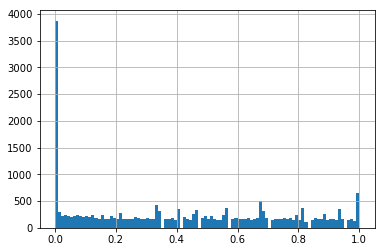

In [48]:
PERS_big5_corr["agreeableness_p"].hist(bins=100);

In [52]:
PERS_big5_corr[ (PERS_big5_corr["N"]>=2) & (PERS_big5_corr["agreeableness_p"].isnull())]["N"].value_counts()

2    1310
Name: N, dtype: int64

In [69]:
df = PERS_big5_corr.drop("movieId",axis=1)[PERS_big5_corr["N"]>2].copy()
df = df.replace(np.nan, 0)

agreeableness_mean          float64
agreeableness_p             float64
agreeableness_r             float64
agreeableness_std           float64
conscientiousness_mean      float64
conscientiousness_p         float64
conscientiousness_r         float64
conscientiousness_std       float64
emotional_stability_mean    float64
emotional_stability_p       float64
emotional_stability_r       float64
emotional_stability_std     float64
extraversion_mean           float64
extraversion_p              float64
extraversion_r              float64
extraversion_std            float64
openness_mean               float64
openness_p                  float64
openness_r                  float64
openness_std                float64
N                             int64
dtype: object

In [81]:
big5 = ['openness', 'agreeableness', 'emotional_stability',
       'conscientiousness', 'extraversion']

df_no_high_p = df.copy()
for pers in big5:
    non_sig = df_no_high_p[pers+"_p"]>0.05
    df_no_high_p.loc[non_sig,pers+"_r"] = 0
    df_no_high_p.loc[non_sig,pers+"_p"] = 0


In [74]:
df.corr()["N"].sort_values()

agreeableness_p            -0.200282
emotional_stability_p      -0.128284
extraversion_p             -0.100455
openness_p                 -0.077047
conscientiousness_p        -0.073725
agreeableness_std          -0.058899
agreeableness_mean         -0.029781
extraversion_r             -0.023131
conscientiousness_mean     -0.006393
emotional_stability_r      -0.004981
conscientiousness_r         0.001451
openness_r                  0.004732
agreeableness_r             0.009777
extraversion_std            0.030608
openness_mean               0.043586
conscientiousness_std       0.054837
extraversion_mean           0.065683
openness_std                0.071976
emotional_stability_mean    0.079840
emotional_stability_std     0.087974
N                           1.000000
Name: N, dtype: float64

In [85]:
df2 = df.copy()
df = df_no_high_p.copy()

In [90]:
df2.describe()

agreeableness_mean  agreeableness_p  agreeableness_r  \
count        19461.000000     19461.000000     19461.000000   
mean             4.226664         0.477548         0.062379   
std              0.478277         0.302325         0.399400   
min              1.666667         0.000000        -1.000000   
25%              4.000000         0.210000        -0.110000   
50%              4.210526         0.470000         0.070000   
75%              4.460000         0.730000         0.260000   
max              6.500000         1.000000         1.000000   

       agreeableness_std  conscientiousness_mean  conscientiousness_p  \
count       19461.000000            19461.000000         19461.000000   
mean            1.230326                4.715240             0.487591   
std             0.349509                0.454820             0.297716   
min             0.000000                2.333333             0.000000   
25%             1.072393                4.500000             0.220000   
50%             1.215781                4.717391             0.480000   
75%             1.404500                4.940000             0.740000   
max             3.175426                6.666667             1.000000   

       conscientiousness_r  conscientiousness_std  emotional_stability_mean  \
count         19461.000000           19461.000000              19461.000000   
mean             -0.004959               1.241787                  4.508416   
std               0.409334               0.324045                  0.500307   
min              -1.000000               0.000000                  2.000000   
25%              -0.200000               1.108678                  4.250000   
50%               0.000000               1.270836                  4.545455   
75%               0.190000               1.388730                  4.763514   
max               1.000000               3.122499                  6.833333   

       emotional_stability_p  ...  emotional_stability_std  extraversion_mean  \
count           19461.000000  ...             19461.000000       19461.000000   
mean                0.489996  ...                 1.316979           3.306577   
std                 0.297945  ...                 0.329244           0.508906   
min                 0.000000  ...                 0.000000           1.166667   
25%                 0.220000  ...                 1.173388           3.041667   
50%                 0.490000  ...                 1.356801           3.335106   
75%                 0.750000  ...                 1.476929           3.541667   
max                 1.000000  ...                 3.214550           6.000000   

       extraversion_p  extraversion_r  extraversion_std  openness_mean  \
count    19461.000000    19461.000000      19461.000000   19461.000000   
mean         0.498168        0.069936          1.417966       5.304819   
std          0.294510        0.389711          0.385378       0.372615   
min          0.000000       -1.000000          0.000000       2.666667   
25%          0.240000       -0.100000          1.258306       5.129032   
50%          0.500000        0.060000          1.443376       5.333333   
75%          0.750000        0.270000          1.599479       5.500000   
max          1.000000        1.000000          3.214550       7.000000   

         openness_p    openness_r  openness_std             N  
count  19461.000000  19461.000000  19461.000000  19461.000000  
mean       0.476758     -0.009264      1.009114     51.815066  
std        0.299624      0.413027      0.311897    120.086340  
min        0.000000     -1.000000      0.000000      3.000000  
25%        0.210000     -0.220000      0.853913      5.000000  
50%        0.460000      0.000000      1.038333     11.000000  
75%        0.730000      0.190000      1.157854     38.000000  
max        1.000000      1.000000      3.055050   1555.000000  

[8 rows x 21 columns]

In [95]:
df = df2.copy()

average log-likelihood of all samples: -28.959836786309744
number of iterations: 737
Wall time: 24.9 s


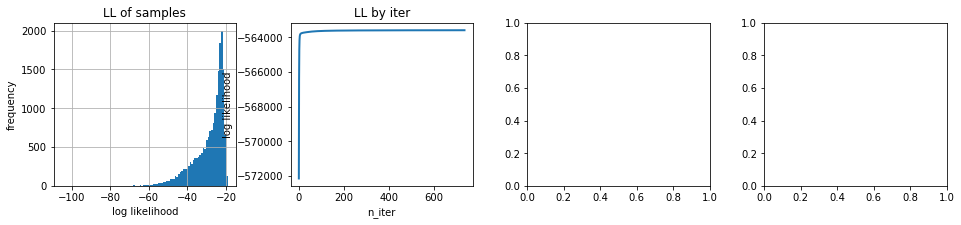

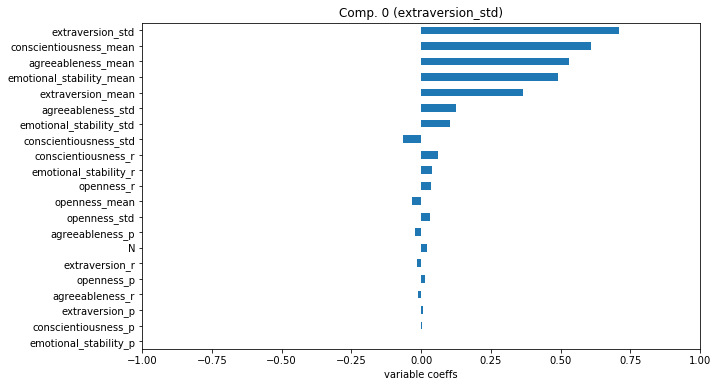

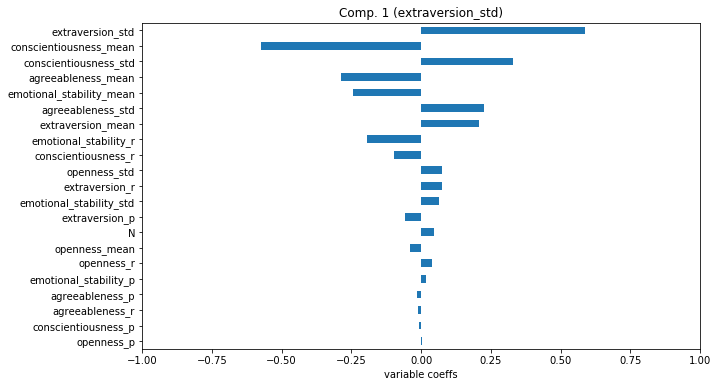

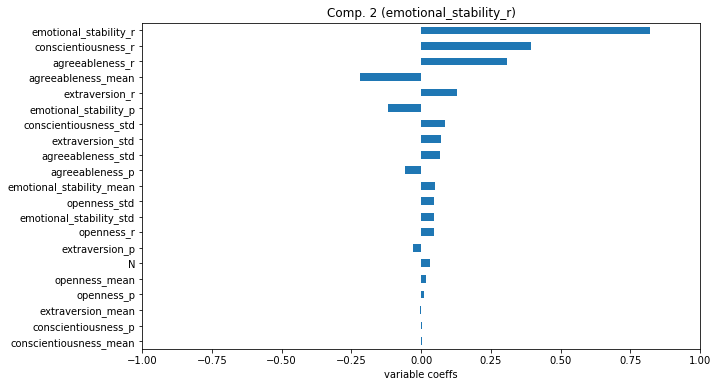

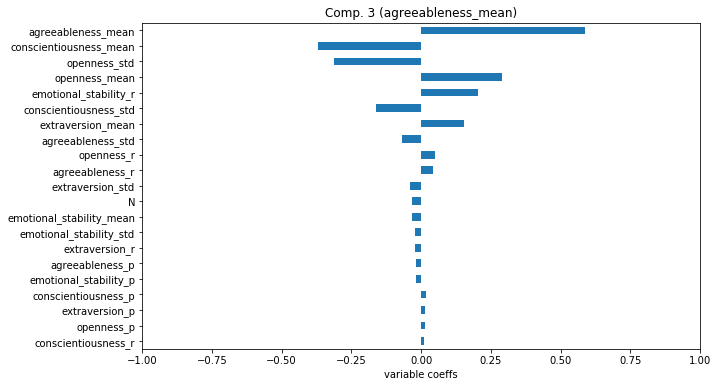

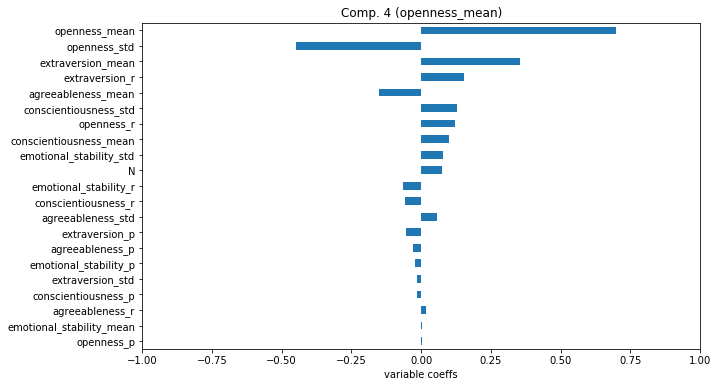

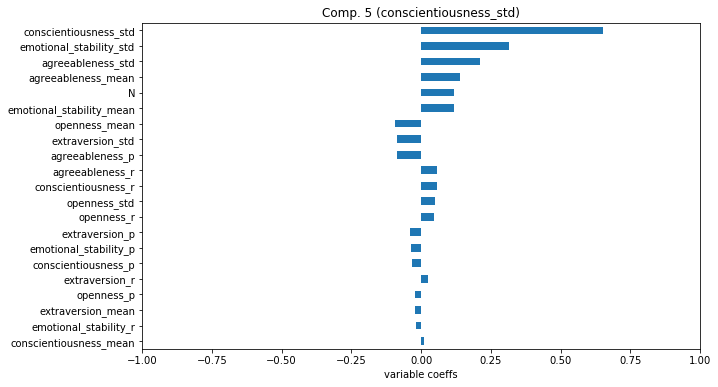

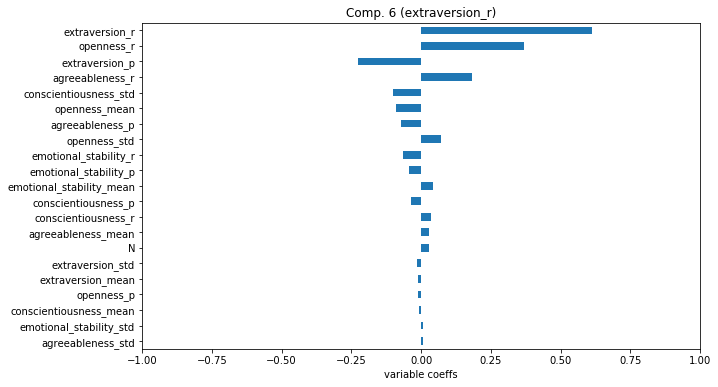

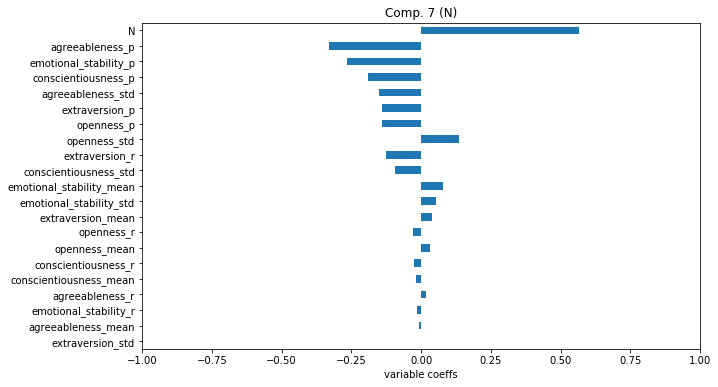

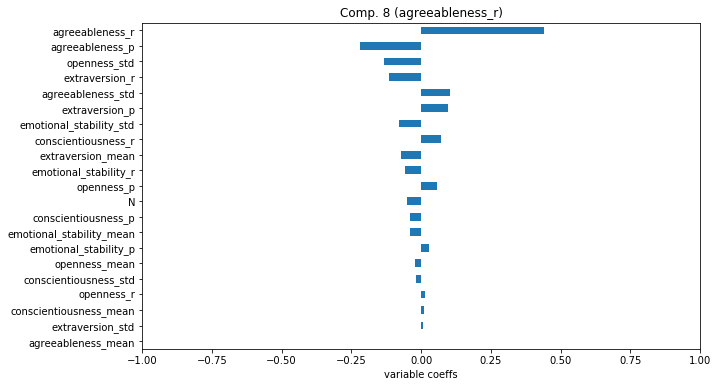

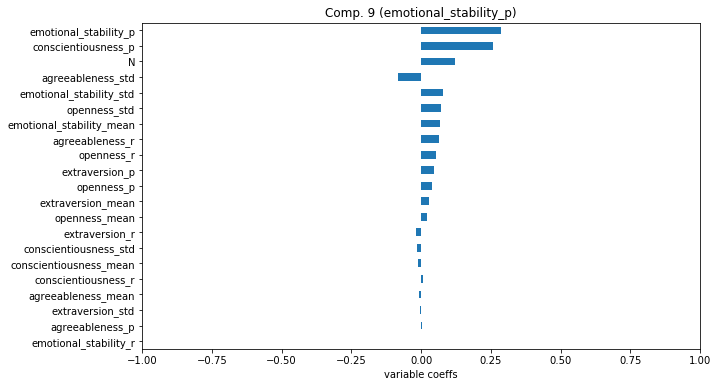

In [96]:
%%time
output_subfolder = ".."+os.sep+"Output"+os.sep+"PERS_big5"
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(df.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = df.columns,
                             index   = df.index      )



n_components = BES_std.shape[1]
n_components = 10

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = df.index)



load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
#     if not os.path.exists(subdir): os.makedirs(subdir)
#     with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
#     BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
#     BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
# else: # LOAD decomp results (default is SAVE)
#     decomp_method = load_suff
#     subdir = output_subfolder + os.sep + decomp_method    
#     fname = subdir + os.sep + decomp_method
#     if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
#     # load decomp object, BES_decomp, BES_std, n_components
#     with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
#     BES_decomp = pd.read_hdf(fname+".hdf")
#     BES_std    = pd.read_hdf(fname+"_std"+".hdf")
#     n_components = decomp.components_.shape[0] 

display_pca_data(n_components, decomp, BES_std)



(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          df.columns, BES_decomp, manifest=None, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= n_components, show_histogram = False)

In [94]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
#         NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
#         display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

noise_variance_
extraversion_std                 0.118602
agreeableness_mean               0.291571
extraversion_r                   0.331495
openness_mean                    0.359885
conscientiousness_std            0.408688
agreeableness_r                  0.419748
emotional_stability_r            0.439343
emotional_stability_std          0.471328
conscientiousness_mean           0.511207
emotional_stability_mean         0.530584
N                                0.647972
openness_std                     0.663754
extraversion_mean                0.680976
agreeableness_std                0.846559
extraversion_p                   0.849650
agreeableness_p                  0.902055
emotional_stability_p            0.955681
conscientiousness_r              0.979592
conscientiousness_p              0.985333
openness_r                       0.990600
openness_p                       0.991749

In [97]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
#         NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
#         display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

noise_variance_
extraversion_std                 0.135200
conscientiousness_mean           0.156730
agreeableness_mean               0.199323
emotional_stability_r            0.236435
conscientiousness_std            0.394091
openness_mean                    0.407235
extraversion_r                   0.546442
N                                0.638469
openness_std                     0.645468
extraversion_mean                0.666898
emotional_stability_mean         0.668898
agreeableness_r                  0.669448
conscientiousness_r              0.818712
agreeableness_p                  0.823749
emotional_stability_p            0.828545
agreeableness_std                0.835978
openness_r                       0.837085
emotional_stability_std          0.861413
conscientiousness_p              0.892509
extraversion_p                   0.908903
openness_p                       0.974974

In [ ]:
#########################################
# Cast/Crew

In [104]:
TMB_crew[0:1000].groupby("movieId").apply(lambda x: x["job"].value_counts())

movieId                                
1        Animation                         26
         Character Designer                 8
         Visual Effects                     5
         Assistant Editor                   4
         Screenplay                         4
         Original Story                     4
         Assistant Sound Editor             4
         Set Dresser                        3
         Producer                           2
         Orchestrator                       2
         Editor                             2
         Executive Producer                 2
         Sound Re-Recording Mixer           2
         Negative Cutter                    2
         Lighting Supervisor                2
         Animation Director                 2
         CG Painter                         2
         Sculptor                           2
         Layout                             2
         Production Coordinator             2
         Supervising Technical Director 

In [109]:
TMB_crew[ TMB_crew["job"]=="Director" ]

credit_id department       id  \
credit_id                                                                
52fe4284c3a36847f8024f49  52fe4284c3a36847f8024f49  Directing     7879   
52fe44bfc3a36847f80a7c7d  52fe44bfc3a36847f80a7c7d  Directing     4945   
52fe466a9251416c75077a89  52fe466a9251416c75077a89  Directing    26502   
52fe44779251416c91011acb  52fe44779251416c91011acb  Directing     2178   
52fe44959251416c75039eef  52fe44959251416c75039eef  Directing    56106   
52fe4292c3a36847f802916d  52fe4292c3a36847f802916d  Directing      638   
52fe44959251416c75039da9  52fe44959251416c75039da9  Directing     2226   
52fe46bdc3a36847f810f76d  52fe46bdc3a36847f810f76d  Directing    18357   
52fe44dbc3a36847f80ae0f1  52fe44dbc3a36847f80ae0f1  Directing    37710   
52fe426ec3a36847f801e14b  52fe426ec3a36847f801e14b  Directing    10702   
52fe44dac3a36847f80adf8b  52fe44dac3a36847f80adf8b  Directing     3026   
52fe44b79251416c7503e7e3  52fe44b79251416c7503e7e3  Directing    14639   
52fe4409c3a368484e00bb6f  52fe4409c3a368484e00bb6f  Directing    21879   
52fe43c59251416c7501d6f3  52fe43c59251416c7501d6f3  Directing     1152   
52fe42f4c3a36847f802f681  52fe42f4c3a36847f802f681  Directing    16938   
52fe424dc3a36847f80139cd  52fe424dc3a36847f80139cd  Directing     1032   
52fe43cec3a36847f807101f  52fe43cec3a36847f807101f  Directing     1614   
52fe420dc3a36847f800012d  52fe420dc3a36847f800012d  Directing     3110   
52fe420dc3a36847f8000133  52fe420dc3a36847f8000133  Directing     3111   
52fe420dc3a36847f8000139  52fe420dc3a36847f8000139  Directing     2294   
52fe420dc3a36847f800013f  52fe420dc3a36847f800013f  Directing      138   
52fe44dfc3a36847f80af28b  52fe44dfc3a36847f80af28b  Directing     4489   
52fe44509251416c750305a1  52fe44509251416c750305a1  Directing    52629   
52fe448dc3a36847f809c729  52fe448dc3a36847f809c729  Directing     5174   
52fe430ec3a36847f8037233  52fe430ec3a36847f8037233  Directing    15148   
52fe451cc3a36847f80bd145  52fe451cc3a36847f80bd145  Directing     7187   
52fe45129251416c7504ab67  52fe45129251416c7504ab67  Directing    56349   
52fe4245c3a36847f80111a5  52fe4245c3a36847f80111a5  Directing     6111   
52fe46d29251416c75084b07  52fe46d29251416c75084b07  Directing    56710   
52fe44dec3a36847f80aed45  52fe44dec3a36847f80aed45  Directing    15798   
...                                            ...        ...      ...   
54edb0e0c3a3686d58003a13  54edb0e0c3a3686d58003a13  Directing  1109734   
52fe49099251416c910a0a89  52fe49099251416c910a0a89  Directing   100793   
56772393c3a368168b00650a  56772393c3a368168b00650a  Directing   131785   
532856a8c3a3683158002766  532856a8c3a3683158002766  Directing  1212412   
52fe4684c3a36847f81034f3  52fe4684c3a36847f81034f3  Directing    11523   
52fe478dc3a36847f813bd5f  52fe478dc3a36847f813bd5f  Directing    11523   
52fe4684c3a36847f810350b  52fe4684c3a36847f810350b  Directing    11523   
52fe478dc3a36847f813bd4b  52fe478dc3a36847f813bd4b  Directing    11523   
52fe478dc3a36847f813bd19  52fe478dc3a36847f813bd19  Directing    11523   
52fe4684c3a36847f810345f  52fe4684c3a36847f810345f  Directing    11523   
52fe4a74c3a368484e1542e9  52fe4a74c3a368484e1542e9  Directing    11523   
52fe46249251416c7506e969  52fe46249251416c7506e969  Directing    77488   
52fe46249251416c7506e96f  52fe46249251416c7506e96f  Directing    92694   
52fe478dc3a36847f813bd6b  52fe478dc3a36847f813bd6b  Directing    11523   
52fe4a71c3a36847f81ce35b  52fe4a71c3a36847f81ce35b  Directing    11523   
58196bc0c3a36809540035df  58196bc0c3a36809540035df  Directing  1601664   
577809939251415f150019c4  577809939251415f150019c4  Directing  1644440   
587626f4c3a3682b33008299  587626f4c3a3682b33008299  Directing  1736944   
52fe475bc3a368484e0c2a7b  52fe475bc3a368484e0c2a7b  Directing    24279   
52fe475bc3a368484e0c2a81  52fe475bc3a368484e0c2a81  Directing    24281   
52fe48f49251416c9109dcd5  52fe48f49251416c9109dcd5  Directing    89745   
56ff6ddbc3a3686e9e0013bc  56ff6ddbc3a3686e9e0

In [116]:
num_directors = TMB_crew[ TMB_crew["job"]=="Director" ].groupby("movieId").count()["job"]#.value_counts()
TMB_crew.shape, num_directors.shape

((463836, 8), (44545,))

In [117]:
TMB_crew[ TMB_crew["job"]=="Producer" ].groupby("movieId").count()["job"].value_counts()

1     10648
2      5917
3      2891
4      1365
5       621
6       298
7       131
8        54
9        28
10       14
12        7
11        4
13        2
15        1
17        1
22        1
20        1
14        1
16        1
Name: job, dtype: int64

In [119]:
TMB_crew.groupby("movieId").apply(lambda x: x["job"][0]).value_counts()

Director                            25508
Producer                             2792
Screenplay                           2697
Writer                               2012
Director of Photography              1926
Original Music Composer              1552
Editor                               1407
Casting                              1380
Executive Producer                   1047
Music                                 648
Art Direction                         402
Production Design                     396
Novel                                 346
Cinematography                        298
Costume Design                        297
Story                                 224
Set Decoration                        161
Author                                121
Co-Producer                            86
Makeup Artist                          75
Characters                             69
Associate Producer                     61
Sound Designer                         58
Theatre Play                      

In [100]:
TMB_crew["job"].value_counts()

Director                          48999
Producer                          43507
Writer                            30398
Screenplay                        25143
Editor                            23770
Director of Photography           20640
Executive Producer                18853
Original Music Composer           15773
Casting                           12620
Art Direction                     11679
Costume Design                    11010
Production Design                 10524
Set Decoration                     7543
Music                              7333
Makeup Artist                      6400
Story                              5809
Novel                              5119
Script Supervisor                  4321
Cinematography                     4206
Camera Operator                    4123
Animation                          3828
Sound Re-Recording Mixer           3677
Associate Producer                 3592
Hairstylist                        3537
Co-Producer                        3182
